# Hauspreise in Kalifornien: Analysen, Vorhersagen und Anwendungen für eine Feuerversicherung
### Praktische Prüfung im Vertiefungswissen Actuarial Data Science Immersion April/Mai 2024
Autor: Florian Eheim

# Teil A: Hauspreise analysieren und einfach prognostizieren

## Aufgabe A-0: Bibliotheken, Funktionen, Datenstrukturen
> Alle für die weiteren Aufgaben benötigten Bibliotheken und Funktionen sind zentral an dieser Stelle einzubinden bzw. zu definieren. Ebenso sollen alle globalen Variablen in diesem Teil angegeben werden. Des Weiteren sollen Datenstrukturen für den Vergleich der Laufzeiten der Teile A, B und C sowie Datenstrukturen für den Vergleich der Laufzeiten und Modellgüten RMSE bezüglich der Validierungsstichprobe für die Modelle der Aufgaben A-7 und B-1, B-2 b) bis B-4 erstellt werden.

In [3]:
!pip install catboost

  Using cached catboost-1.2.5-cp310-cp310-manylinux2014_x86_64.whl (98.2 MB)


In [4]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import math
import sklearn.linear_model
import sklearn.preprocessing
import sklearn.metrics
import catboost
import sklearn
import time
from tensorflow import keras
import pickle
import tensorflow as tf
import os
import lightgbm as lgb
import sklearn.cluster
import xgboost as xgb
import geopandas as gpd
import psutil

In [5]:
seed = 43
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [6]:
# Laufzeiten als Dictionary
times = {}
# Dictionary der RMSE für Validierungsdaten und Testdaten
rmses = {}
rmsestest = {}

In [7]:
# GPU verfügbar?
if tf.config.experimental.list_physical_devices('GPU'):
  print('GPU verfügbar')
else:
  print('GPU nicht verfügbar')

GPU verfügbar


In [8]:
runtime_folder='gpu/'

In [9]:
drive_path='/content/drive'
folder_path=drive_path+'/MyDrive/cads/pruefung/'
results_path=folder_path+runtime_folder

In [10]:
def save_times(times):
  timepath=results_path+'times.pkl'
  with open(timepath, 'wb') as file:
      pickle.dump(times, file)

def plotcali(data, column, label, cal_img) :
  plot_axis = data.plot(
             kind="scatter", x="longitude", y="latitude",
             s=data["population"] / 100,
             xlabel="Longitude", ylabel="Latitude",
             label="Population",
             c=column, colormap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(20, 10))
  plot_axis.collections[0].colorbar.set_label(label)
  axisrange = [-124.55, -113.95, 32.45, 42.05]
  plt.axis(axisrange)
  plt.imshow(cal_img, extent=axisrange)
  plt.show()

def rmse(y_val, y_pred):
  return np.sqrt(sklearn.metrics.mean_squared_error(y_val, y_pred))

def print_results(y_val, y_pred):
  print("RMSE:",rmse(y_val, y_pred))
  rmst = np.std(y_val, ddof=0)
  print("RMST (zum Vergleich):",rmst)
  r2 = sklearn.metrics.r2_score(y_val, y_pred)
  print("R^2:",r2)

def plotRelFreq(data, column, column_label, height):
  rel_freq = (data[column].value_counts() / len(data))*100.0
  plotdata = pd.DataFrame({column: rel_freq.index,'relfreq': rel_freq.values,})
  plt.figure(figsize=(20, height))
  sns.barplot(x='relfreq', y=column, data=plotdata, orient='h')
  plt.yticks(fontsize=14)
  plt.xticks(fontsize=14)
  plt.xlabel('Relative Häufigkeit in %', fontsize=14)
  plt.ylabel(column_label, fontsize=14)
  plt.tight_layout()
  plt.show()

# Insgesamt log(Neuronen) Layer
# Anzahl der Neuronen pro Layer konstant
def simple_layer_shape(neurons):
  layers = int(math.log(neurons))
  npl = int(neurons/layers)
  layer_neurons_list = [npl for i in range(0,layers)]
  return layer_neurons_list

# Einfaches Regressionsnetzwerk
def simple_network(middle_neurons, num_features):
  layer_shape = simple_layer_shape(middle_neurons)
  layers = [keras.layers.Dense(layer_shape[0], activation='relu', input_shape=(num_features,))]
  layers.extend([keras.layers.Dense(layer_size, activation='relu') for layer_size in layer_shape[1:]])
  layers.append(keras.layers.Dense(1))
  model = keras.Sequential(layers)
  model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error'])
  return model

# Einfaches Regressionsnetzwerk mit Regularisierung und vorgebbarer Lernrate
def simple_regularized_network(middle_neurons, num_features, reg_strength, learning_rate=0.001):
  layer_shape = simple_layer_shape(middle_neurons)
  layers = [keras.layers.Dense(layer_shape[0], activation='relu', kernel_regularizer=keras.regularizers.l2(reg_strength), input_shape=(num_features,))]
  layers.extend([keras.layers.Dense(layer_size, activation='relu',kernel_regularizer=keras.regularizers.l2(reg_strength)) for layer_size in layer_shape[1:]])
  layers.append(keras.layers.Dense(1))
  model = keras.Sequential(layers)
  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
  model.compile(optimizer=optimizer,
              loss='mean_squared_error',
              metrics=['mean_squared_error'])
  return model

def save_model(model, history, path, name):
  model.save(path+name+'_model.h5')
  with open(path+name+'_history.pkl', 'wb') as file:
      pickle.dump(history.history, file)

def load_model(path, name):
    print(path+name+'_model.h5')
    model = keras.models.load_model(path+name+'_model.h5')
    with open(path+name+'_history.pkl', 'rb') as file:
        loaded_history_dict = pickle.load(file)
    history = type('History', (), {'history': loaded_history_dict})
    return model, history

# Modell entweder trainieren und abspeichern oder gespeichertes Modell laden
def train_model(model, x_train, y_train, epochs, name, retrain_model=True, do_save_model=True, verbosity=0):
  if retrain_model:
    history = model.fit(x_train.values.astype(float), y_train.values.astype(float), epochs=epochs, batch_size=min(512,len(x_train)), validation_split=0.2, verbose=verbosity)
    if do_save_model:
      save_model(model, history, results_path, name)
  else:
    model, history = load_model(results_path, name)
  return model, history

def train_model_early_stopping(model, x_train, y_train, epochs, name, retrain_model=True, do_save_model=True, verbosity=0):
  if retrain_model:
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=100, restore_best_weights=True)
    history = model.fit(x_train.values.astype(float), y_train.values.astype(float), epochs=epochs, batch_size=min(512,len(x_train)), validation_split=0.2, callbacks=[early_stopping],verbose=verbosity)
    if do_save_model:
      save_model(model, history, results_path, name)
  else:
    model, history = load_model(results_path, name)
  return model, history

def train_embed_model(model, x_train, y_train, epochs, name, retrain_model=True, do_save_model=True, verbosity=0):
  if retrain_model:
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=100, restore_best_weights=True)
    history = model.fit([x_train['ocean_proximity'].cat.codes,x_train['county_name'].cat.codes, x_train[numeric_features].values.astype(float)], y_train.values.astype(float), epochs=epochs, batch_size=min(512,len(x_train)), validation_split=0.2, callbacks=[early_stopping],verbose=verbosity)
    if do_save_model:
      save_model(model, history, results_path, name)
  else:
    model, history = load_model(results_path, name)
  return model, history

def plot_embedding(feature_name,embedding_model, x_train, title, x_size=20, y_size=10, fontsize=16):
  code_to_category = {code: cat for  code,cat in zip(x_train[feature_name].cat.codes, x_train[feature_name])}
  embedding_predictions = embedding_model.predict(np.array(list(code_to_category.keys())))
  x_coords = embedding_predictions[:,0, 0]
  y_coords = embedding_predictions[:,0, 1]
  labels = list(code_to_category.values())
  plt.figure(figsize=(x_size, y_size))
  plt.scatter(x_coords, y_coords, alpha=0.5)
  for i, label in enumerate(labels):
      plt.text(x_coords[i], y_coords[i], label, fontsize=fontsize, ha='left', va='bottom')
  plt.xlabel('Dimension 1')
  plt.ylabel('Dimension 2')
  plt.title(title)
  plt.show()

def plot_embed_axis(ax, x_coords, y_coords, labels,title):
  ax.scatter(x_coords, y_coords, alpha=0.5)
  for i, label in enumerate(labels):
     ax.text(x_coords[i], y_coords[i], label, fontsize=10, ha='left', va='bottom')
  ax.set_xlabel('Dim 1')
  ax.set_ylabel('Dim 2')
  ax.set_title(title)

def embedding_to_coords(embedding, series):
  code_to_category = {code: cat for  code,cat in zip(series.cat.codes, series)}
  embedding_predictions = embedding.predict(np.array(list(code_to_category.keys())))
  x_coords = embedding_predictions[:,0, 0]
  y_coords = embedding_predictions[:,0, 1]
  labels = list(code_to_category.values())
  return x_coords, y_coords, labels

def ncornerpoints(polygon):
  return len(polygon.exterior.coords) + sum(len(interior.coords) for interior in polygon.interiors)

def plot_embedding_ax(ax, feature_name,embedding_model, x_train, title, fontsize=12):
  code_to_category = {code: cat for  code,cat in zip(x_train[feature_name].cat.codes, x_train[feature_name])}
  embedding_predictions = embedding_model.predict(np.array(list(code_to_category.keys())))
  x_coords = embedding_predictions[:,0, 0]
  y_coords = embedding_predictions[:,0, 1]
  labels = list(code_to_category.values())
  ax.scatter(x_coords, y_coords, alpha=0.5)
  for i, label in enumerate(labels):
      ax.text(x_coords[i], y_coords[i], label, fontsize=fontsize, ha='left', va='bottom')
  ax.set_xlabel('Dimension 1')
  ax.set_ylabel('Dimension 2')
  ax.set_title(title)

In [11]:
retrain_models = True #Modelle entweder neu trainieren oder laden
nn_verbosity = 0

In [12]:
drive.mount(drive_path)
if not retrain_models:
  timepath=results_path+'times.pkl'
  if os.path.exists(timepath):
    with open(timepath, 'rb') as file:
      times = pickle.load(file)
  del timepath, file

Mounted at /content/drive


## Aufgabe A-1: Datensatz einlesen und prüfen
>Der Ihnen zur Verfügung gestellte Datensatz california_housing_county_sample-de.csv enthält demografische Informationen zum US-Bundesstaat Kalifornien. Insgesamt enthält der Datensatz die folgenden 12 Merkmale: [...] Es ist zu beachten, dass es sich bei den Angaben der Merkmale 3 bis 9 um aggregierte Informationen auf Bezirksebene (Wahlbezirke 1992) handelt. Die nachfolgenden Aufgaben sind der Reihe nach durchzuführen:


### Aufgabe A-1 a)

> Der zur Verfügung gestellte Datensatz ist einzulesen. Im Anschluss sind die Anzahl an Zeilen und Spalten sowie sieben zufällige Zeilen auszugeben.



In [13]:
data = pd.read_csv(folder_path+'california_housing_county_sample-de.csv',delimiter=';',decimal=',',thousands='.')

In [14]:
rows, columns = data.shape
display('Zeilen: '+str(rows))
display('Spalten: '+str(columns))
display('7 zufällige Zeilen:')
display(data.sample(n=7, random_state=seed))

'Zeilen: 20640'

'Spalten: 12'

'7 zufällige Zeilen:'

latitude  longitude  housing_median_age  total_rooms  total_bedrooms  \
7310      34.05    -117.27                  34         1703           395.0   
4402      33.88    -117.57                  35         1755           446.0   
1929      33.60    -117.90                  25         2465           585.0   
11551     35.37    -118.97                  34         1379           333.0   
9882      34.20    -118.36                  14         1878           614.0   
3896      33.85    -118.39                  24         4373           871.0   
16638     37.83    -122.25                  52         1279           287.0   

       population  households  median_income  median_house_value  \
7310          849         359         3.1607              138200   
4402         1453         428         2.3160              119400   
1929          906         472         3.6538              500001   
11551        1156         315         1.7197               48900   
9882         1874         559         2.5267              231800   
3896         1830         824         5.7128              366200   
16638         534         291         3.1429              231600   

      ocean_proximity     county_name sample  
7310           INLAND  San Bernardino      A  
4402           INLAND       Riverside      C  
1929        <1H OCEAN          Orange      A  
11551          INLAND            Kern      A  
9882        <1H OCEAN     Los Angeles      C  
3896        <1H OCEAN     Los Angeles      C  
16638        NEAR BAY         Alameda      B

In [15]:
del drive_path
del rows, columns

### Aufgabe A-1 b)
>Die Datentypen des eingelesenen Datensatzes sind auszugeben, zu prüfen und zu kommentieren. Nominale Merkmale sollen den Datentyp für Kategorien (Python: category, R: factor) erhalten. Gegebenenfalls erforderliche Anpassungen sind durchzuführen und die finalen Datentypen sind auszugeben.

Datentypen:

In [16]:
data.dtypes

latitude              float64
longitude             float64
housing_median_age      int64
total_rooms             int64
total_bedrooms        float64
population              int64
households              int64
median_income         float64
median_house_value      int64
ocean_proximity        object
county_name            object
sample                 object
dtype: object

latitude, longitude, total_bedrooms und median_income sind Gleitkommazahlen.

Bei total_bedrooms sind semantisch eigentlich Ganzzahlen zu erwarten. Das ist weiter zu untersuchen.

housing_median_age, total_rooms, population, households und median_house_value sind Ganzzahlen. Falls weitere Berechnungen (Durchschnittsbildung etc.) auf diesen notwendig sind können sie zu Gleitkommazahlen konvertiert werden.

ocean_proximity, county_name und sample sind vom typ object und beinhalten Strings. Diese werden wir weiter konvertieren.


Testen auf fehlende Einträge:

In [17]:
for column in data.columns :
  print(column," hat ",data[data[column].isna() == True].size," fehlende Einträge")
del column

latitude  hat  0  fehlende Einträge
longitude  hat  0  fehlende Einträge
housing_median_age  hat  0  fehlende Einträge
total_rooms  hat  0  fehlende Einträge
total_bedrooms  hat  2484  fehlende Einträge
population  hat  0  fehlende Einträge
households  hat  0  fehlende Einträge
median_income  hat  0  fehlende Einträge
median_house_value  hat  0  fehlende Einträge
ocean_proximity  hat  0  fehlende Einträge
county_name  hat  0  fehlende Einträge
sample  hat  0  fehlende Einträge


total_bedrooms hat fehlende Einträge. Das könnte der Grund für die Gleitkommakonvertierung sein (int wäre als 0 nicht eindeutig erkennbar, float als NaN aber schon). Die Bereinigung machen wir später.

Die kategoriellen Daten werden in den Datentyp "category" konvertiert.

In [18]:
categorical_columns = ['ocean_proximity','county_name','sample']
for merkmal in categorical_columns:
    data[merkmal] = data[merkmal].astype('category')
del merkmal

Nach den Anpassungen haben wir folgende Datentypen:

In [19]:
data.dtypes

latitude               float64
longitude              float64
housing_median_age       int64
total_rooms              int64
total_bedrooms         float64
population               int64
households               int64
median_income          float64
median_house_value       int64
ocean_proximity       category
county_name           category
sample                category
dtype: object

### Aufgabe A-1 c)
> Das Merkmal sample, das fest vorgegebene Stichproben für das spätere Trainieren (A), Validieren (B) und Testen (C) der Modelle definiert, ist auszuzählen und die Stichprobengrößen sind zu kommentieren.

Anzahl der Stichproben pro Sample:

In [20]:
data['sample'].value_counts()

sample
A    14421
B     3110
C     3109
Name: count, dtype: int64

Anteile an der Gesamtanzahl der Stichproben

In [21]:
data['sample'].value_counts() / data['sample'].size

sample
A    0.698692
B    0.150678
C    0.150630
Name: count, dtype: float64

A umfasst mit fast 70% die meisten Stichproben, B und C haben fast eine ähnliche Anzahl mit jeweils knapp über 15%.
A eigent sich damit als Trainingssample, während B und C als Validierungs- bzw. Testsample verwendet werden können (insofern sich im weiteren Verlauf nicht herausstellt, dass die Samples einen Bias besitzen, also nicht zufällig zugeteilt wurden)

## Aufgabe A-2: Numerische Merkmale analysieren, aufbereiten und visualisieren

### Aufgabe A-2 a)
> Für die numerische Merkmale sind mindestens die Kennzahlen count, mean,
std, min/max sowie die das 25%-, 50%- und 75%-Quantil auszugeben. Zudem
soll ermittelt werden, bei welchen Merkmalen fehlende Werte (und falls ja, in
welcher absoluten und prozentualen Größenordnung) vorliegen.



Spalten mit Zahlenwerten:

In [22]:
numeric_columns = [column for column, dtype in data.dtypes.items() if dtype in ['int64', 'float64']]
display(numeric_columns)

['latitude',
 'longitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value']

Übersicht der Zahlenwerte

In [23]:
data[numeric_columns].describe()

latitude     longitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean      35.631861   -119.569704           28.639486   2635.763081   
std        2.135952      2.003532           12.585558   2181.615252   
min       32.540000   -124.350000            1.000000      2.000000   
25%       33.930000   -121.800000           18.000000   1447.750000   
50%       34.260000   -118.490000           29.000000   2127.000000   
75%       37.710000   -118.010000           37.000000   3148.000000   
max       41.950000   -114.310000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

Auffällig ist, dass median_incom offensichtlich nicht direkt über Doller-Werte repräsentiert ist. Möglicherweise sind dies Mehrfache von 10.000$. Das glatte Maximum deutet darauf hin, dass hier ab einer Obergrenze abgeschnitten bzw. minimiert wurde.

Fehlende Werte:

In [24]:
for column in data.columns :
  nas = data[data[column].isna() == True].size
  if(nas>0):
    print(column," hat ",nas," fehlende Einträge")
    print("Das ist ein Anteil von ",nas / data[column].size," des Datensatzes.")
del column
del nas

total_bedrooms  hat  2484  fehlende Einträge
Das ist ein Anteil von  0.12034883720930233  des Datensatzes.


Es fehlen also etwas mehr als 12% der Werte für total_bedrooms.

### Aufgabe A-2 b)
> Anhand des Datensatzes ist zu begründen und geeignet grafisch zu visualisieren, warum eine Ersetzung der fehlenden Werte bei total_bedrooms durch den Median nicht empfehlenswert ist (mindestens zwei konkrete Zeilen des Datensatzes sind als Beispiele auszugeben) und was für einen Bezug auf total_rooms spricht. Im Anschluss sind für das Feature total_bedrooms die fehlenden Werte durch den mittleren Quotienten zwischen total_bedrooms und total_rooms (berechnet auf Basis der Datensätze ohne fehlende Werte) zu ersetzen. Die Ersetzung ist geeignet zu verifizieren.



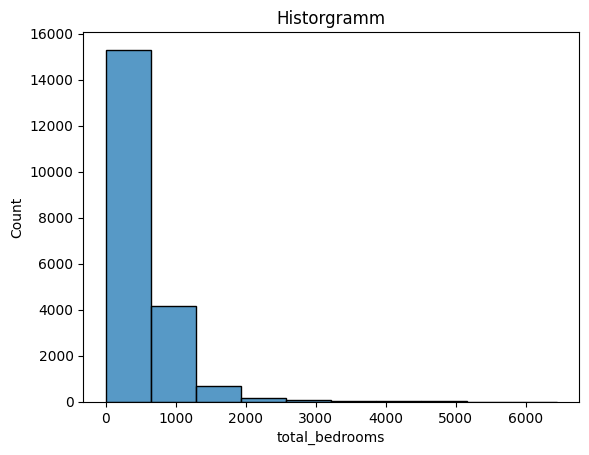

In [25]:
sns.histplot(data=data, x='total_bedrooms', bins=10)
plt.title("Historgramm")
plt.show()

Im Histogram ist zu sehen, dass total_bedrooms eine sehr schiefe Verteilung besitzt. Das spricht zunächst gegen den Median als Ersetzungswert.

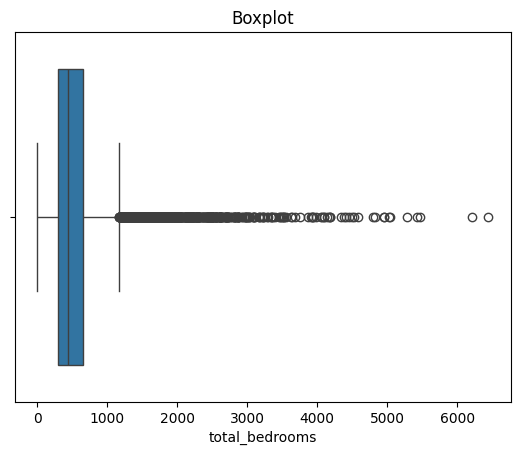

count    20433.000000
mean       537.870553
std        421.385070
min          1.000000
25%        296.000000
50%        435.000000
75%        647.000000
max       6445.000000
Name: total_bedrooms, dtype: float64

In [26]:
sns.boxplot(data=data, x='total_bedrooms')
plt.title("Boxplot")
plt.show()
display(data['total_bedrooms'].describe())

Der Boxplot bestätigt die schiefe Verteilung. Mit einem Minimum von 1 und einem Maximum von 6445 gibt es gegenüber den Quantilen auch extreme Werte in den Tails, insbesondere im oberen Quartil.

In [27]:
data['total_bedrooms'].median()

435.0

In [28]:
print("Minimum Population:")
display(data.loc[data['population'].idxmin()])

Minimum Population:


latitude                    34.04
longitude                 -118.44
housing_median_age             16
total_rooms                    18
total_bedrooms                6.0
population                      3
households                      4
median_income               0.536
median_house_value         350000
ocean_proximity         <1H OCEAN
county_name           Los Angeles
sample                          B
Name: 6895, dtype: object

In [29]:
print("Maximum Population:")
display(data.loc[data['population'].idxmax()])

Maximum Population:


latitude                  33.35
longitude               -117.42
housing_median_age           14
total_rooms               25135
total_bedrooms           4819.0
population                35682
households                 4769
median_income            2.5729
median_house_value       134400
ocean_proximity       <1H OCEAN
county_name           San Diego
sample                        C
Name: 1705, dtype: object

Eine Nutzung des Medians von 435 wäre insbesondere in den Extremen der Population komplett unplausibel.

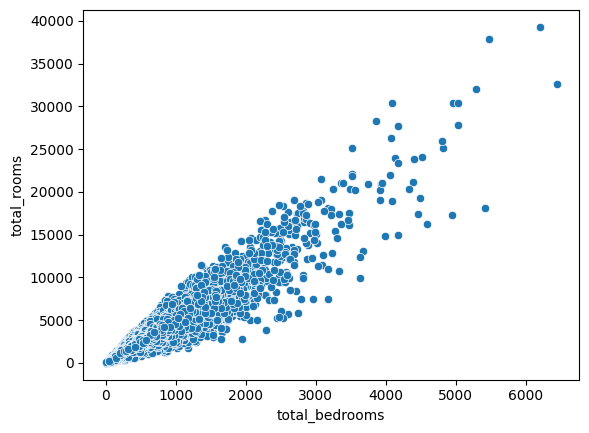

In [30]:
sns.scatterplot(data=data, x='total_bedrooms', y='total_rooms')
plt.show()

In [31]:
data['total_bedrooms'].corr(data['total_rooms'])

0.9303795046865075

Es besteht offensichtlich eine starke Korrelation zwischen Schlafzimmern und Räumen, sie sind nahezu linear zueinander. Das zeigt auch der Korrelationskoeffizient.

In [32]:
bedrooms_per_room = (data[data['total_bedrooms'].isna() == False]['total_bedrooms'] / data[data['total_bedrooms'].isna()==False]['total_rooms']).mean()
print("Mittlerer Anteil Schlafzimmer an allen Räumen: ", bedrooms_per_room)

Mittlerer Anteil Schlafzimmer an allen Räumen:  0.2130388304808513


Fehlende Werte der Schlafzimmer werden via Faktor aus den Räumen ersetzt

In [33]:
missing_indices_sample = data[data['total_bedrooms'].isna()].sample(n=5, random_state=seed).index

In [34]:
print("Sample der Daten vor Imputation")
display(data.loc[missing_indices_sample])

Sample der Daten vor Imputation


latitude  longitude  housing_median_age  total_rooms  total_bedrooms  \
6446      34.01    -117.86                  16         4632             NaN   
4212      33.87    -117.92                  33         1597             NaN   
7594      34.07    -118.37                  50         2519             NaN   
7407      34.06    -118.28                  42         2472             NaN   
17686     38.01    -120.37                  30          473             NaN   

       population  households  median_income  median_house_value  \
6446         3038         727         5.1762              264400   
4212         1888         423         3.0550              157800   
7594         1117         516         4.3667              405600   
7407         3795        1179         1.2254              162500   
17686         242          93         2.5417              123200   

      ocean_proximity  county_name sample  
6446        <1H OCEAN  Los Angeles      A  
4212        <1H OCEAN       Orange      B  
7594        <1H OCEAN  Los Angeles      A  
7407        <1H OCEAN  Los Angeles      A  
17686          INLAND     Tuolumne      C

Fehlende Werte der Schlafzimmer werden via Faktor aus den Räumen ersetzt

In [35]:
data['total_bedrooms'] = data['total_bedrooms'].fillna(data['total_rooms']*bedrooms_per_room)
del bedrooms_per_room

In [36]:
print("Sample nach Imputation")
display(data.loc[missing_indices_sample])
del missing_indices_sample


Sample nach Imputation


latitude  longitude  housing_median_age  total_rooms  total_bedrooms  \
6446      34.01    -117.86                  16         4632      986.795863   
4212      33.87    -117.92                  33         1597      340.223012   
7594      34.07    -118.37                  50         2519      536.644814   
7407      34.06    -118.28                  42         2472      526.631989   
17686     38.01    -120.37                  30          473      100.767367   

       population  households  median_income  median_house_value  \
6446         3038         727         5.1762              264400   
4212         1888         423         3.0550              157800   
7594         1117         516         4.3667              405600   
7407         3795        1179         1.2254              162500   
17686         242          93         2.5417              123200   

      ocean_proximity  county_name sample  
6446        <1H OCEAN  Los Angeles      A  
4212        <1H OCEAN       Orange      B  
7594        <1H OCEAN  Los Angeles      A  
7407        <1H OCEAN  Los Angeles      A  
17686          INLAND     Tuolumne      C

In [37]:
print("Noch fehlende Werte für Schlafzimmer: ",data[data['total_bedrooms'].isna()].size)

Noch fehlende Werte für Schlafzimmer:  0


### Aufgabe A-2 c)
> Zu den bereits vorhandenen Merkmalen sollen noch die folgenden Merkmale zum Datensatz hinzugefügt werden:
>• bedrooms_per_house = total_bedrooms / households
>• rooms_per_house = total_rooms / households
>Die Berechnung ist an zwei ausgewählten Datensätzen zu demonstrieren.


Ergänzung von Schlafzimmer pro Haushalt und Räume pro Haushalt.

In [38]:
data['bedrooms_per_house'] = data['total_bedrooms'] / data['households']
data['rooms_per_house'] = data['total_rooms'] / data['households']
if 'bedrooms_per_house' not in numeric_columns: numeric_columns.append('bedrooms_per_house')
if 'rooms_per_house' not in numeric_columns: numeric_columns.append('rooms_per_house')

In [39]:
data.sample(n=2, random_state=seed)

latitude  longitude  housing_median_age  total_rooms  total_bedrooms  \
7310     34.05    -117.27                  34         1703           395.0   
4402     33.88    -117.57                  35         1755           446.0   

      population  households  median_income  median_house_value  \
7310         849         359         3.1607              138200   
4402        1453         428         2.3160              119400   

     ocean_proximity     county_name sample  bedrooms_per_house  \
7310          INLAND  San Bernardino      A            1.100279   
4402          INLAND       Riverside      C            1.042056   

      rooms_per_house  
7310         4.743733  
4402         4.100467

### Aufgabe A-2 d)
> Die numerischen Merkmale sind zusammen mit einem Kerndichteschätzer zu visualisieren und die Ausgaben zu kommentieren.

Kerndichteplot für jedes numerisches Merkmal

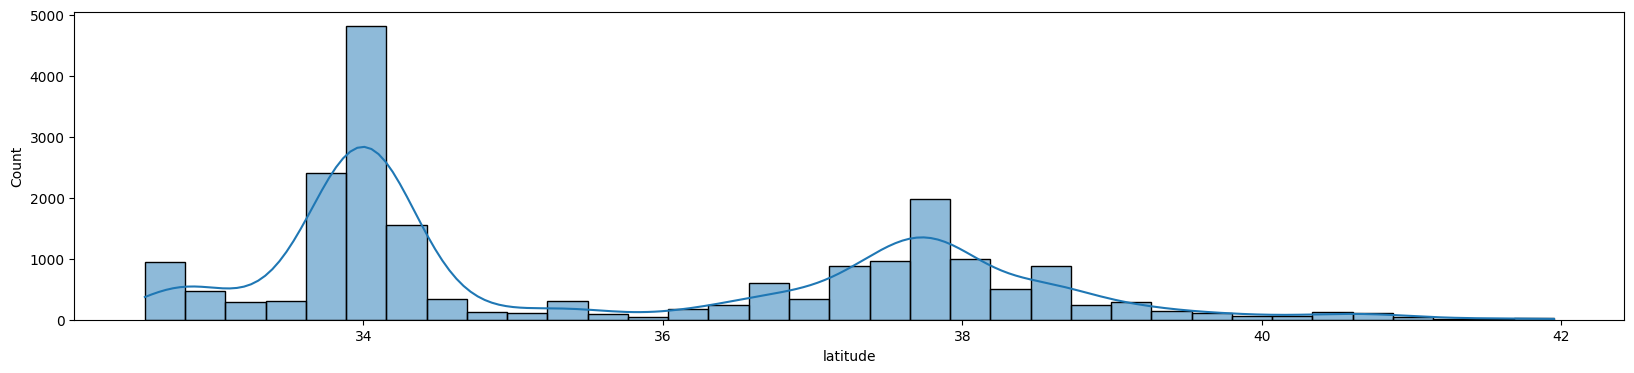

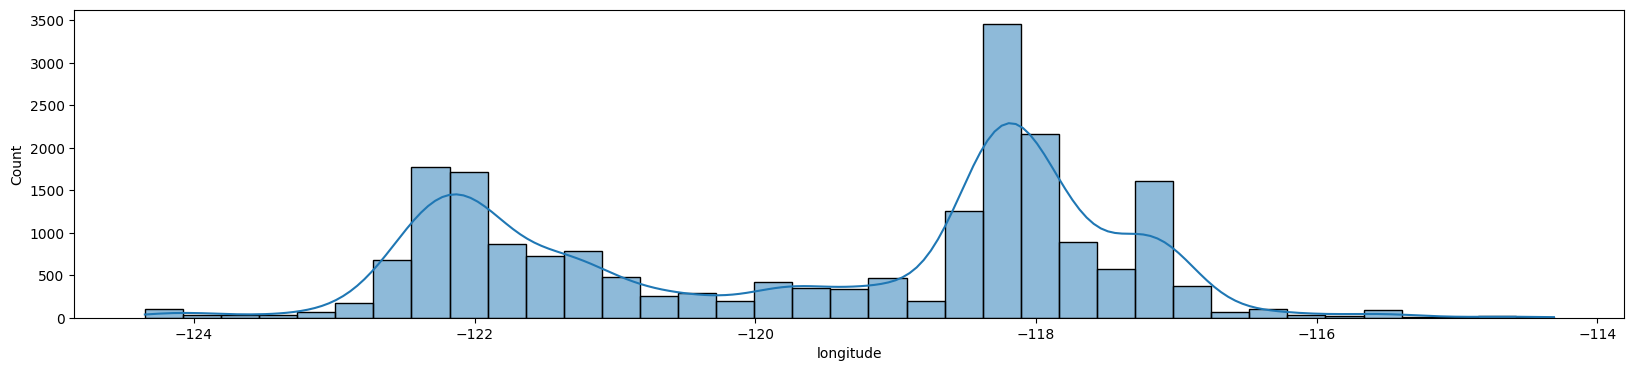

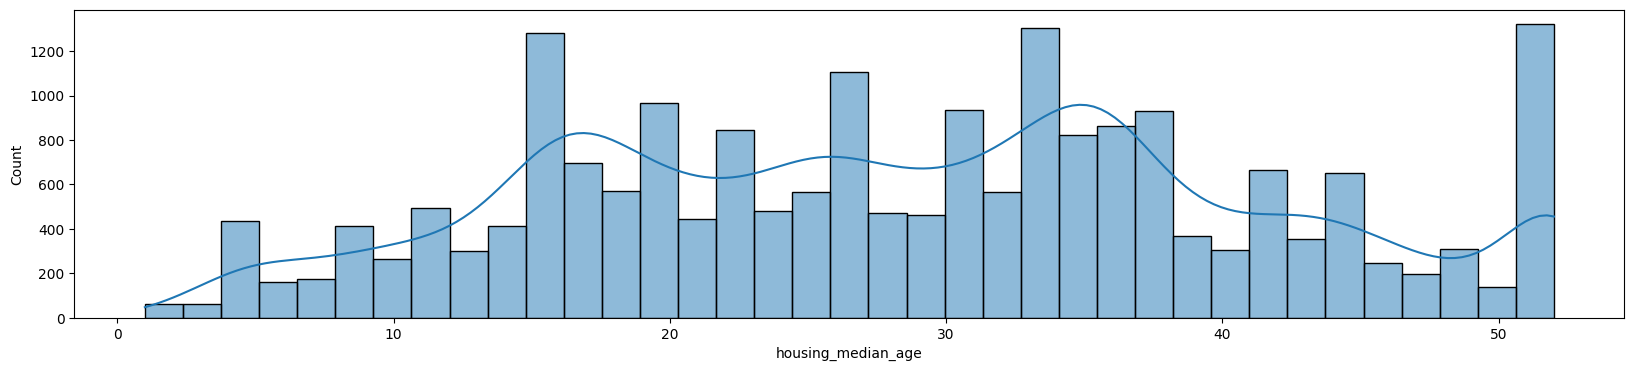

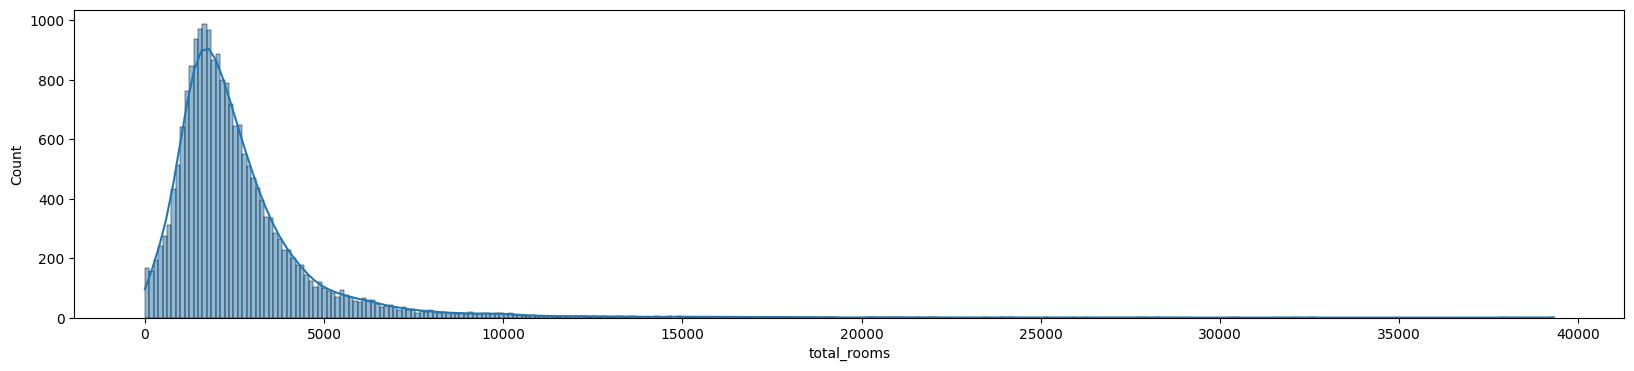

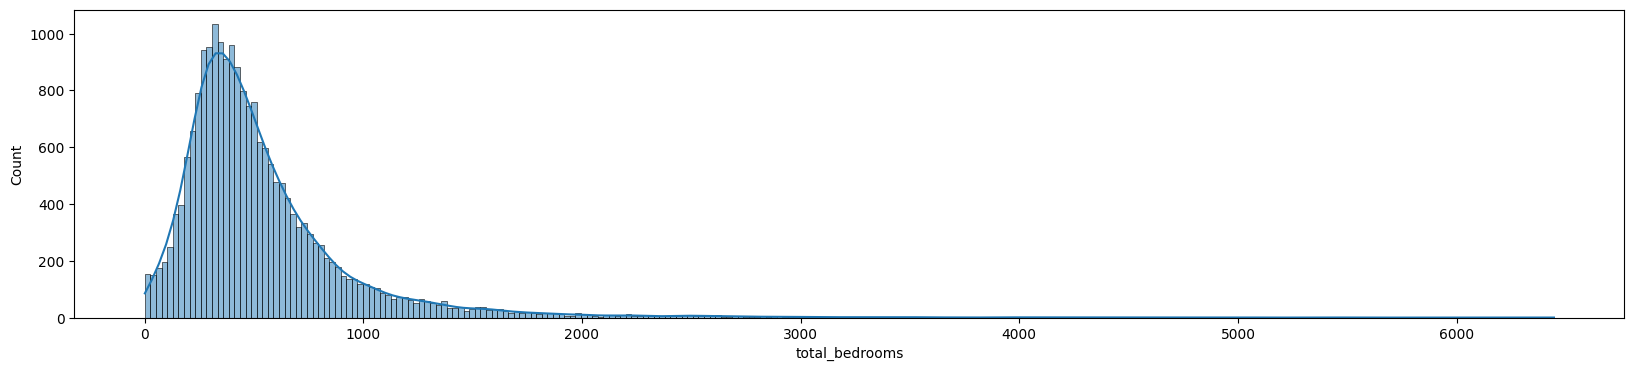

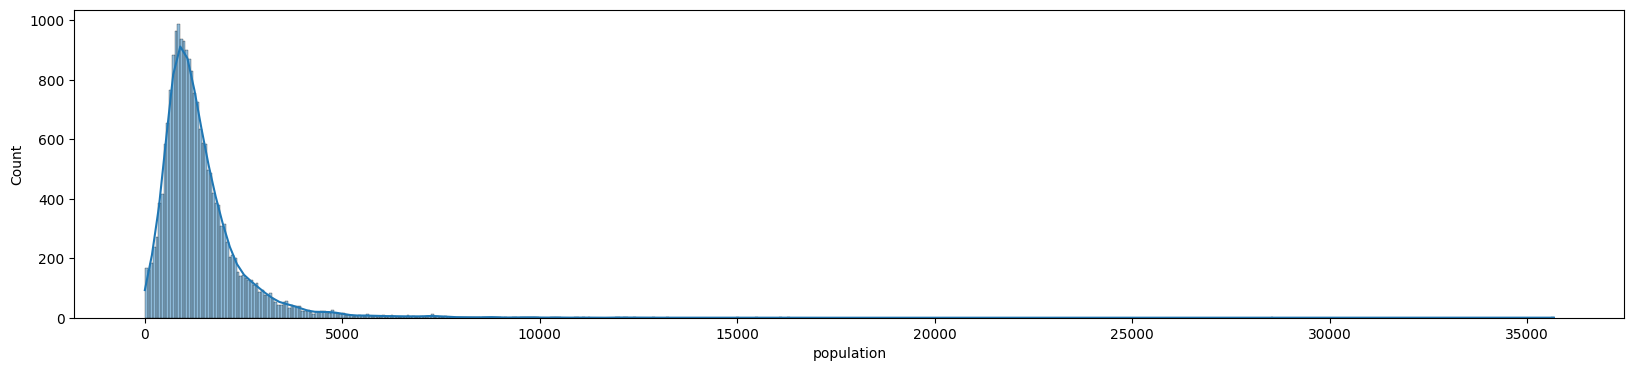

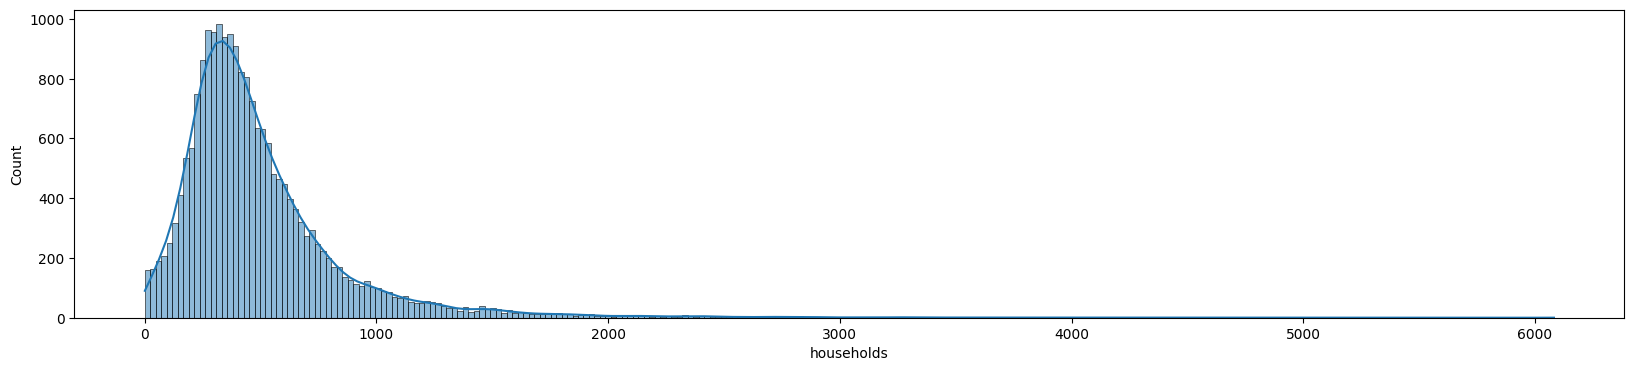

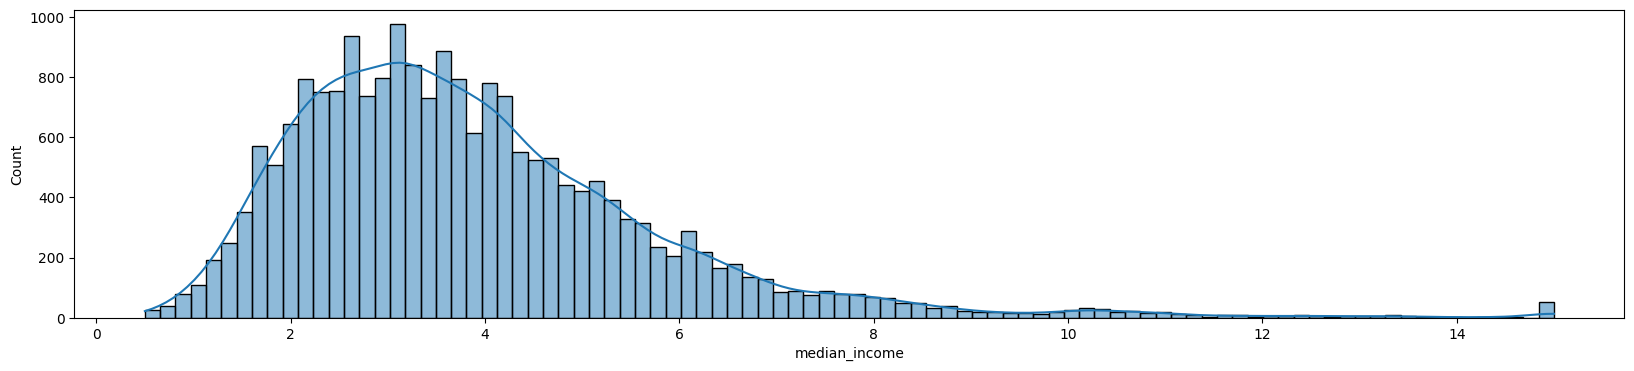

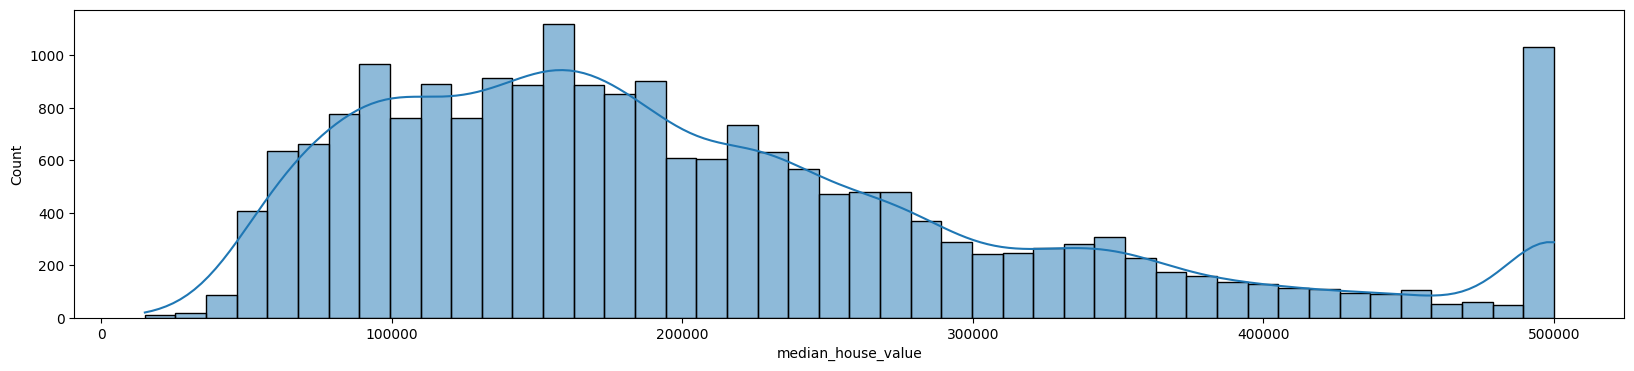

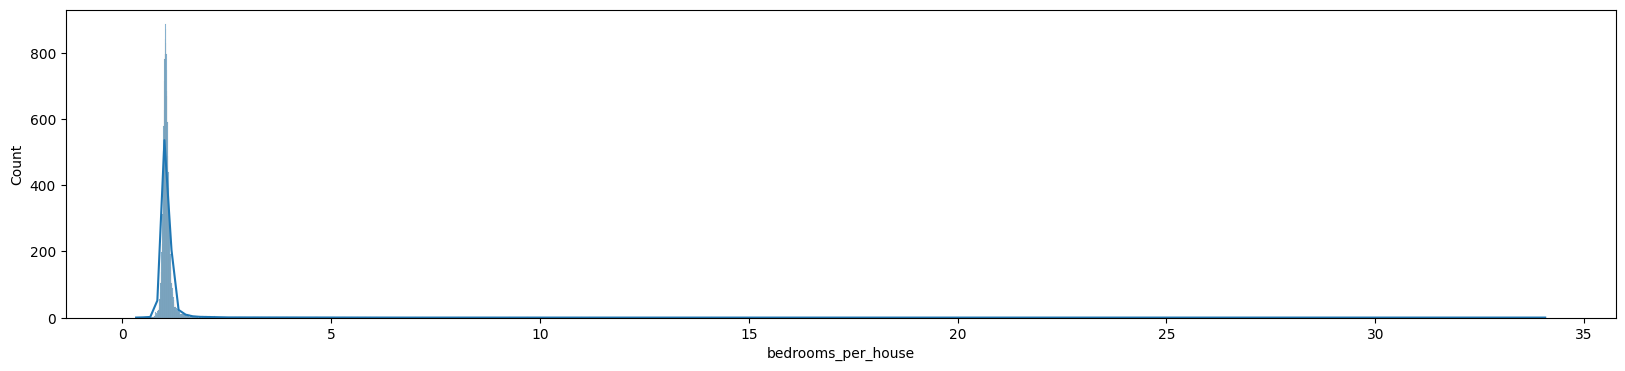

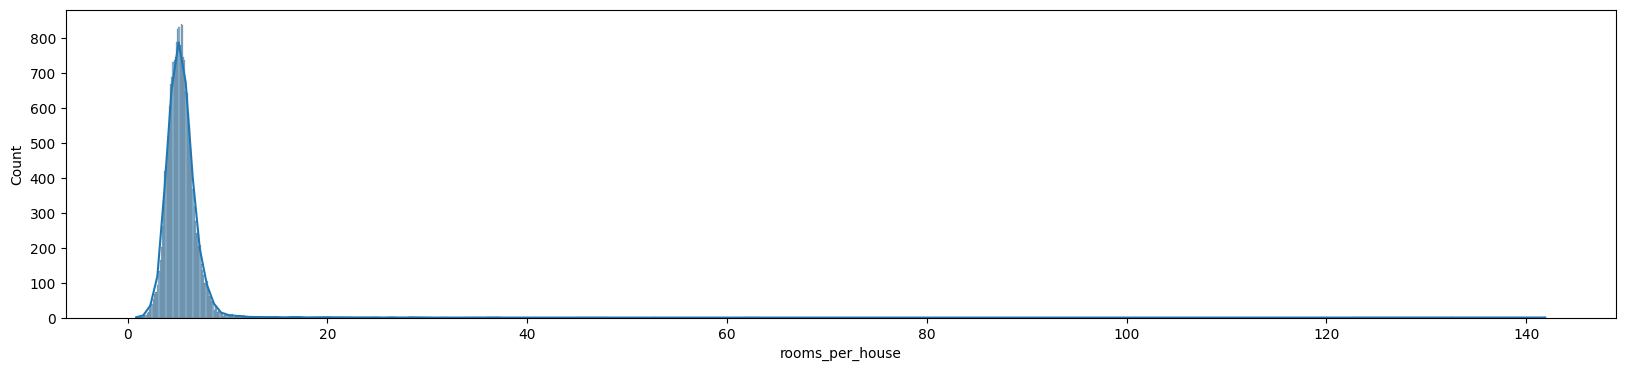

In [40]:
for column in numeric_columns:
    plt.figure(figsize=(20, 4))
    sns.histplot(data=data[column], bins='auto', kde=True, fill=True)
    plt.show()
del column

Es fällt auf, dass die Längen- und Breitengrade zwei Häufungen besitzen.

Bei den Attributen, die mit der Population skalieren (population, total_rooms, total_bedrooms, households) hat man wieder eine stark asymetrische Verteilung mit einem dünnen Peak bei niedrigen Werten und einem sehr langen Tail bei größeren Werten.
Einkommen und Hauswert haben zwar eine ähnliche Tendenz, sind aber nicht so extrem asymetrisch wie die Populationsgrößen. Das Einkommen ist wie weiter oben beschrieben nicht in USD angegeben, sondern vorskaliert.
Das mittlere Alter der Häuser ist mehr oder weniger symmetrisch um die 25 Jahre verteilt.

Die Daten des Median-Hauswertes scheinen mit 50001$ minimiert worden zu sein. Ein ähnliches "Capping" wurde scheinbar auch beim Median-Einkommen und beim Median-Hausalter gemacht. Je nach weiterem Anwendungsfall kann es notwendig sein, diese Daten zu bereinigen.

bedrooms_per_house und rooms_per_house haben ebenfalls einen starken Peak bei niedrigen Werten und einen langen Tail in den oberen Bereichen. Hier ist denkbar dass es lediglich ein paar wenige Ausreißer sind, welche die größeren Werte beschreiben (Gebiete mit fast ausschließlich Hotels o.ä.)


### Aufgabe A-2 e)
> Die Korrelationen der numerischen Merkmale sind zu berechnen und zu visualisieren. Im Anschluss ist auf Basis dieser Ergebnisse zu begründen, warum die Merkmale households, total_rooms, total_bedrooms und bedrooms_per_house aus dem Datensatz entfernt werden können. Das ist im Anschluss durchzuführen. Im Anschluss sind die Korrelationen der verbleibenden Merkmale erneut zu plotten.

Darstellung der Korrelationen

In [41]:
data[numeric_columns].corr()

latitude  longitude  housing_median_age  total_rooms  \
latitude            1.000000  -0.924664            0.011173    -0.036100   
longitude          -0.924664   1.000000           -0.108197     0.044568   
housing_median_age  0.011173  -0.108197            1.000000    -0.361262   
total_rooms        -0.036100   0.044568           -0.361262     1.000000   
total_bedrooms     -0.066127   0.068416           -0.321501     0.930847   
population         -0.108785   0.099773           -0.296244     0.857126   
households         -0.071035   0.055310           -0.302916     0.918484   
median_income      -0.079809  -0.015176           -0.119034     0.198050   
median_house_value -0.144160  -0.045967            0.105623     0.134153   
bedrooms_per_house  0.070192   0.012916           -0.078659     0.030251   
rooms_per_house     0.106389  -0.027540           -0.153277     0.133798   

                    total_bedrooms  population  households  median_income  \
latitude                 -0.066127   -0.108785   -0.071035      -0.079809   
longitude                 0.068416    0.099773    0.055310      -0.015176   
housing_median_age       -0.321501   -0.296244   -0.302916      -0.119034   
total_rooms               0.930847    0.857126    0.918484       0.198050   
total_bedrooms            1.000000    0.877492    0.978765      -0.005590   
population                0.877492    1.000000    0.907222       0.004834   
households                0.978765    0.907222    1.000000       0.013033   
median_income            -0.005590    0.004834    0.013033       1.000000   
median_house_value        0.051377   -0.024650    0.065843       0.688075   
bedrooms_per_house        0.046766   -0.066860   -0.055812      -0.057669   
rooms_per_house           0.002541   -0.072213   -0.080598       0.326895   

                    median_house_value  bedrooms_per_house  rooms_per_house  
latitude                     -0.144160            0.070192         0.106389  
longitude                    -0.045967            0.012916        -0.027540  
housing_median_age            0.105623           -0.078659        -0.153277  
total_rooms                   0.134153            0.030251         0.133798  
total_bedrooms                0.051377            0.046766         0.002541  
population                   -0.024650           -0.066860        -0.072213  
households                    0.065843           -0.055812        -0.080598  
median_income                 0.688075           -0.057669         0.326895  
median_house_value            1.000000           -0.044737         0.151948  
bedrooms_per_house           -0.044737            1.000000         0.849030  
rooms_per_house               0.151948            0.849030         1.000000

Korrelationen via Heatmap

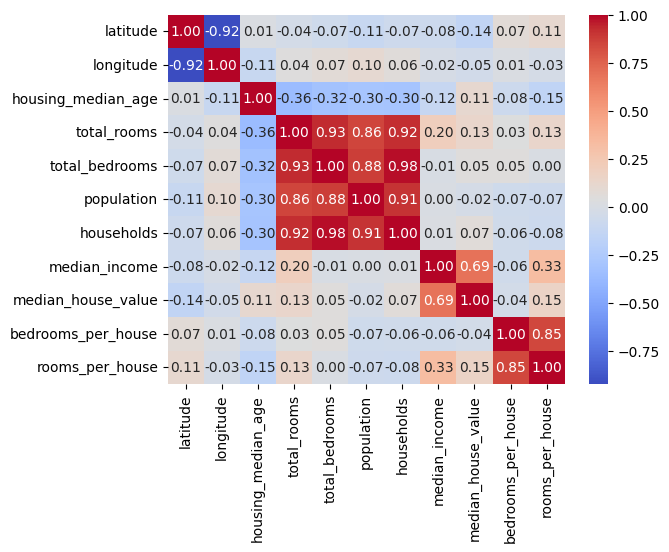

In [42]:
sns.heatmap(data[numeric_columns].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

Es ist auffällig, dass die Werte total_rooms, total_bedrooms, households und population fast komplett linear zueinander sind. Aus diesem Grund können households, total_rooms und total_bedrooms aus dem Datensatz entfernt werden, da ihre Aussagekraft fast komplett durch population abgedeckt ist.

Ebenso sind bedrooms_per_house und rooms_per_house dermaßen stark korreliert dass auf bedrooms_per_house verzichtet werden kann, da dessen Aussagekraft durch rooms_per_house abgedeckt ist.

Entfernen von households, total_rooms, total_bedrooms und bedrooms_per_house:

In [43]:
columns_to_drop = [column for column in ['households', 'total_rooms', 'total_bedrooms','bedrooms_per_house'] if column in data ]
data.drop(columns=columns_to_drop, inplace=True)
for column in columns_to_drop:
  numeric_columns.remove(column)
del column
del columns_to_drop

Korrelationen mit reduzierten Daten

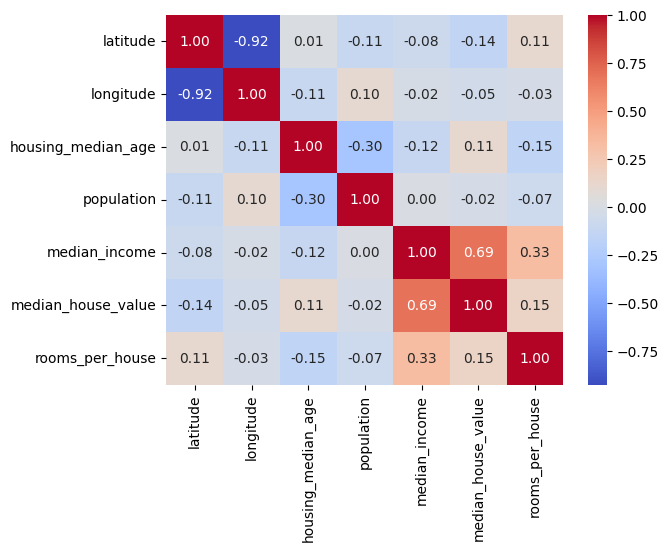

In [44]:
sns.heatmap(data[numeric_columns].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

## Aufgabe A-3: Hauspreise sowie regionale Strukturen untersuchen und visualisieren

### Aufgabe A-3 a)
> Visualisieren Sie den Datensatz mit Hilfe der Karte von Kalifornien (siehe: https://github.com/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb) und den folgenden Merkmalen:
>• median_house_value
>• housing_median_age
>• median_income
>Die Ergebnisse sind zu kommentieren und zu interpretieren.

Bild von Californien und Code für den Plot auf der Karte aus dem Beispielnotebook in der Aufgabenstellung übernommen bzw. daraus angepasst.

In [45]:
california_img_path = folder_path+'california.png'
cal_img = plt.imread(california_img_path)


---

Plot für den Median Wert eines Hauses (median_house_value)


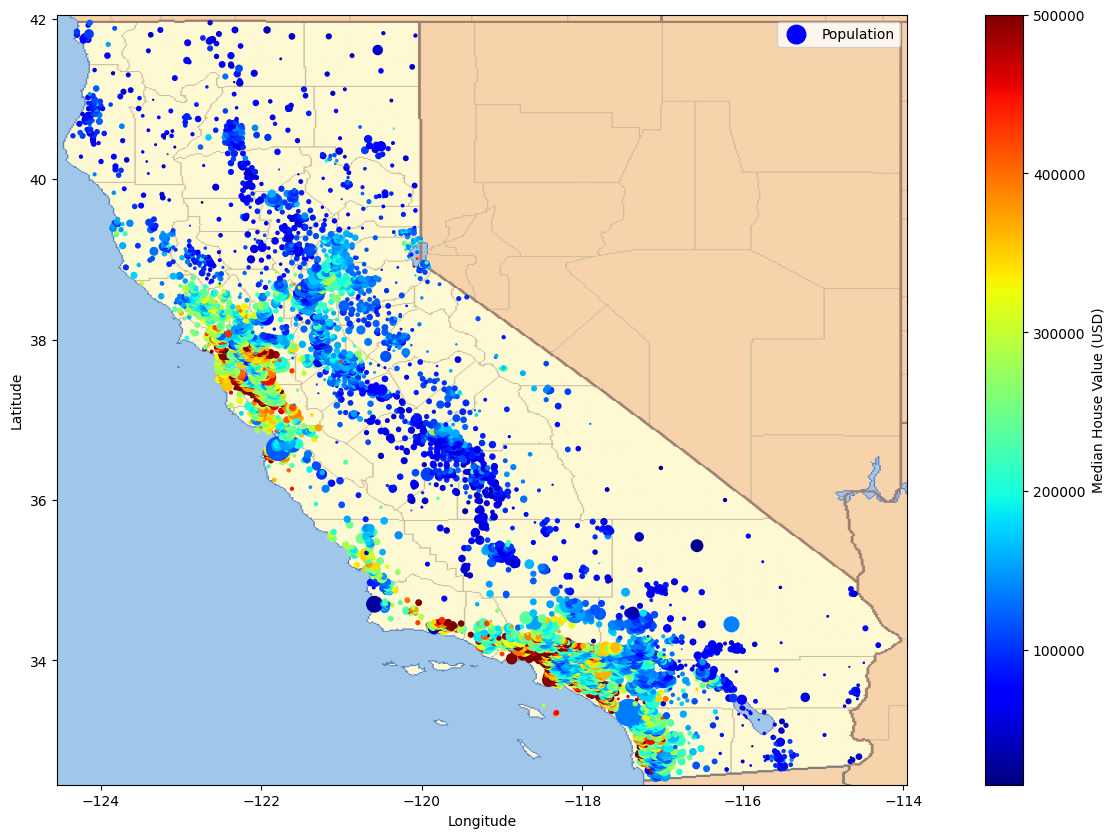

In [46]:
plotcali(data, column="median_house_value", label="Median House Value (USD)", cal_img=cal_img)

Man sieht direkt die Aggregation an hohen Hauspreisen an den Ballungszentren rund um
*   San Franscisco, San Jose und der generellen Bay-Area (ca. 38 Latitude, -122 Longitude)
*   Los Angeles (ca. 34 Lat, -118 Long) und dem größeren Umkreis an der Küste mit Santa Barbara und San Diego

Generell besitzen hauptsächlich die Küstengebiete hohe Hauspreise. Die Hauspreise im Inland sind deutlich niedriger. Ausnahmen bilden große Städte wie Sacramento und dem Gebiet rund um Lake Tahoe an der Grenze zu Nevada.


---



Plot für das Medianalter eines Hauses (housing_median_age)



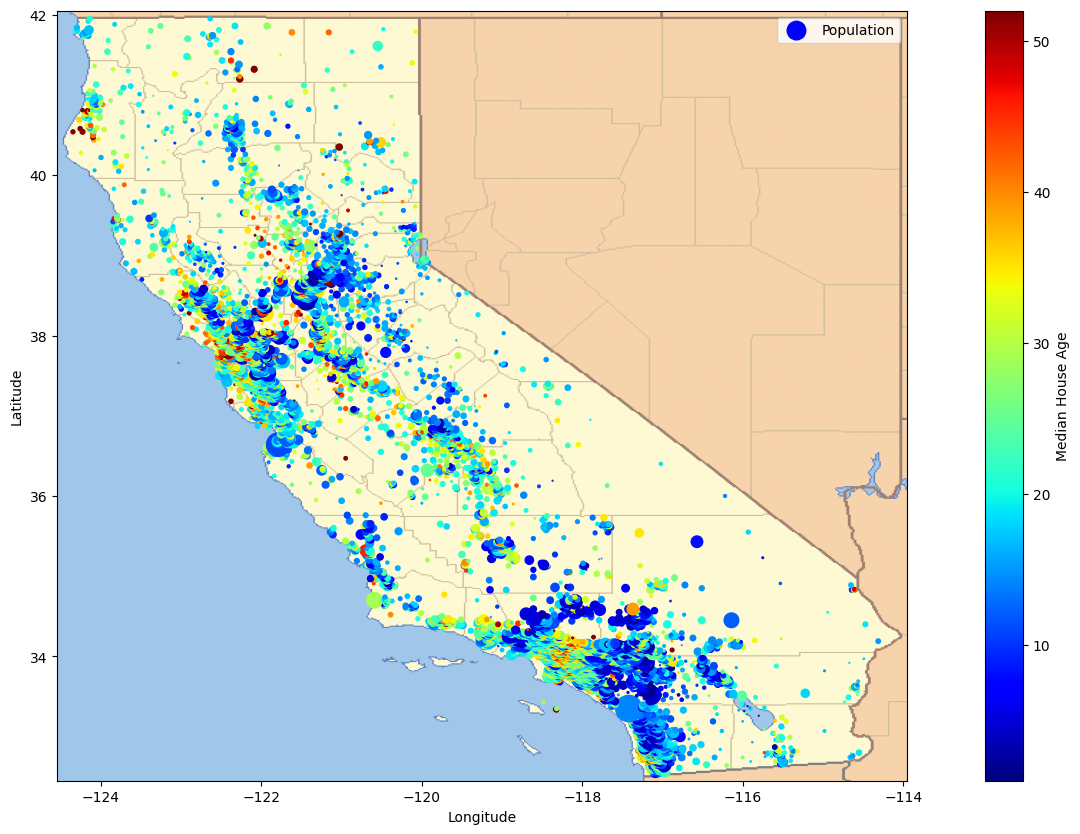

In [47]:
plotcali(data, column="housing_median_age", label="Median House Age", cal_img=cal_img)

Die Medianalter der Häuser sind (offensichtlich) gleichmäßiger verteilt als die Hauswerte. Interessant sind vor allem die Gebiete mit hoher Population und niedrigem Hausalter, die auf eine hohe Rate von Neubauten schließen lassen. Das ist insbesondere an einem Gürtel rund um Los Angeles und in Sacramento zu beobachen. Die schon lange bestehenden großen Stadtzentren haben naturgemäß auch ein hohes Hausalter.


---



Plot für das Medianeinkommen (median_income)


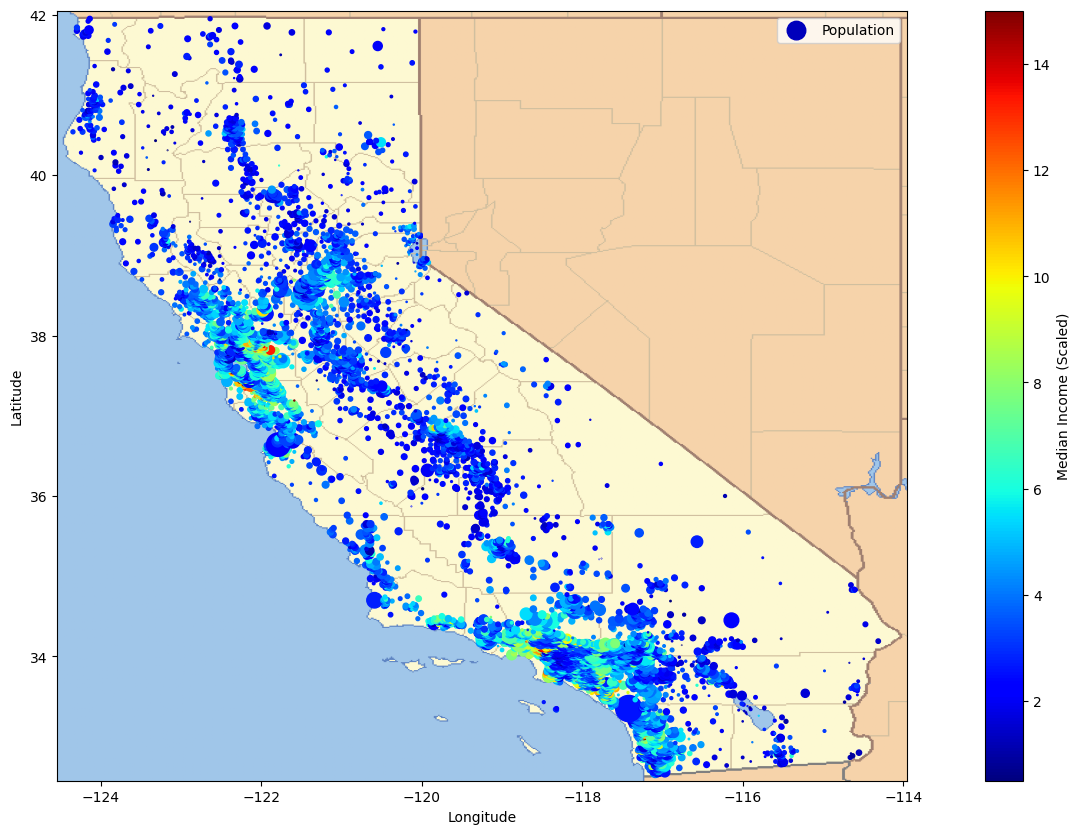

In [48]:
plotcali(data, column="median_income", label="Median Income (Scaled)",cal_img=cal_img)

Wie man erwarten könnte decken sich Gebiete mit hohem Medianeinkommen und Gebiete mit hohen Hauspreisen.

In [49]:
del cal_img
del california_img_path

### Aufgabe A-3 b)
>Betrachtet werden soll die Abhängigkeit des Hauspreises von den verfügbaren numerischen Merkmalen. Dazu ist eine geeignete Visualisierungsmöglichkeit zu wählen, auszuführen und zu interpretieren.

Mit einer Heatmap wurden in den vorherigen Aufgabenteilen bereits die Korrelationen ermittelt.
Via Scatterplots werden nun alle numerischen Merkmale dem Median-Hauswert gegenübergestellt.

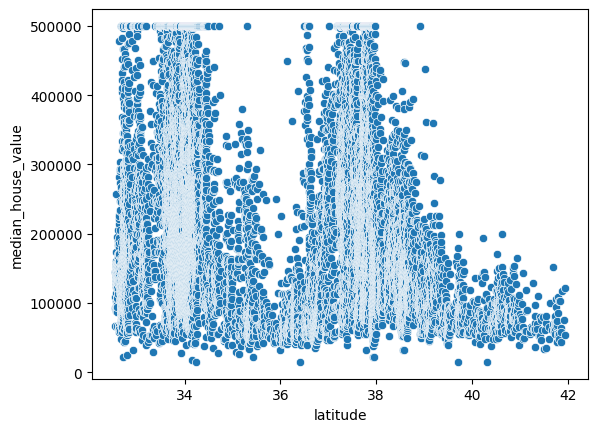

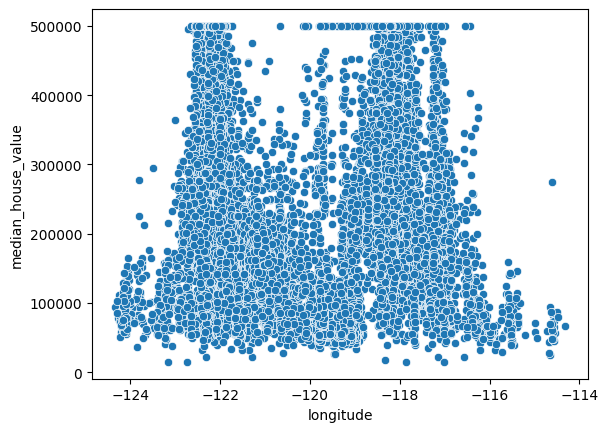

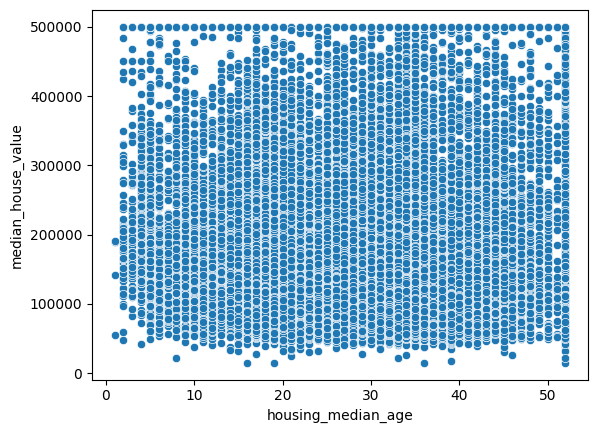

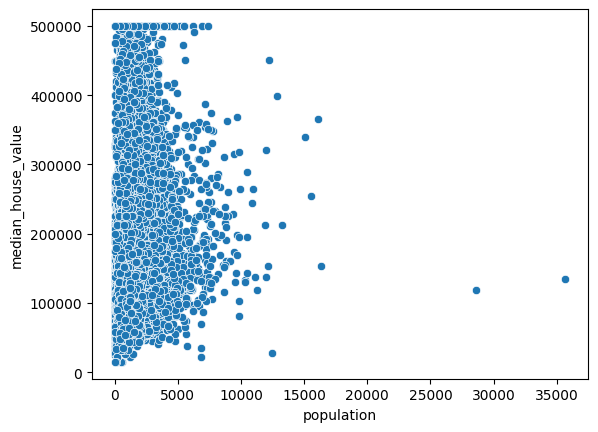

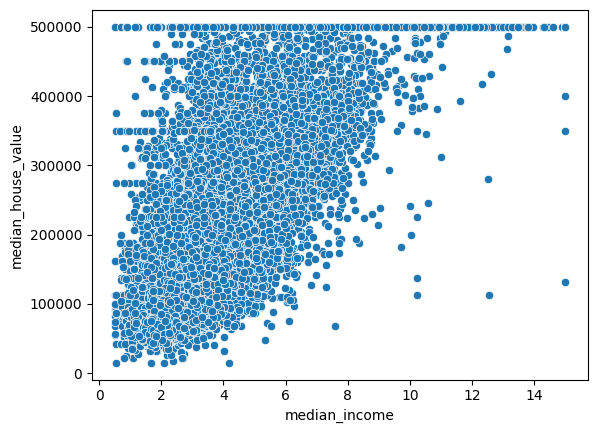

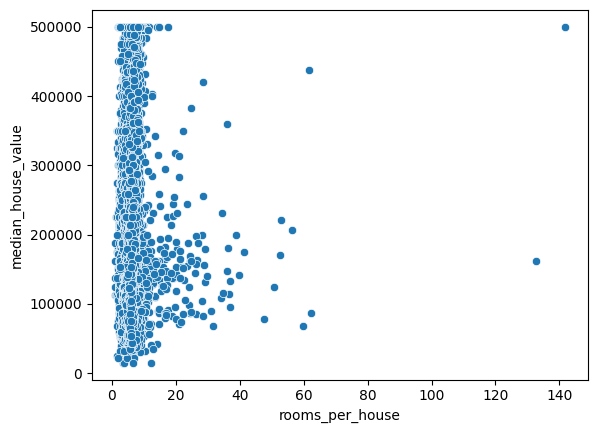

In [50]:
for column in [column for column in numeric_columns if column != 'median_house_value']:
    sns.scatterplot(x=column, y='median_house_value', data=data)
    plt.show()
del column

Latitude und Longitude zeigen hier klare Spitzen -- dies ist aber nicht überraschend, da wir den Zusammenhang zwischen Hauspreisen und den Ballungszentren der Küste bereits in der vorherigen Aufgabe gesehen haben.
Das Hausalter scheint ziemlich gleichverteilt zu sein und besitzt alleine nur eine geringe Aussagekraft über den Hauswert.
Aus dem Zusammenhang mit der Population lässt sich auch keine lineare Abhängigkeit herauslesen.
Das Medianeinkommen scheint der stärkste Prädiktor für den Medianhauswert zu sein, hier gibt es eine klare Korrelation.
Die Räume pro Haus scheinen wenn dann nur einen sehr schwachen linearen Zusammenhang mit den Hauswerten zu besitzen.

## Aufgabe A-4: Erste Hauspreisprognosemodelle auf Basis der numerischen Features
>Ziel dieses Abschnitts ist die Erstellung erster Modelle basierend rein auf den numerischen Merkmalen.

### Aufgabe A-4 a)
>Es ist anzugeben, wie die Fehler- bzw. Gütemaße Root Mean Squared Error (RMSE) bzw. R² eines Prognoseverfahrens bei einem Regressionsproblem berechnet werden. Im Anschluss soll der mathematische Zusammenhang zwischen den beiden Größen aufgezeigt werden. Dabei soll einerseits darauf eingegangen werden, welche Rolle ein naives Nullmodell einnimmt, das stets den Mittelwert des Zielmerkmals ausgibt, und andererseits begründet werden, wieso der RMSE bei steigendem R² sinkt und bei fallendem R² steigt

In der üblichen Notation für Regressionsprobleme mit Zielgröße $y$, den tatsächlichen Zielwerten $(y_1,...,y_n)$ und den vorhergesagten Werten $(\hat{y}_1,...,\hat{y}_n)$ sind
$$\text{RMSE} = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}$$
und
$$R^2 = 1 - \frac{\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}{\sum_{i=1}^{n}(y_i - \bar{y})^2}$$
wobei $\bar{y}$ der Mittelwert der tatsächlichen Zielgrößen ist.

Mit
$$\text{RMST}=\sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \bar{y})^2}$$
kann man $R^2$ auch darstellen als
$$R^2 = 1 - \left(\frac{\text{RMSE}}{\text{RMST}}\right)^2$$


RMSE stellt ein Fehlermaß dar und bestraft die Abweichungen der Vorhersagen in absoluter Höhe. Es berücksichtigt die vorhandene Varianz der Zielgrößen nicht, sodass es für die Bewertung des Fehlers keinen Unterschied macht, ob der Datensatz eine hohe Varianz aufweist. EIn naives Nullmodell mit Schätzwert $\bar{y}$ hätte damit einen Fehlerwert von
$$\text{RMST}=\sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \bar{y})^2}$$
erhalten. Der Fehlerwert des Nullmodells steigt also mit der Varianz der Stichprobe.

$R^2$ hingegen ist ein Gütemaß und berücksichtigt nur das Verhältnis zwischen RMSE und RMST. Es sagt also aus, wie gut der RMSE im Verhältnis zum RMST minimiert werden kann. Ds zeigt sich auch beim naiven Nullmodell mit Schätzwert $\bar{y}$, denn dann wäre $\text{RMSE}=\text{RMST}$ und somit $R^2=0$. Die Vorhersage kann also gegenüber dem RMST nicht verbessert werden. Anders gesagt: $R^2$ gibt an, wie sehr die Vorhersage unter Nutzung der erklärenden Variablen gegenüber dem trivialen Modell verbessert werden kann.

Wegen $\text{RMSE,RMST}\geq0$ und weil RMST für eine gegebene Stichprobe konstant ist folgt aus der Darstellung
$$R^2 + \left(\frac{\text{RMSE}}{\text{RMST}}\right)^2 = 1$$
trivialerweise, dass $R^2$ streng monoton fallend in $RMSE$ ist und umgekehrt $RMSE$ bei steigendem $R^2$ fallen muss.


### Aufgabe A-4 b)
>Der Datensatz ist in einen Trainingsteil (konkret: x_train & y_train) und einen Validierungsteil (konkret: x_val & y_val) zu splitten. Dabei ist die Spalte sample zu berücksichtigen: Zeilen mit dem Eintrag „A“ sollten für das Training und Zeilen mit dem Eintrag „B“ für die Validierung verwendet werden. Die entsprechend benötigten Datenstrukturen sind anzulegen.

Extraktion der Trainings- und Validierungsdaten

In [51]:
datanum = data[numeric_columns]
datanum_train = datanum[data['sample'] == 'A']
x_train = datanum_train.drop(['median_house_value'], axis=1)
y_train = datanum_train['median_house_value']
del datanum_train

datanum_val = datanum[data['sample'] == 'B']
x_val = datanum_val.drop(['median_house_value'], axis=1)
y_val = datanum_val['median_house_value']
del datanum_val

del datanum

### Aufgabe A-4 c)
>Für die Ergebnisse dieser und der nachfolgenden Modelle in Teil A ist eine geeignete Datenstruktur anzulegen. Diese soll für jedes Modell den Wert für den Root Mean Squared Error (RMSE) enthalten.

Die RMSEs pro Modell werden in einem Dictionary gespeichert.

In [52]:
display(rmses)
type(rmses)

{}

dict

### Aufgabe A-4 d)
>Zu verwenden ist ein einfaches lineares Modell ohne besondere Anpassungen. Ein Ergebnisbericht ist auszugeben und die Ergebniswerte sind zu speichern und zu kommentieren.

Fit einer linearen Regression mit Default-Einstellungen

In [53]:
model_LR = sklearn.linear_model.LinearRegression()
model_LR.fit(x_train, y_train)
y_pred_LR = model_LR.predict(x_val)

Ergebnisse:

In [54]:
print_results(y_val, y_pred_LR)
rmses['Numeric Linear'] = rmse(y_val, y_pred_LR)
del y_pred_LR

RMSE: 74508.93978488311
RMST (zum Vergleich): 114008.14636807823
R^2: 0.5728848285783494


In [55]:
print("Coefficients:")
print("Intercept:",model_LR.intercept_)
for i, coeff in enumerate(model_LR.coef_):
    print("Feature",x_train.columns[i],":",coeff)
del i
del coeff

Coefficients:
Intercept: -3885263.920764031
Feature latitude : -45738.094302606194
Feature longitude : -46388.941936147916
Feature housing_median_age : 916.6476488153728
Feature population : -1.0334605170280498
Feature median_income : 36866.79377940719
Feature rooms_per_house : 1322.6461721243304


Das lineare Modell auf numerischen Werten hat zwar eine gewisse Vorhersagekraft, hat aber mit einem $R^2$ von unter 0.6 trotzdem noch viel Verbesserungspotenzial.

In [56]:
del model_LR

### Aufgabe A-4 e)
>Analog zu Teilaufgabe d) ist CatBoost mit Standardparametern zu verwenden, wobei die Ausgabe der einzelnen Iterationen sowohl hier als auch in nachfolgenden Aufgaben zu unterdrücken ist. Ein Ergebnisbericht samt allen verwendeten Parametern ist auszugeben und die Ergebniswerte sind zu speichern. Zusätzlich ist die Feature Importance auszugeben und zusammen mit den Ergebniswerten zu kommentieren.

Fit eines CatBoost mit Default-Einstellungen

In [57]:
model_CB = catboost.CatBoostRegressor(verbose=False)
model_CB.fit(x_train, y_train)
y_pred_CB = model_CB.predict(x_val)

Ergebnisse:

In [58]:
print_results(y_val, y_pred_CB)
rmses['Numeric Catboost'] = rmse(y_val, y_pred_CB)
del y_pred_CB

RMSE: 48912.79736396997
RMST (zum Vergleich): 114008.14636807823
R^2: 0.8159341447366703


Feature importance:

In [59]:
print("Feature Importances:")
for i, importance in enumerate(model_CB.feature_importances_):
    print("Feature",x_train.columns[i],":",importance)
del i, importance

Feature Importances:
Feature latitude : 29.144908189740867
Feature longitude : 28.9540488643117
Feature housing_median_age : 5.8741119369703245
Feature population : 1.7413334210991498
Feature median_income : 29.724008478316748
Feature rooms_per_house : 4.561589109561224


Hyperparameter:

In [60]:
model_CB.get_params()

{'loss_function': 'RMSE', 'verbose': False}

Verwendete Features

In [61]:
model_CB.feature_names_

['latitude',
 'longitude',
 'housing_median_age',
 'population',
 'median_income',
 'rooms_per_house']

CatBoost konnte gegenüber der linearen Regression ein deutlich besseres Ergebnis erzeilen. RMSE ist deutlich gesunken und $R^2$ gestiegen. Anhand der Feature Importance sieht man, dass vor allem der Ort und das Median-Einkommen besonders in Betracht gezogen werden, was unseren bisherigen Beobachtungen und Vermutungen entspricht.

In [62]:
del model_CB
del x_train
del x_val
del y_train
del y_val

## Aufgabe A5: Kategorielle Merkmale analysieren und aufbereiten
> Hinweis: Der Datensatz ist für diesen Abschnitt (hinsichtlich der Features) auf die kategoriellen Merkmale zu beschränken.

### Aufgabe A-5 a)
>Zu erstellen ist eine grafische prozentuale Häufigkeitsverteilung für die nominalen Merkmale ocean_proximity und county_name. Die Ergebnisse sind zu erläutern.



Darstellung der relativen Häufigkeiten der kategoriellen Daten

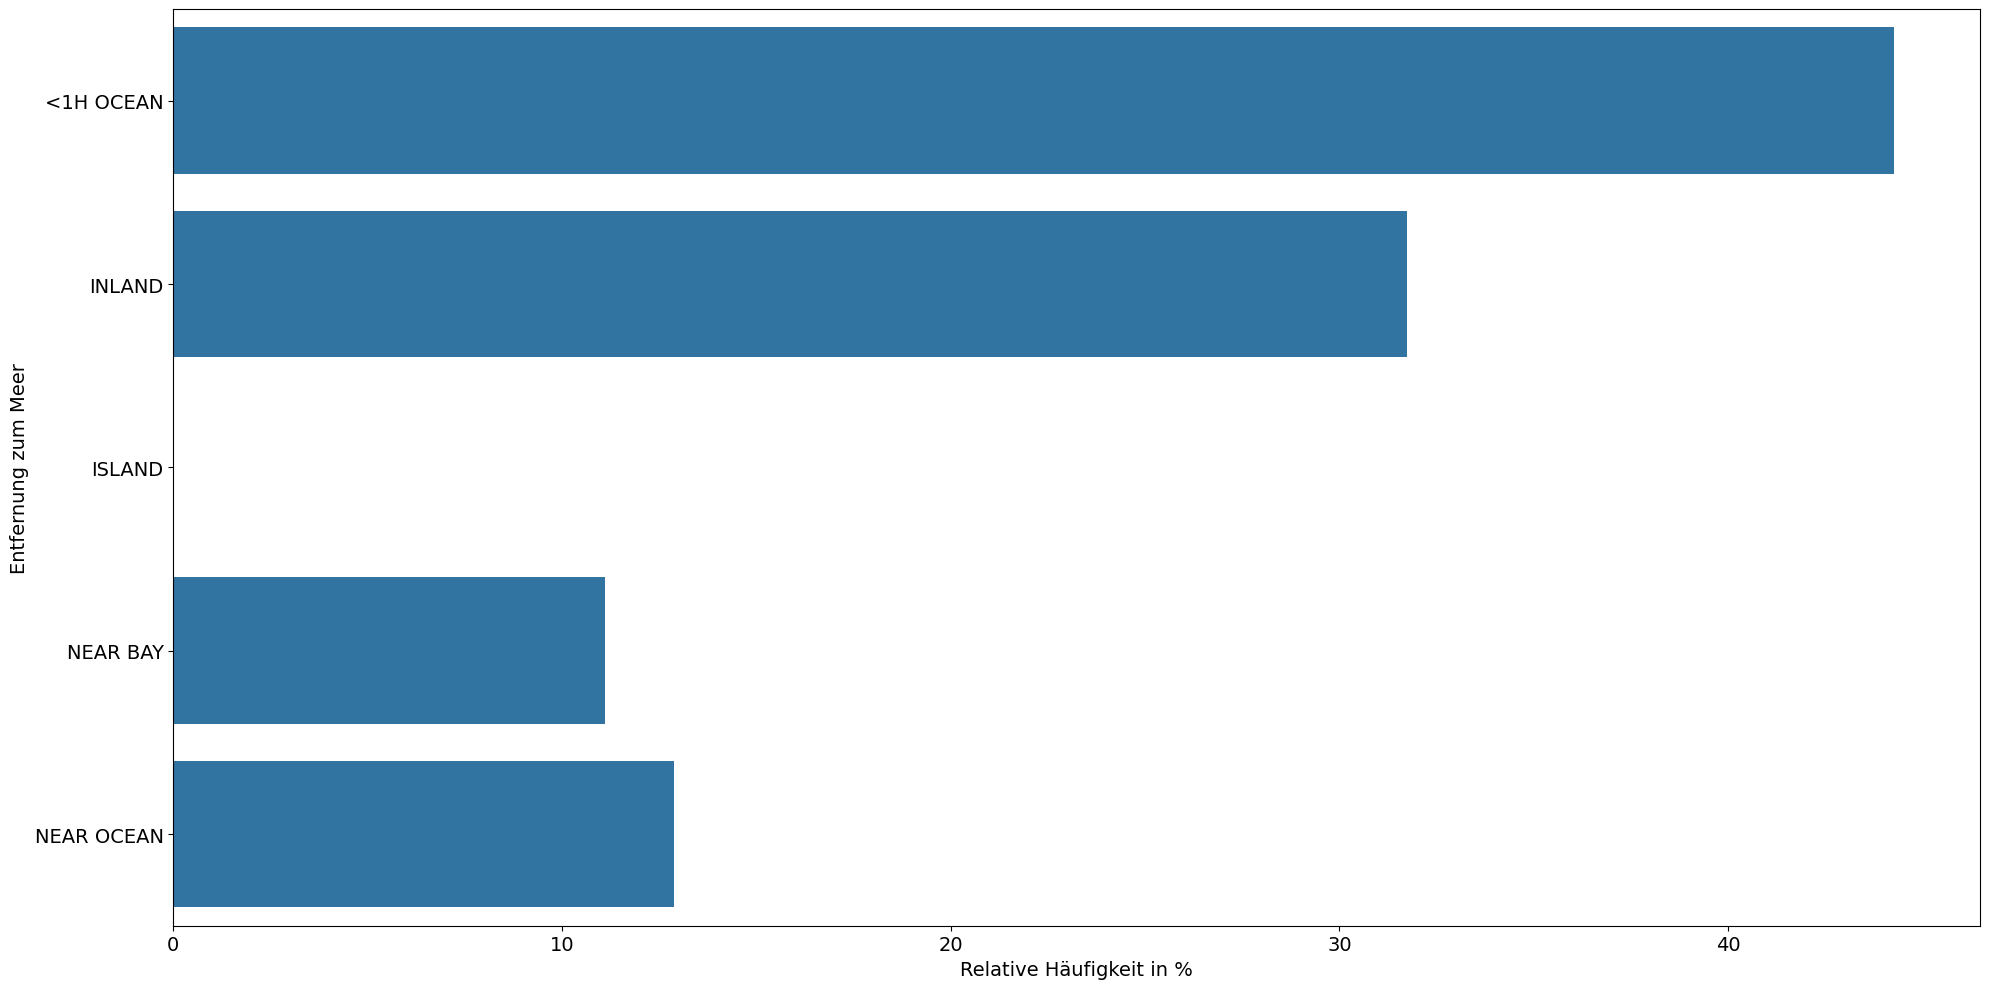

In [63]:
plotRelFreq(data,'ocean_proximity', 'Entfernung zum Meer', 10)

Es gibt kaum Daten zu Häusern auf Inseln. Über 65% der Daten betreffen Häuser mit weniger als einer Stunde zum Meer, davon ca. 11% in der Nähe von Buchten und ca. 13% direkt in der Nähe des Ozeans.

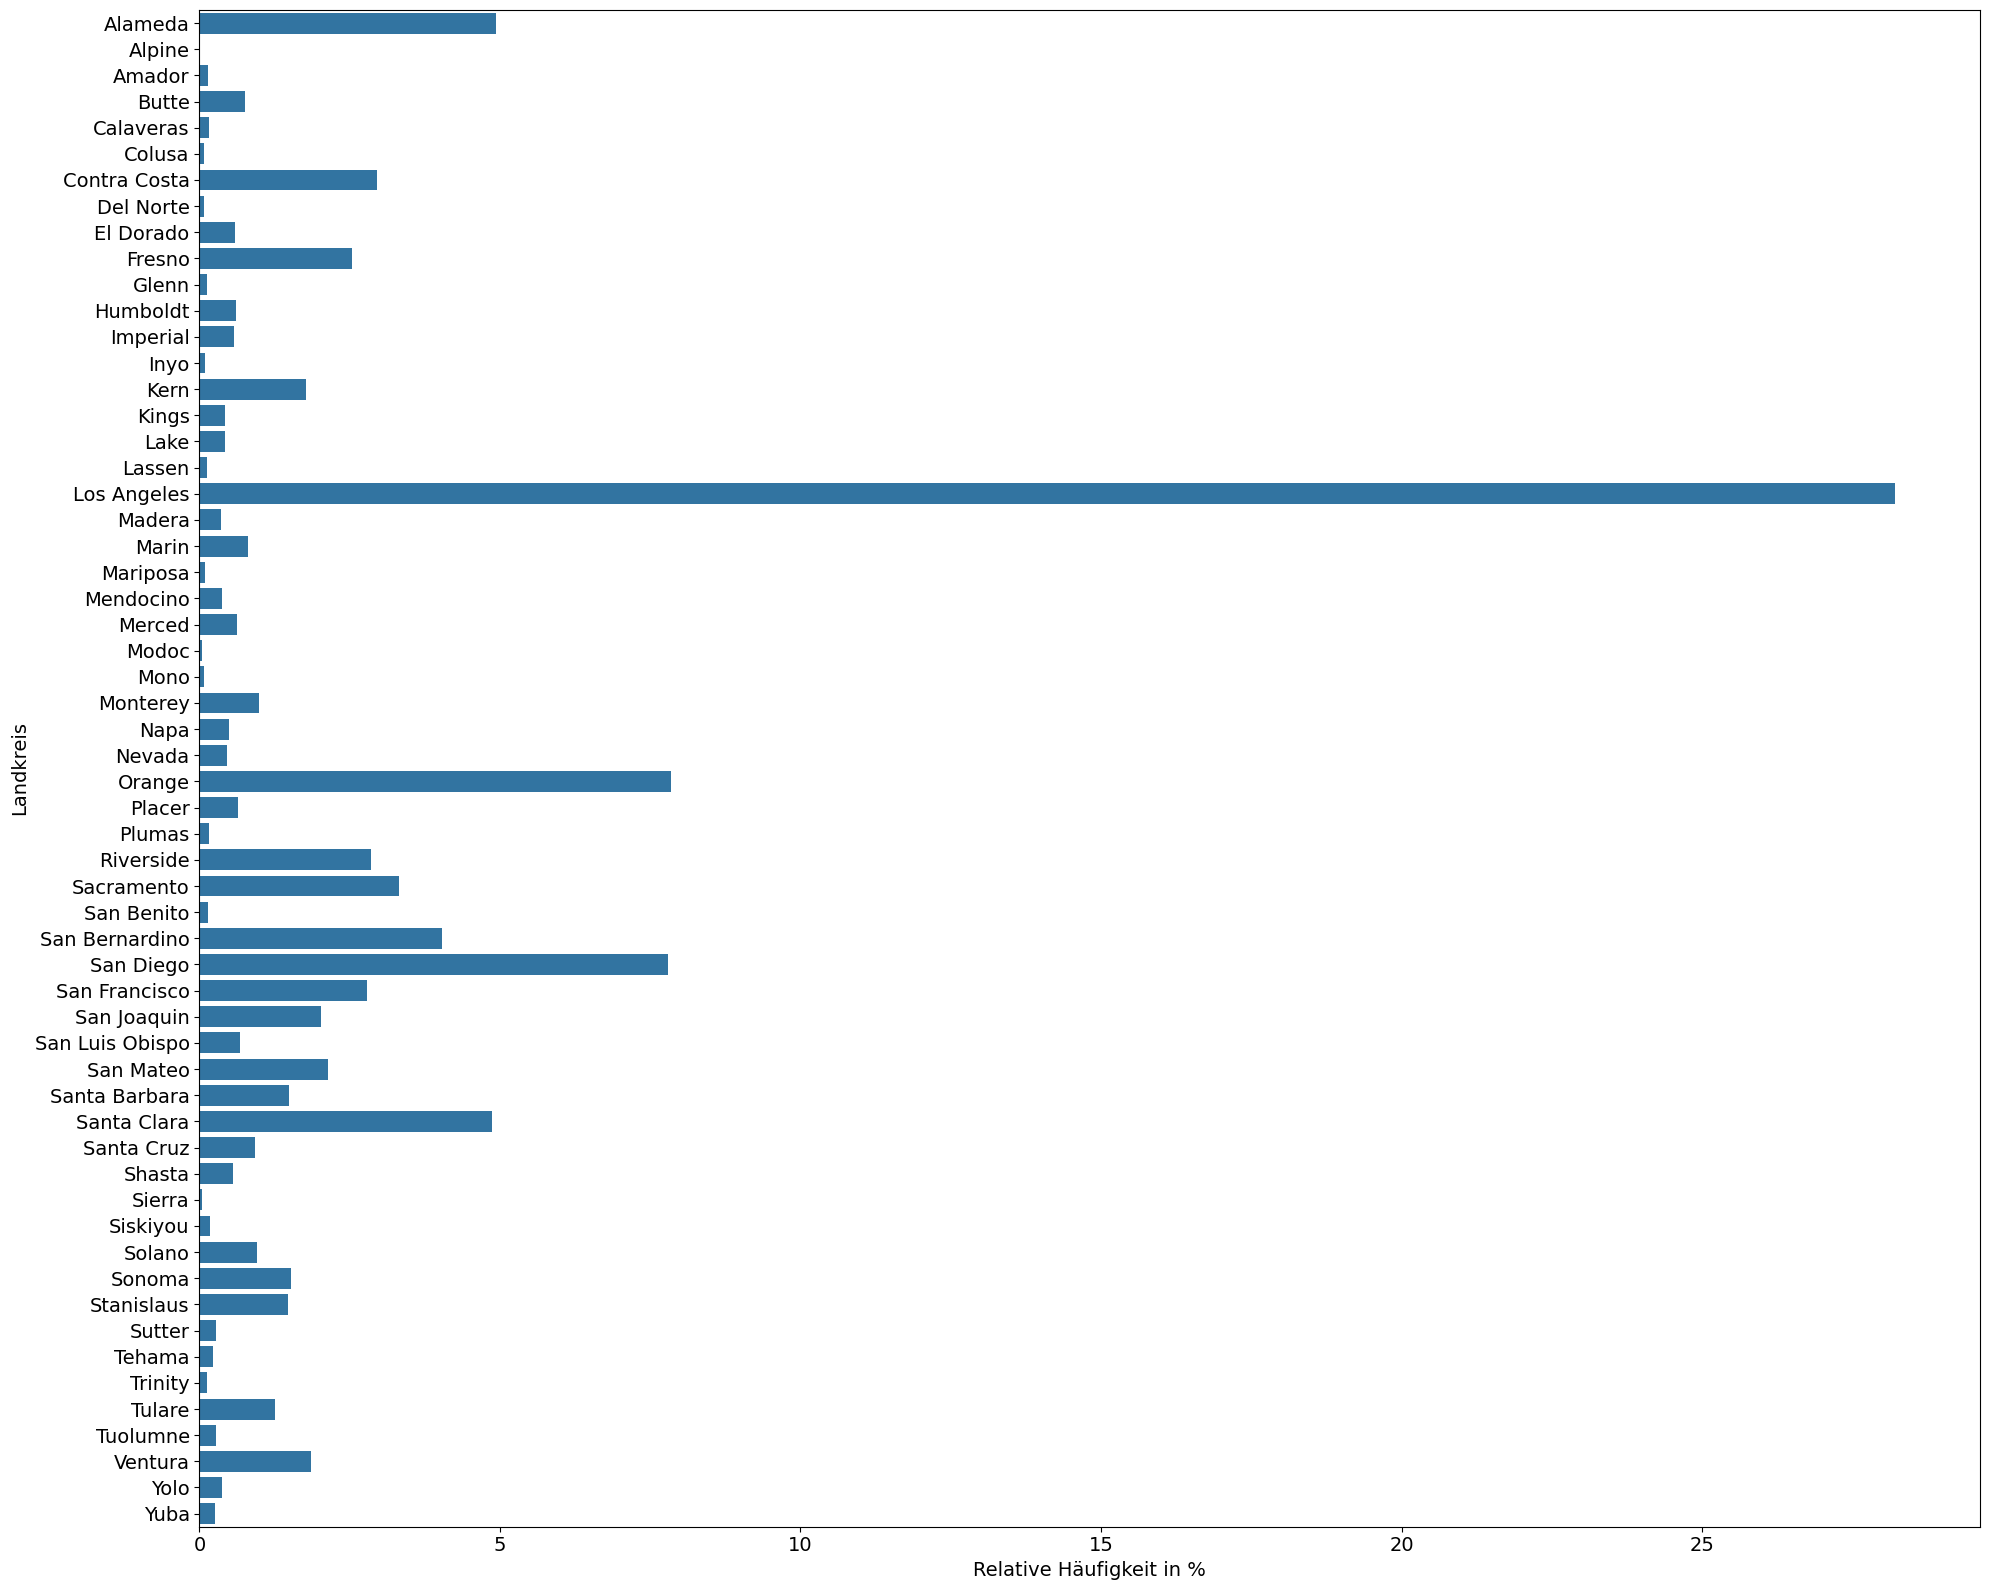

In [64]:
plotRelFreq(data,'county_name', 'Landkreis', 16)

In [65]:
print("Los Angeles Population:",data[data['county_name']=='Los Angeles']['population'].sum())
print("San Francisco Population:", data[data['county_name']=='San Francisco']['population'].sum())

Los Angeles Population: 8779165
San Francisco Population: 702492


Auffällig ist wie häufig Los Angeles im Datensatz vertreten ist (ca. 28%). Das ist bei der hohen Population allerdings nicht überraschend. Die große Metropole San Francisco ist im Vergelich weit weniger vertreten. Der Grund dafür ist jedoch, dass sich die Bevölkerung der Region um San Francisco weiterflächiger auf mehrere Landkreise erstreckt, dazu lässt sich z,B. Santa Clara zählen, welches selbst mehr Datensätze als San Francisco besitzt.

### Aufgabe A-5 b)
>Der Einfluss der nominalen Merkmale auf die Hauspreise ist mit geeigneten Mitteln zu visualisieren. Auffälligkeiten sind zu kommentieren.

Darstellung der Auswirkungen der kategoriellen Merkmale auf den Median-Hauspreis mittels Violinplot



Hier: Violinplot in Abhängigkeit zu Ozeannähe

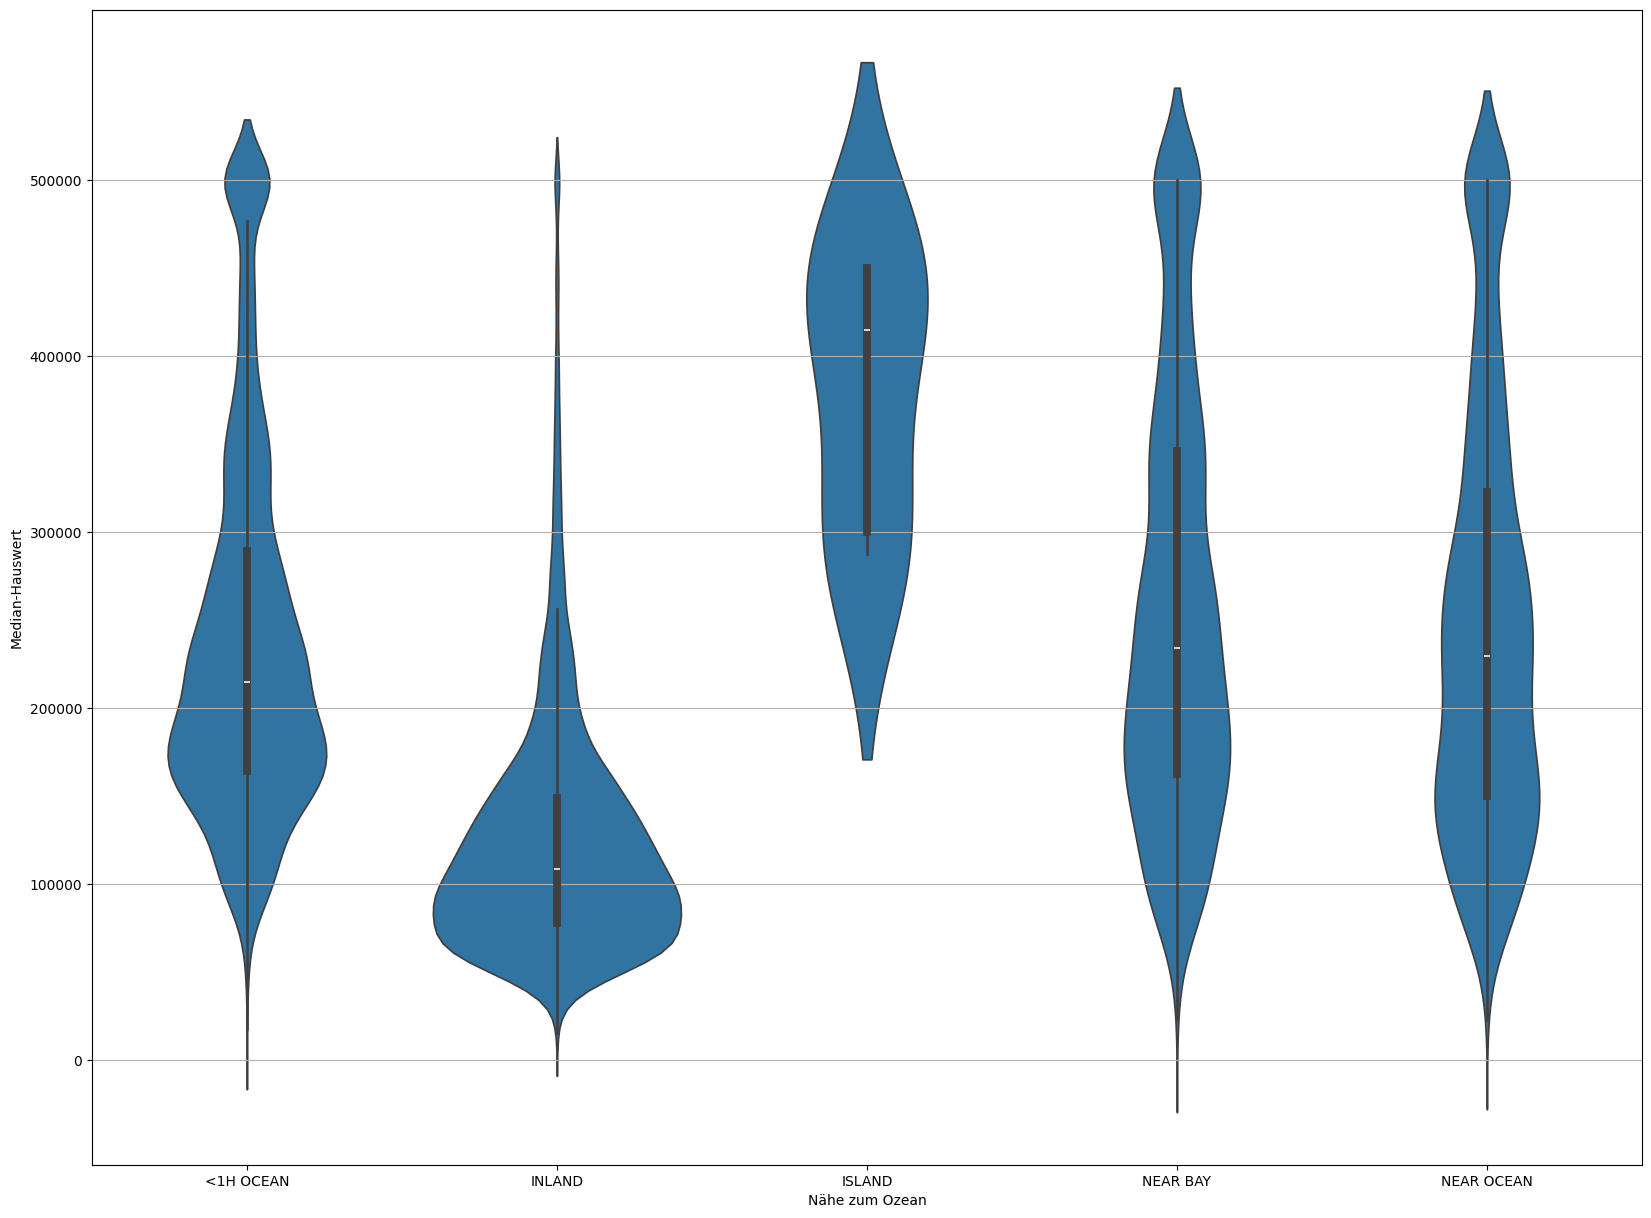

In [66]:
plt.figure(figsize=(20, 15))
sns.violinplot(x='ocean_proximity', y='median_house_value', data=data)
plt.xlabel('Nähe zum Ozean')
plt.ylabel('Median-Hauswert')
plt.grid(axis='y')
plt.show()

Häuser auf Inseln haben einen durchschnittlich sehr hohen Wert. Häuser in der Nähe der Bucht und dem Ozean haben eine breite Spanne an Werten, mit Tendenz zu hohem Wert. Bei Häusern im Inland ist die Varianz geringer, mit den niedrigsten Werten der Kategorien.



Violinplot in Abhängigkeit zum Landkreis

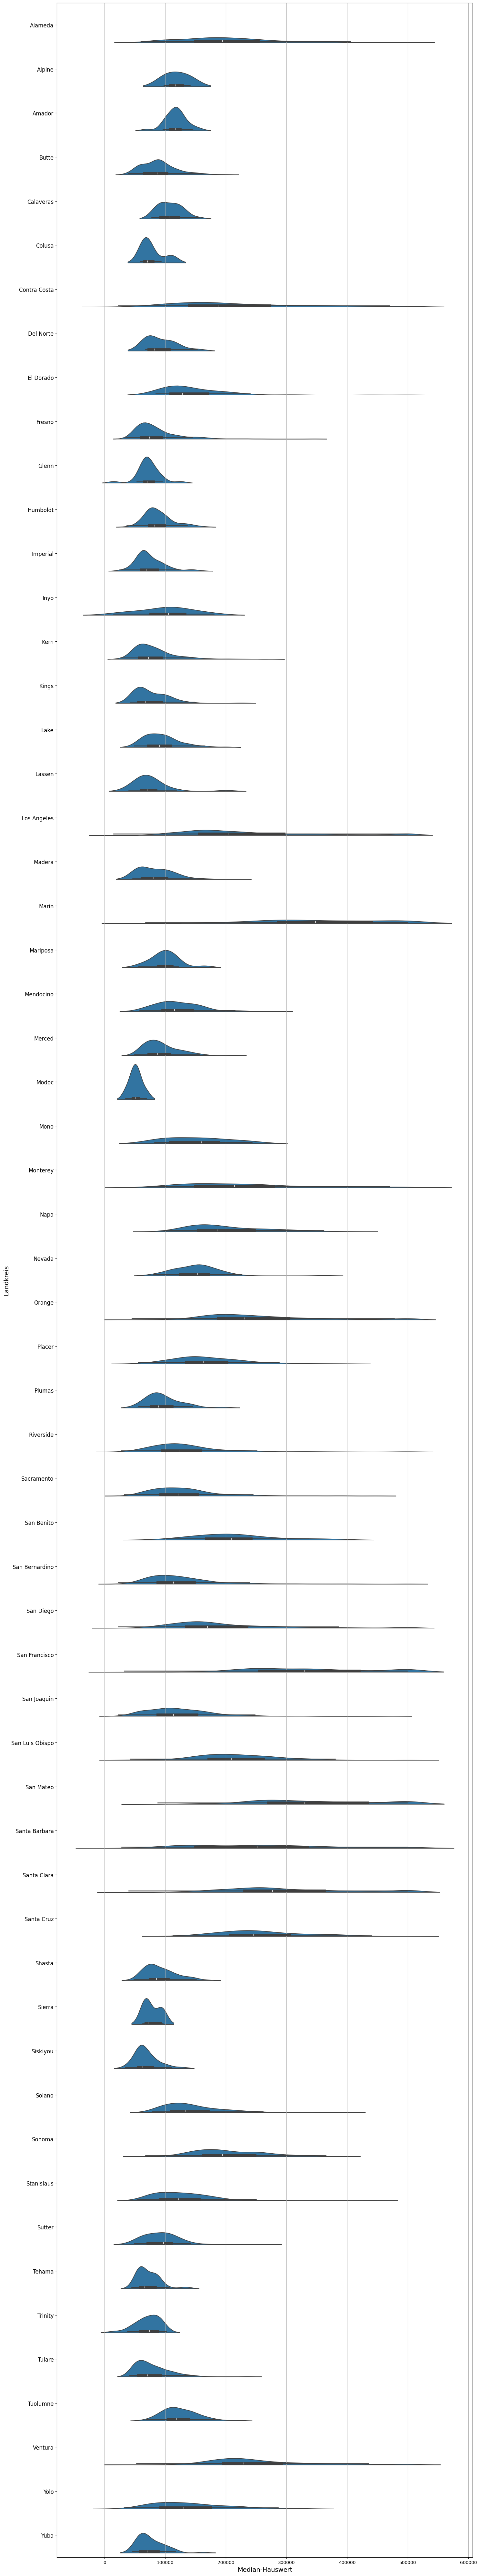

In [67]:
plt.figure(figsize=(15, 80))
sns.violinplot(x='median_house_value', y='county_name', data=data,orient='h',split=True)
plt.ylabel('Landkreis', fontsize=14)
plt.xlabel('Median-Hauswert', fontsize=14)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.grid(axis='x')
plt.show()

Die Varianz der Median-Hauswerte ist von Landkreis zu Landkreis sehr unterschiedlich. Santa Barbara z.B. deckt eine sehr breite Spanne von Hauspreisen ab -- hier lässt sich mit der Information über den Landkreis nur wenig aussagen. Auf der anderen Seite hat Modoc eine ziemlich kompakte Verteilung, bei der alleine das Wissen über den Landkreis eine ziemlich gute Vorhersage über den Median-Hauswert ermöglicht.

## Aufgabe A-6: Hauspreisprognosemodelle auf Basis der kategoriellen Features erstellen
>Ziel dieser Aufgabe ist die Erstellung weiterer Modelle basierend rein auf den kategoriellen Merkmalen.

### Aufgabe A-6 a)
>Die Datenstrukturen für Training und Validierung sind analog zu Aufgabe A-4 b) anzulegen und zu verwenden.

Aufteilung in Trainingsdaten und Validierungsdaten für kategorielle Features analog zur Aufteilung bei numerischen Features.
Da lineare Regression ein Encoding erfordert, wird ein One-Hot-Encoding angewendet.

In [68]:
categorical_features = categorical_columns.copy()
categorical_features.remove('sample')

encoded_data=pd.get_dummies(data, columns=categorical_features, drop_first=True)
columns_removed=data.columns.difference(encoded_data.columns)
columns_added=encoded_data.columns.difference(data.columns)
data_train = encoded_data[encoded_data['sample'] == 'A']
x_train = data_train[columns_added]
y_train = data_train['median_house_value']


data_val = encoded_data[encoded_data['sample'] == 'B']
x_val = data_val[columns_added]
y_val = data_val['median_house_value']

In [69]:
del data_train
del columns_removed
del columns_added
del data_val
del encoded_data

### Aufgabe A-6 b)
>Zu verwenden ist ein einfaches lineares Modell ohne besondere Anpassungen. Ein Ergebnisbericht ist auszugeben und die Ergebniswerte sind zu speichern und zu kommentieren. Was ergibt sich im Vergleich mit den Modellen aus Aufgabe A-4?

Lineares Regressionsmodell mit nur kategoriellen Daten



In [70]:
model_LR = sklearn.linear_model.LinearRegression()
model_LR.fit(x_train, y_train)
y_pred_LR = model_LR.predict(x_val)
print_results(y_val, y_pred_LR)
rmses['Categorical Linear'] = rmse(y_val, y_pred_LR)
del y_pred_LR
del model_LR

RMSE: 91193.2953907611
RMST (zum Vergleich): 114008.14636807823
R^2: 0.36018554106223566


Das lineare Modell mit nur kategoriellen Features schneidet mit einem RSME von ca. 91000 deutlich schlechter ab als das Modell mit numerischen Features und ist damit nur etwas besser als der RMST. Gleichzeitig hat es trotzdem noch eine gewisse Aussagekraft angesichts der begrenzten Information die dem Modell zur Verfügung steht. Dies liegt vermutlich, wie oben gesehen. an jenen Landkreisen welche nur eine sehr kleine Spanne von Median-Hauswerten umfassen (z.B. Modoc).


In [71]:
del x_train
del x_val
del y_train
del y_val

### Aufgabe A-6 c)
>Analog zu Aufgabe A-4 ist CatBoost ohne weitere Anpassungen zu verwenden. Ein Ergebnisbericht ist auszugeben und die Ergebniswerte sind zu speichern. Zusätzlich ist die (CatBoost-interne) Feature Importance auszugeben und zusammen mit den Ergebniswerten zu kommentieren. Was ergibt sich im Vergleich zu dem Modell aus Aufgabe A-4?

Hier wird absichtlich für CatBoost ein Datensatz ohne Encoding verwendet, weil das manuelle Encoding in Aufgabenteil B geschehen soll.

In [72]:
data_train = data[data['sample'] == 'A']
x_train = data_train[categorical_features]
y_train = data_train['median_house_value']
del data_train

data_val = data[data['sample'] == 'B']
x_val = data_val[categorical_features]
y_val = data_val['median_house_value']
del data_val

Catboost-Modell mit nur kategoriellen Daten

In [73]:
model_CB = catboost.CatBoostRegressor(verbose=False,cat_features=categorical_features,random_state=seed)
model_CB.fit(x_train, y_train)
y_pred_CB = model_CB.predict(x_val)
print_results(y_val, y_pred_CB)
rmses['Categorical Catboost'] = rmse(y_val, y_pred_CB)
del y_pred_CB
display(model_CB.get_params())
model_CB.feature_names_
print("Feature Importances:")
for i, importance in enumerate(model_CB.feature_importances_):
    print("Feature",x_train.columns[i],":",importance)
del i, importance
del model_CB

RMSE: 89735.68699792186
RMST (zum Vergleich): 114008.14636807823
R^2: 0.38047531608783414


{'loss_function': 'RMSE',
 'verbose': False,
 'random_state': 43,
 'cat_features': ['ocean_proximity', 'county_name']}

Feature Importances:
Feature ocean_proximity : 48.94639382344655
Feature county_name : 51.05360617655345


Hier erreicht CatBoost einen nur unerheblichen Vorteil gegenüber der linearen Regression (mit Encoding). Die Feature-Importances der beiden Kategorien sind vergleichsweise ähnlich, es kann also nicht direkt auf eine von beiden verzichtet werden.
Insgesamt bleibt auch dieses Modell bzw. beide Modelle mit nur kategoriellen Features weit hinter den Modellen mit numerischen Features zurück.

In [74]:
del x_train
del x_val
del y_train
del y_val

## Aufgabe A-7: Benchmark-Modelle mit numerischen und kategoriellen Features erstellen
>Nach den bisher betrachteten Modellen, die entweder rein auf den numerischen bzw. kategoriellen Merkmalen bestanden, sollen in diesem Abschnitt kombinierte Modelle betrachtet werden.

### Aufgabe A-7 a)
>Analog zu den Aufgaben A-4 und A-6 ist ein lineares Modell mit Berücksichtigung sowohl der numerischen Merkmale als auch der kategoriellen Merkmale ocean_proximity und county_name zu erstellen. Die Ergebnisse der Modellierung sind auszugeben und zu kommentieren sowie die Ergebniswerte samt Laufzeit zu speichern. Wie ist dieses Modell im Vergleich zu den beiden anderen (linearen) zu bewerten?

Lineare Regression der Hauswerte mit sowohl numerischen als auch kategoriellen Merkmalen.
Da lineare Regression ein Encoding erfordert, wird ein One-Hot-Encoding angewendet.

In [75]:
encoded_data=pd.get_dummies(data, columns=categorical_features, drop_first=True)
columns_removed=data.columns.difference(encoded_data.columns)
columns_added=encoded_data.columns.difference(data.columns)

data_train = encoded_data[encoded_data['sample'] == 'A']
x_train = data_train.drop(['median_house_value','sample'], axis=1)
y_train = data_train['median_house_value']
del data_train

data_val = encoded_data[encoded_data['sample'] == 'B']
x_val = data_val.drop(['median_house_value','sample'], axis=1)
y_val = data_val['median_house_value']
del data_val
del encoded_data
del columns_added, columns_removed

In [76]:
model_LR = sklearn.linear_model.LinearRegression()
starttime = time.time()
model_LR.fit(x_train, y_train)
fittime = time.time() - starttime
times['Complete Linear'] = fittime
save_times(times)
y_pred_LR = model_LR.predict(x_val)
print("Laufzeit:",fittime,"s")
del starttime
del fittime

Laufzeit: 0.172684907913208 s


In [77]:
print("RMSE auf den Trainingsdaten (zur Erkennung von Overfitting):",rmse(y_train, model_LR.predict(x_train)))

RMSE auf den Trainingsdaten (zur Erkennung von Overfitting): 66285.48003351722


In [78]:
print("Ergebnisse auf den Validierungsdaten:")
print_results(y_val, y_pred_LR)
rmses['Complete Linear'] = rmse(y_val, y_pred_LR)
del y_pred_LR
del model_LR

Ergebnisse auf den Validierungsdaten:
RMSE: 69098.04473488663
RMST (zum Vergleich): 114008.14636807823
R^2: 0.6326671677348144


In [79]:
print("Vergleich der RMSEs auf den Valdiierungsdaten")
display(rmses)

Vergleich der RMSEs auf den Valdiierungsdaten


{'Numeric Linear': 74508.93978488311,
 'Numeric Catboost': 48912.79736396997,
 'Categorical Linear': 91193.2953907611,
 'Categorical Catboost': 89735.68699792186,
 'Complete Linear': 69098.04473488663}

Mit dem kompletten linearen Modell ist eine Verbesserung gegenüber den rein kategoriellen und numerischen linearen Modellen zu verzeichnen, es ist jedoch keine besonders große Verbesserung gegenüber dem numerischen Modell. Insbesondere ist das (naive) lineare Modell mit allen Merkmalen immer noch deutlich schlechter als das rein numerische Catboost.
Da der RMSE auf den Trainingsdaten sogar niedriger ist als auf den Validierungsdaten scheint es sich hierbei nicht um Overfitting zu handeln.

In [80]:
del x_train
del x_val
del y_train
del y_val

### Aufgabe A-7 b)
>Analog zu den Aufgaben A-4 und A-6 ist CatBoost (ohne weitere Anpassungen) mit Berücksichtigung sowohl der numerischen Merkmale als auch der kategoriellen Merkmale ocean_proximity und county_name anzuwenden. Ein Ergebnisbericht ist auszugeben und die Ergebniswerte samt Laufzeit zu speichern. Zusätzlich ist eine grafische Feature Importance auszugeben und zusammen mit den Ergebniswerten zu kommentieren. Wie ist dieses Modell im Vergleich zu den beiden anderen (CatBoost) zu bewerten?

CatBoost-Modell mit allen Merkmalen. Hier wird absichtlich für CatBoost ein Datensatz ohne Encoding verwendet, weil das manuelle Encoding in Aufgabenteil B geschehen soll.

In [81]:
data_train = data[data['sample'] == 'A']
x_train = data_train.drop(['median_house_value','sample'], axis=1)
y_train = data_train['median_house_value']
del data_train

data_val = data[data['sample'] == 'B']
x_val = data_val.drop(['median_house_value','sample'], axis=1)
y_val = data_val['median_house_value']
del data_val

data_test = data[data['sample'] == 'C']
x_test = data_test.drop(['median_house_value','sample'], axis=1)
y_test = data_test['median_house_value']
del data_test

In [82]:
model_CB = catboost.CatBoostRegressor(verbose=False, cat_features=categorical_features, random_state=seed)
starttime = time.time()
model_CB.fit(x_train, y_train)
fittime = time.time() - starttime
times['Complete CatBoost'] = fittime
save_times(times)
y_pred_CB = model_CB.predict(x_val)
print("Laufzeit:",fittime,"s")
del starttime
del fittime

Laufzeit: 11.55141282081604 s


In [83]:
print("RMSE auf den Trainingsdaten (zur Erkennung von Overfitting):",rmse(y_train, model_CB.predict(x_train)))

RMSE auf den Trainingsdaten (zur Erkennung von Overfitting): 38038.35963547316


In [84]:
y_pred_CB = model_CB.predict(x_val)
print_results(y_val, y_pred_CB)
rmses['Complete Catboost'] = rmse(y_val, y_pred_CB)
del y_pred_CB
display(model_CB.get_params())

RMSE: 48361.638797917374
RMST (zum Vergleich): 114008.14636807823
R^2: 0.8200589506135714


{'loss_function': 'RMSE',
 'verbose': False,
 'random_state': 43,
 'cat_features': ['ocean_proximity', 'county_name']}

In [85]:
print("Vergleich der RMSEs auf den Validierungsdaten")
display(rmses)

Vergleich der RMSEs auf den Validierungsdaten


{'Numeric Linear': 74508.93978488311,
 'Numeric Catboost': 48912.79736396997,
 'Categorical Linear': 91193.2953907611,
 'Categorical Catboost': 89735.68699792186,
 'Complete Linear': 69098.04473488663,
 'Complete Catboost': 48361.638797917374}

Catboost mit allen Merkmalen ist deutlich besser als die lineare Regression, konnte allerdings die Performance gegenüber dem Catboost mit nur numerischen Merkmalen kaum verbessern. Ein Vergleich mit dem RMSE auf den Trainingsdaten, welcher etwas niedriger ist, lässt schließen, dass hier zumindest etwas Overfitting vorliegt.

In [86]:
# Auswertung auf den Testdaten für Aufgabe B-5 a)
y_pred_CB = model_CB.predict(x_test)
print_results(y_test, y_pred_CB)
rmsestest['Complete Catboost'] = rmse(y_test, y_pred_CB)
del y_pred_CB

RMSE: 45427.075729708304
RMST (zum Vergleich): 116233.22814781606
R^2: 0.8472543107282164


Feature Improtances:

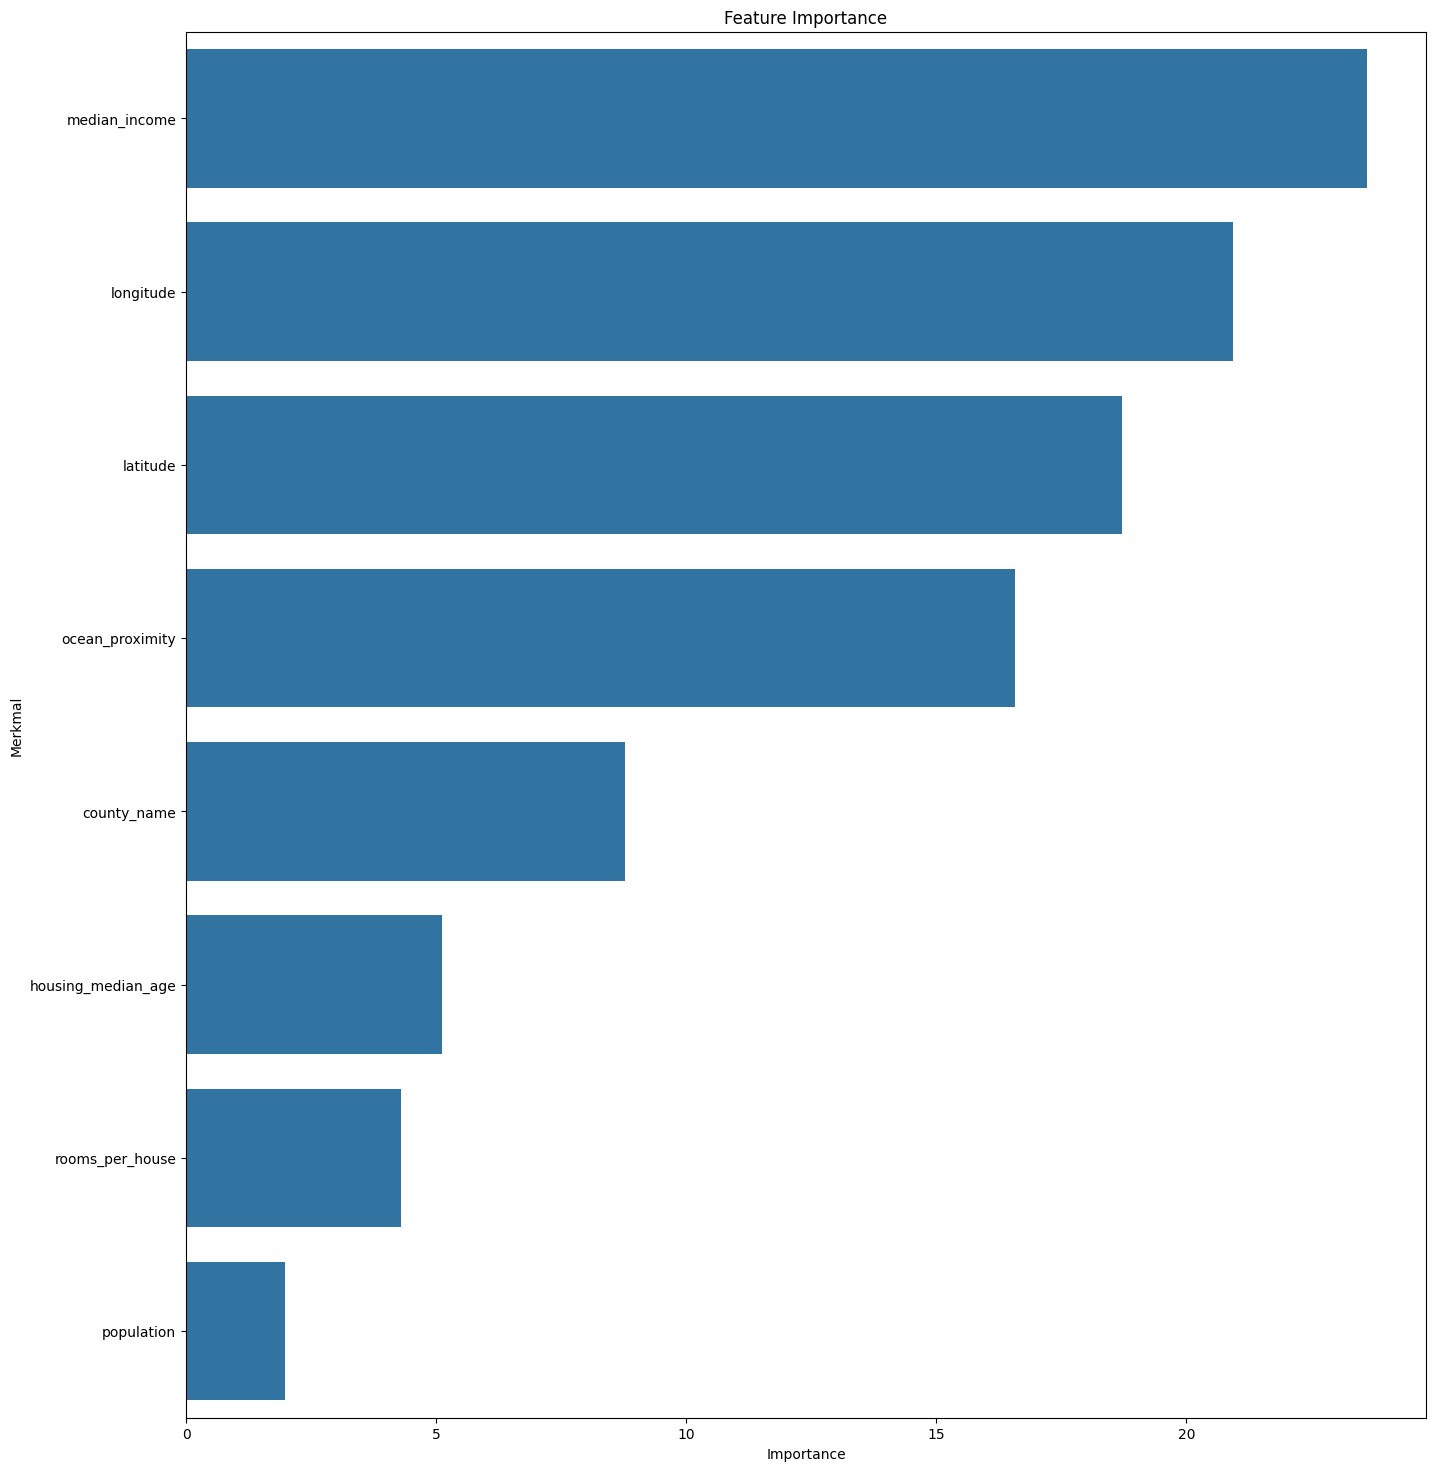

In [87]:
importances = pd.DataFrame({'features': x_train.columns, 'importances': model_CB.get_feature_importance()}).sort_values(by='importances',ascending=False)
plt.figure(figsize=(16, 18))
sns.barplot(x='importances', y='features', data=importances)
plt.xlabel('Importance')
plt.ylabel('Merkmal')
plt.title('Feature Importance')
plt.show()
del importances
del model_CB

Anhand der Feature Importance kann man erkennen, warum das Modell nur eine geringe Verbesserung gegenüber dem CatBoost mit nur numerischen Merkmalen erzielt: Die wichtigsten Merkmale sind mit dem Medianeinkommen und den geografischen Standorten ohnehin numerisch, während die Ozeannähe auf dem vierten Platz immerhin noch eine ähnliche Signifikanz aufweisen kann.

In [88]:
del x_train
del x_val
del y_train
del y_val

### Aufgabe A-7 c)
>Wie sind die Laufzeiten und Prognosefehler der in dieser Aufgabe erstellten Modelle im Vergleich und wie sind die Werte und Unterschiede zu bewerten? Basierend auf den Ergebnissen dieses Abschnitts soll ein abschließendes Fazit gezogen werden.

Prognosefehler der Modelle via RMSE:

In [89]:
rmses

{'Numeric Linear': 74508.93978488311,
 'Numeric Catboost': 48912.79736396997,
 'Categorical Linear': 91193.2953907611,
 'Categorical Catboost': 89735.68699792186,
 'Complete Linear': 69098.04473488663,
 'Complete Catboost': 48361.638797917374}

Laufzeitvergleich zwischen linearer Regression und CatBoost in Sekunden:

In [90]:
times

{'Complete Linear': 0.172684907913208, 'Complete CatBoost': 11.55141282081604}

Als abschließendes Fazit kann man erkennen dass CatBoost gegenüber der linearne Regression in diesem Fall eine deutlich bessere Vorhersagegüte bietet, allerdings auch eine deutlich erhöhte Laufzeit erfordert.

Die Prognosegüte der linearen Regression ist vermutlich daher deutlich schlechter, weil sich vor allem der geografische Ort mittels der Längen- und Breitengrade nicht besonder gut in einem linearen Modell abbilden lässt (zumindest ohne komplexere Transformationen). CatBoost hat dieses Problem bei Entscheidungsbäumen naturgemäß nicht.

Der Unterschied in der Laufzeit ist (zumindest bei CPU-Durchführung) mehr als eine komplette Größenordnung und könnte bei einem entsprechend großen Datensatz zusammen mit schlechter Hardware oder Echtzeitanfordeurngen (beim Fitting) ein Ausschlusskriterium für CatBoost darstellen.

# Teil B: Prognosemodelle optimieren und Overfitting verhindern

## Aufgabe B-1: Encoding, Skalierung und Vergleich

### Aufgabe B-1 a)
> Die numerischen Daten sind geeignet zu skalieren. Das ausgewählte Skalierungsverfahren ist kurz zu beschreiben und die Auswahl kurz zu begründen. Es sind vor und nach Skalierung die gleichen sieben zufälligen Zeilen der Daten anzuzeigen (die gleichen Datensätze) und das Ergebnis ist zu bewerten.

Es wird MimMax-Scaling verwendet um die numerischen Daten zu skalieren.MinMax-Scaling skaliert die Differenz zwischen Minimum und Maximum einer numerischen Spalte auf 1 und verschiebt die Werte, sodass das Minimum bei 0 und das Maximum bei 1 liegt.
Diese Methode wurde hauptsächlich gegenüber einer Standardisierung ausgewählt, weil es insbesondere für die weitere Anwendung in neuronalen Netzen effektiv und einfach zu handhaben ist.

In [91]:
sdata = data.copy()
featurescaler = sklearn.preprocessing.MinMaxScaler()
targetscaler = sklearn.preprocessing.MinMaxScaler()
numeric_features = numeric_columns.copy()
target_column = 'median_house_value'
numeric_features.remove(target_column)
sdata[numeric_features] = featurescaler.fit_transform(sdata[numeric_features])
sdata[target_column] = targetscaler.fit_transform(sdata[target_column].values.reshape(-1,1))

Ausgabe von 7 Zeilen vor und nach der Transformation

In [92]:
sample_index = sdata.sample(7, random_state=seed).index
display(data.loc[sample_index])
display(sdata.loc[sample_index])

latitude  longitude  housing_median_age  population  median_income  \
7310      34.05    -117.27                  34         849         3.1607   
4402      33.88    -117.57                  35        1453         2.3160   
1929      33.60    -117.90                  25         906         3.6538   
11551     35.37    -118.97                  34        1156         1.7197   
9882      34.20    -118.36                  14        1874         2.5267   
3896      33.85    -118.39                  24        1830         5.7128   
16638     37.83    -122.25                  52         534         3.1429   

       median_house_value ocean_proximity     county_name sample  \
7310               138200          INLAND  San Bernardino      A   
4402               119400          INLAND       Riverside      C   
1929               500001       <1H OCEAN          Orange      A   
11551               48900          INLAND            Kern      A   
9882               231800       <1H OCEAN     Los Angeles      C   
3896               366200       <1H OCEAN     Los Angeles      C   
16638              231600        NEAR BAY         Alameda      B   

       rooms_per_house  
7310          4.743733  
4402          4.100467  
1929          5.222458  
11551         4.377778  
9882          3.359571  
3896          5.307039  
16638         4.395189

latitude  longitude  housing_median_age  population  median_income  \
7310   0.160468   0.705179            0.647059    0.023711       0.183501   
4402   0.142402   0.675299            0.666667    0.040640       0.125247   
1929   0.112646   0.642430            0.470588    0.025309       0.217507   
11551  0.300744   0.535857            0.647059    0.032316       0.084123   
9882   0.176408   0.596614            0.254902    0.052440       0.139777   
3896   0.139214   0.593625            0.450980    0.051207       0.359505   
16638  0.562168   0.209163            1.000000    0.014883       0.182273   

       median_house_value ocean_proximity     county_name sample  \
7310             0.254022          INLAND  San Bernardino      A   
4402             0.215259          INLAND       Riverside      C   
1929             1.000000       <1H OCEAN          Orange      A   
11551            0.069899          INLAND            Kern      A   
9882             0.447011       <1H OCEAN     Los Angeles      C   
3896             0.724123       <1H OCEAN     Los Angeles      C   
16638            0.446598        NEAR BAY         Alameda      B   

       rooms_per_house  
7310          0.027630  
4402          0.023070  
1929          0.031024  
11551         0.025036  
9882          0.017818  
3896          0.031623  
16638         0.025159

Die besonders großen Werte einzelner Datensätze führen dazu, dass im Median die Werte von z.B. population und median_income nach der Skalierung in vielen Fällen sehr geringe Werte annimmt. Ansonsten ist die Transformation aber wie erwartet und (mit dem Wissen über obere Grenzwerte) ohne große Auffälligkeit.

### Aufgabe B-1 b)

> Die kategoriellen Daten sind geeignet in numerische Werte zu überführen. Das ausgewählte Encoding ist kurz zu beschreiben und die Auswahl kurz zu begründen. Für die sieben Zeilen aus Teilaufgabe a) sind die bearbeiteten Datensätze anzuzeigen und das Ergebnis ist zu bewerten. Es ist darauf einzugehen, wie viele Merkmale ggf. neu hinzugekommen sind und ob die Daten zu einem überbestimmten linearen Modell führen würden.

Wir verwenden One-Hot-Encoding um für jede Ausprägung jeweils ein boolsches Merkmal zu haben, welches anzeigt, ob das Merkmal zutrifft. Ausnahme bildet die erste Ausprägung, welche, um Redundanz zu vermeiden, kein eigenes Merkmal bekommt, sondern durch nicht-zutreffen aller anderen Merkmale codiert ist.

Die boolschen Merkmale werden in einer weiteren numerischen Verarbeitung typischerweise mit false=0 und true=1 verarbeitet.

Da es bei den Lankreisen keinen ordinalen Zusammenhang gibt ist One-Hot-Encoding einfach und effektiv um die Kategorien ohne weiteren Kontext zu repräsentieren.

In [93]:
esdata=pd.get_dummies(sdata, columns=categorical_features, drop_first=True)
columns_removed=sdata.columns.difference(esdata.columns)
columns_added=esdata.columns.difference(sdata.columns)

Darstellung der 7 Beispielzeilen vor und nach dem Encoding

In [94]:
display(sdata.loc[sample_index])
display(esdata.loc[sample_index])
del sample_index

latitude  longitude  housing_median_age  population  median_income  \
7310   0.160468   0.705179            0.647059    0.023711       0.183501   
4402   0.142402   0.675299            0.666667    0.040640       0.125247   
1929   0.112646   0.642430            0.470588    0.025309       0.217507   
11551  0.300744   0.535857            0.647059    0.032316       0.084123   
9882   0.176408   0.596614            0.254902    0.052440       0.139777   
3896   0.139214   0.593625            0.450980    0.051207       0.359505   
16638  0.562168   0.209163            1.000000    0.014883       0.182273   

       median_house_value ocean_proximity     county_name sample  \
7310             0.254022          INLAND  San Bernardino      A   
4402             0.215259          INLAND       Riverside      C   
1929             1.000000       <1H OCEAN          Orange      A   
11551            0.069899          INLAND            Kern      A   
9882             0.447011       <1H OCEAN     Los Angeles      C   
3896             0.724123       <1H OCEAN     Los Angeles      C   
16638            0.446598        NEAR BAY         Alameda      B   

       rooms_per_house  
7310          0.027630  
4402          0.023070  
1929          0.031024  
11551         0.025036  
9882          0.017818  
3896          0.031623  
16638         0.025159

latitude  longitude  housing_median_age  population  median_income  \
7310   0.160468   0.705179            0.647059    0.023711       0.183501   
4402   0.142402   0.675299            0.666667    0.040640       0.125247   
1929   0.112646   0.642430            0.470588    0.025309       0.217507   
11551  0.300744   0.535857            0.647059    0.032316       0.084123   
9882   0.176408   0.596614            0.254902    0.052440       0.139777   
3896   0.139214   0.593625            0.450980    0.051207       0.359505   
16638  0.562168   0.209163            1.000000    0.014883       0.182273   

       median_house_value sample  rooms_per_house  ocean_proximity_INLAND  \
7310             0.254022      A         0.027630                    True   
4402             0.215259      C         0.023070                    True   
1929             1.000000      A         0.031024                   False   
11551            0.069899      A         0.025036                    True   
9882             0.447011      C         0.017818                   False   
3896             0.724123      C         0.031623                   False   
16638            0.446598      B         0.025159                   False   

       ocean_proximity_ISLAND  ...  county_name_Sonoma  \
7310                    False  ...               False   
4402                    False  ...               False   
1929                    False  ...               False   
11551                   False  ...               False   
9882                    False  ...               False   
3896                    False  ...               False   
16638                   False  ...               False   

       county_name_Stanislaus  county_name_Sutter  county_name_Tehama  \
7310                    False               False               False   
4402                    False               False               False   
1929                    False               False               False   
11551                   False               False               False   
9882                    False               False               False   
3896                    False               False               False   
16638                   False               False               False   

       county_name_Trinity  county_name_Tulare  county_name_Tuolumne  \
7310                 False               False                 False   
4402                 False               False                 False   
1929                 False               False                 False   
11551                False               False                 False   
9882                 False               False                 False   
3896                 False               False                 False   
16638                False               False                 False   

       county_name_Ventura  county_name_Yolo  county_name_Yuba  
7310                 False             False             False  
4402                 False             False             False  
1929                 False             False             False  
11551                False             False             False  
9882                 False             False             False  
3896                 False             False             False  
16638                False             False             False  

[7 rows x 69 columns]

In [95]:
print("Es wurden",columns_removed.size,"kategorielle Spalten entfernt.")
print("Durch das Encoding kamen",columns_added.size,"binäre Spalten hinzu.")
del columns_removed, columns_added

Es wurden 2 kategorielle Spalten entfernt.
Durch das Encoding kamen 61 binäre Spalten hinzu.


Da wir beim Encoding die erste Spalte entfernt haben würde es hier kein überbestimmtes lineares Modell gebem. Aufgrund der vielen Ausprägungen der Landkreise gibt es viele neue Spalten durch das Encoding, die Dimension ist allerdings noch nicht in einem problematischen Bereich.

### Aufgabe B-1 c)
> Im Anschluss ist der nun skalierte und encodierte Datensatz in Trainingsdaten (sample = A) und Validierungsdaten (sample = B) aufzusplitten und die Zielvariable von den beschreibenden Variablen zu trennen.



Einordnung in Test- und Validierungsdatensatz

In [96]:
data_train = esdata[esdata['sample'] == 'A']
x_train = data_train.drop([target_column,'sample'], axis=1)
y_train = data_train[target_column]
del data_train

data_val = esdata[esdata['sample'] == 'B']
x_val = data_val.drop([target_column,'sample'], axis=1)
y_val = data_val[target_column]
del data_val

#für Aufgabe B-5
data_test = esdata[esdata['sample'] == 'C']
x_test = data_test.drop([target_column,'sample'], axis=1)
y_test = data_test[target_column]
del data_test

### Aufgabe B-1 d)
> An die so aufbereiteten Daten ist erneut ein CatBoost-Modell anzupassen. Dabei ist eine Zeitmessung durchzuführen und die Feature Importance auszugeben. Die Güte des Modells (RMSE) ist zunächst für den Trainingsdatensatz, im Anschluss für den Validierungsdatensatz zu ermitteln und die Ergebnisse sind zu vergleichen und zu interpretieren. Abschließend ist ein Vergleich mit dem CatBoost-Modell aus Aufgabe A-7 vorzunehmen und auf Laufzeit, Modellgüte (Validierung) und ggf. Auffälligkeiten im Vergleich der Feature Importances einzugehen, mögliche Ursachen zu ergründen und eine Bewertung vorzunehmen.



CatBoost an die skalierten und encodierten Daten anpassen

In [97]:
model_CB = catboost.CatBoostRegressor(random_state=seed,verbose=False)
starttime = time.time()
model_CB.fit(x_train, y_train)
fittime = time.time() - starttime
times['Scaled Encoded CatBoost'] = fittime
save_times(times)
y_val_pred_CB = model_CB.predict(x_val)
print("Laufzeit:",fittime,"s")
del starttime
del fittime

Laufzeit: 4.152780532836914 s


Um die RMSEs mit den vorherigen Modellen vergleichbar zu machen, müssen die Zielwerte wieder zurückskaliert werden.

In [98]:
y_train_reformed = targetscaler.inverse_transform(y_train.values.reshape(-1,1))
y_train_pred_CB = model_CB.predict(x_train)
y_train_pred_reformed = targetscaler.inverse_transform(y_train_pred_CB.reshape(-1,1))

In [99]:
print("RMSE auf den Trainingsdaten (zur Erkennung von Overfitting):",rmse(y_train_reformed, y_train_pred_reformed))

RMSE auf den Trainingsdaten (zur Erkennung von Overfitting): 37573.54660791557


In [100]:
y_val_pred_CB_reformed = targetscaler.inverse_transform(y_val_pred_CB.reshape(-1,1))
y_val_reformed = targetscaler.inverse_transform(y_val.values.reshape(-1,1))
print_results(y_val_reformed, y_val_pred_CB_reformed)
rmses['Scaled Encoded Catboost'] = rmse(y_val_reformed, y_val_pred_CB_reformed)
del y_val_pred_CB_reformed
del y_val_reformed
display(model_CB.get_params())

RMSE: 48406.630856312855
RMST (zum Vergleich): 114008.14636807823
R^2: 0.8197239874352333


{'loss_function': 'RMSE', 'verbose': False, 'random_state': 43}

In [101]:
#für Aufgabe B-5
y_test_pred_CB = model_CB.predict(x_test)
y_test_pred_CB_reformed = targetscaler.inverse_transform(y_test_pred_CB.reshape(-1,1))
y_test_reformed = targetscaler.inverse_transform(y_test.values.reshape(-1,1))
print_results(y_test_reformed, y_test_pred_CB_reformed)
rmsestest['Scaled Encoded Catboost'] = rmse(y_test_reformed, y_test_pred_CB_reformed)
del y_test_pred_CB, y_test_pred_CB_reformed
del y_test_reformed

RMSE: 46154.39938978077
RMST (zum Vergleich): 116233.22814781606
R^2: 0.8423239947821303


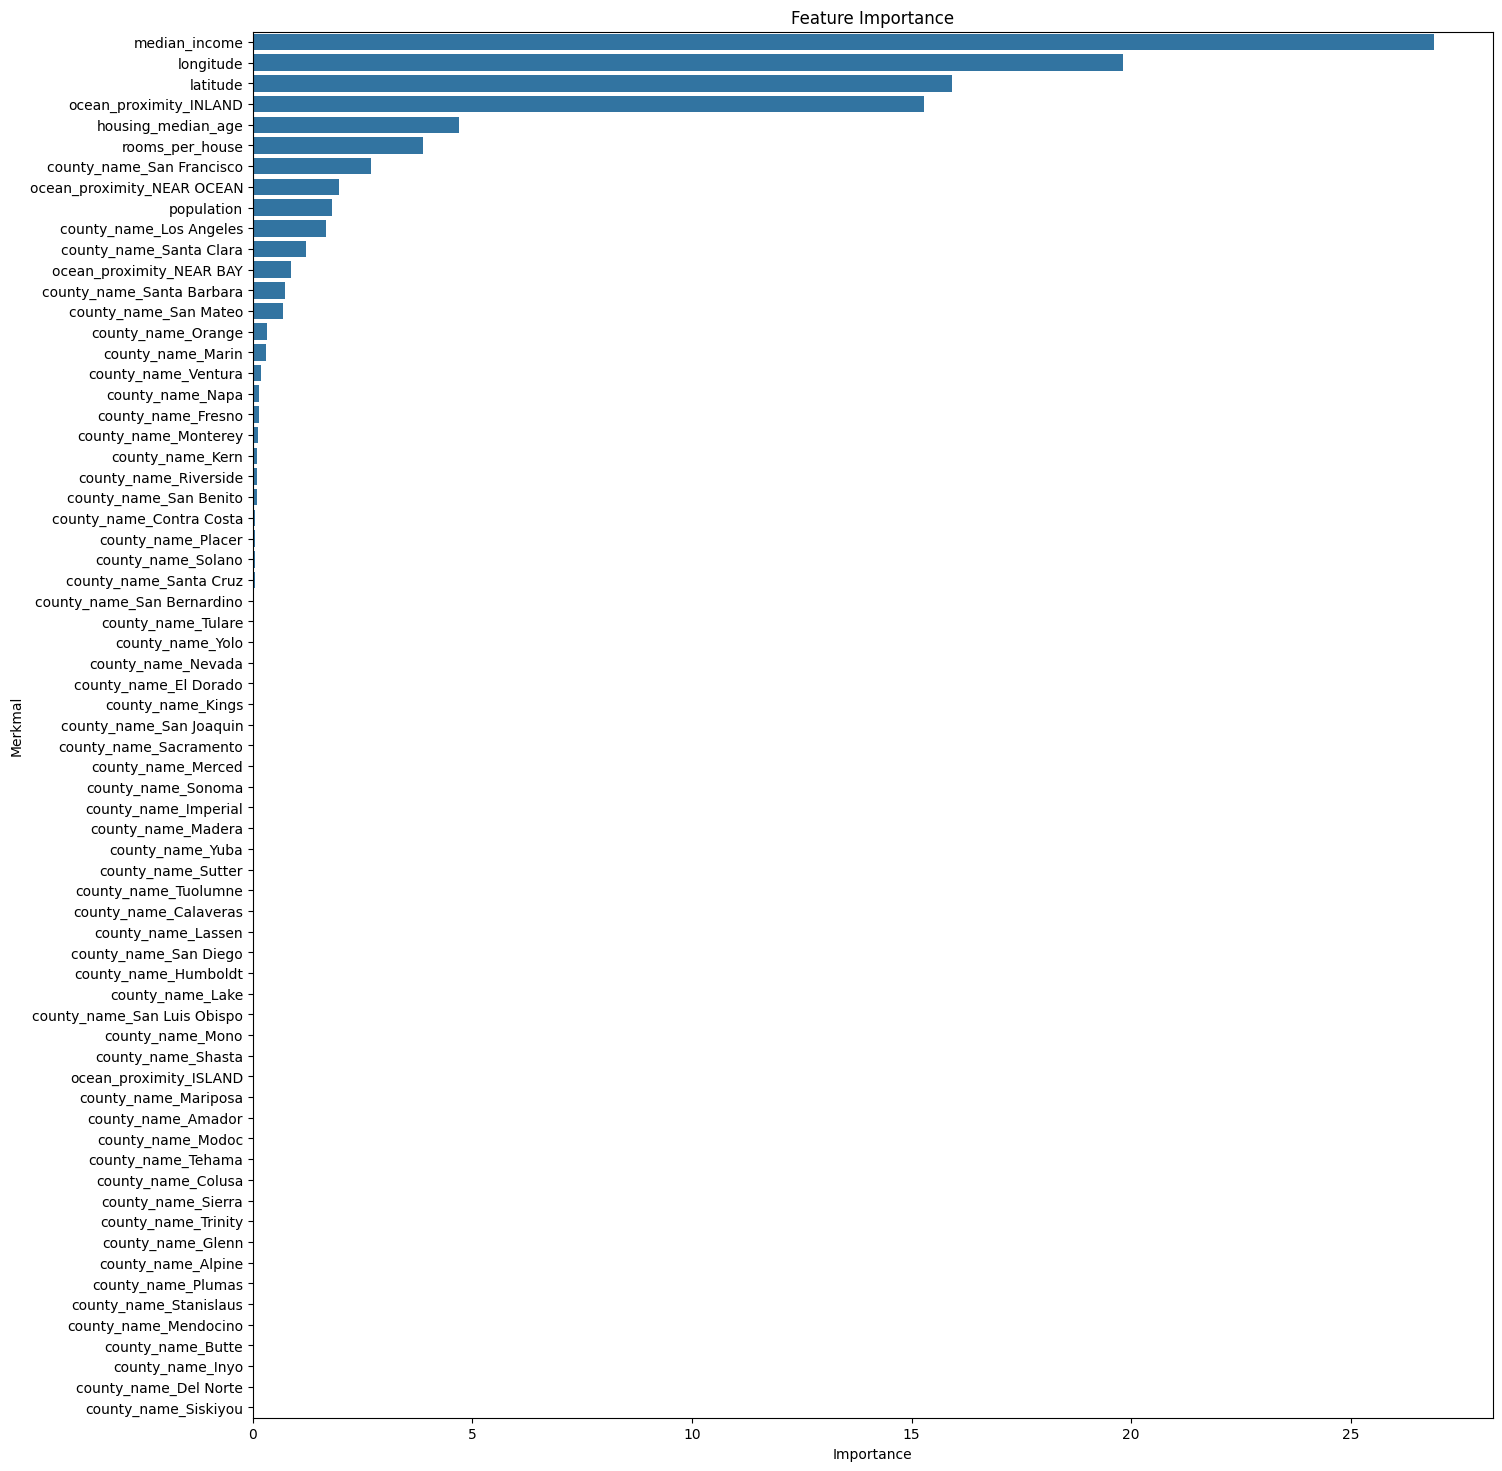

In [102]:
importances = pd.DataFrame({'features': x_train.columns, 'importances': model_CB.get_feature_importance()}).sort_values(by='importances',ascending=False)
plt.figure(figsize=(16, 18))
sns.barplot(x='importances', y='features', data=importances)
plt.xlabel('Importance')
plt.ylabel('Merkmal')
plt.title('Feature Importance')
plt.show()
del importances
del model_CB

In [103]:
print("Fitting-Laufzeiten")
times

Fitting-Laufzeiten


{'Complete Linear': 0.172684907913208,
 'Complete CatBoost': 11.55141282081604,
 'Scaled Encoded CatBoost': 4.152780532836914}

In [104]:
print("Vergleich der RMSEs auf den Validierungsdaten")
display(rmses)

Vergleich der RMSEs auf den Validierungsdaten


{'Numeric Linear': 74508.93978488311,
 'Numeric Catboost': 48912.79736396997,
 'Categorical Linear': 91193.2953907611,
 'Categorical Catboost': 89735.68699792186,
 'Complete Linear': 69098.04473488663,
 'Complete Catboost': 48361.638797917374,
 'Scaled Encoded Catboost': 48406.630856312855}

Insgesamt wir durch die Skalierung und das Encoding im eigentlichen Fitting Laufzeit gespart, die tatsächliche Prognosegüte ist aber nicht besser geworden.
Grund dafür ist, dass Catboost von sich aus bereits mit kategoriellen Daten umgehen kann -- da unser One-Hot-Encoding nicht so optimiert wie das interne Encoding von CatBoost ist, erhöhen wir damit die Dimensionalität ohne Mehrwert.
Hier ist, auch für spätere Interpretationen der numerischen Werte, das CatBoost auf unskalierten und unkodierten Daten zu bevorzugen.


Auffällig ist, dass die Feature Importance der Ozeannähe aus Aufgabe A-7 scheinbar fast vollständig durch die Ausprägung INLAND und in etwas geringerem Maße NEAR_OCEAN dominiert wird. Nach weiteren numerischen Merkmalen kommen anschließend mit wenigen Landkreisen dann wieder kategorische Merkmale in der Rangfolge.
Insgesamt bleibt das Modell durch numerische Merkmale dominiert und gibt nur gewissen Ausprägungen der kategorischen Merkmale eine relative Wichtigkeit, da nur diese eine starke Aussagekraft zu besitzen scheinen.

In [105]:
del y_train_pred_CB
del y_train_pred_reformed
del y_train_reformed
del x_train
del x_val
del y_train
del y_val
del y_val_pred_CB

In [106]:
del targetscaler, featurescaler

## Aufgabe B-2: Under-/Overfitting am Beispiel von Neuronalen Netzen

### Aufgabe B-2 a)
> Es ist ein Teildatensatz aus dem oben erstellten encodierten und skalierten Datensatz zu erstellen, der nur die ersten 100 Zeilen des Datensatzes enthält. Damit sind 3 einfache Neuronale Netze unterschiedlicher Größe mit Keras/Tensorflow sequenziell zu definieren, zu kompilieren, anzuzeigen (via summary) und jeweils über eine hohe Anzahl von Epochen (> 2000) zu trainieren:
>• klein: 1.000 bis 10.000 Gewichte
>• mittel: 50.000 bis 100.000 Gewichte
>• groß: mindestens 1.000.000 Gewichte
>Die history der einzelnen Modelle ist in einem (einzigen) Diagramm zu plotten. Dabei soll der Verlauf des RMSE auf den Trainingsdaten sowie der Verlauf des RMSE auf der internen Modellvalidierung (Split 0.2) dargestellt werden. Die Ergebnisse sind zu beschreiben und zu bewerten.

In [107]:
#Zurücksetzen der Seeds
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

Erstellung des Datensatzes. Da die vorhandenen Daten nach Lokalität geordnet sind und der interne Training-Validierungs-Split in Keras keine weitere Mischung vornimmt (sondern ab einem gewissen Punkt abschneidet), müssen die Trainingsdaten hier in eine zufällige Reihenfolge gebracht werden, um dem Bias in der Location entgegenzuwirken.

Es ist zu erwähnen, dass die Forderung, die ersten 100 Datensätze zu nehmen, bereits einen sehr großen geografischen Bias beinhaltet und die so erzeugten Modelle nicht gut auf den restlichen Datensatz verallgemeinern.

In [108]:
first_esdata_randomized=esdata[:100].sample(frac=1, random_state=seed)
y_train = first_esdata_randomized['median_house_value']
x_train = first_esdata_randomized.drop(['sample','median_house_value'], axis=1)
del first_esdata_randomized

Wir nutzen eine einfache Heuristik für die Netzwerkstruktur:
DIe Anzahl der Layer skaliert logarithmisch mit der Anzahl der Neuronen.
Die Anzahl der Neuronen pro Layer ist konstant, mit einem Ergebnislayer welches ein einziges Neuron umfasst.

Als Verlustmetrik nehmen wir direkt den MSE um daraus einfach den RMSE zurückgewinnen zu können.

Aufbau und Struktur der drei Netzwerke:

In [109]:
print("Erstes Netzwerk (klein)")
model1=simple_network(100, num_features=x_train.columns.size)
model1.summary()
print("")
print("Zweites Netzwerk (mittel)")
model2=simple_network(650, num_features=x_train.columns.size)
model2.summary()
print("")
print("Drittes Netzwerk (groß)")
model3=simple_network(3000, num_features=x_train.columns.size)
model3.summary()

Erstes Netzwerk (klein)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25)                1700      
                                                                 
 dense_1 (Dense)             (None, 25)                650       
                                                                 
 dense_2 (Dense)             (None, 25)                650       
                                                                 
 dense_3 (Dense)             (None, 25)                650       
                                                                 
 dense_4 (Dense)             (None, 1)                 26        
                                                                 
Total params: 3676 (14.36 KB)
Trainable params: 3676 (14.36 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________

Zum Trainieren werden hier 2024 Epochen genutzt.

In [110]:
epochs = 2024

In [111]:
trained_model_1, history_1 = train_model(model1, x_train, y_train, epochs, 'NN_klein_GPU',retrain_models, True, nn_verbosity)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [112]:
trained_model_2, history_2 = train_model(model2, x_train, y_train, epochs,'NN_mittel_GPU',retrain_models, True, nn_verbosity)

In [113]:
trained_model_3, history_3 = train_model(model3, x_train, y_train, epochs,'NN_groß_GPU',retrain_models, True, nn_verbosity)

Um die orginale Skalierung des RMSE vor der MinMax-Skalierung zurückzugewinnen benötigen wir den Faktor $(y_{max} - y_{min})^2$ der unskalierten Werte, denn
$$MSE_{org}=(y_{max} - y_{min})^2  MSE_{skaliert}$$
$$RMSE_{org}=\sqrt{MSE_{org}}$$

In [114]:
MSE_scaling_factor = (data['median_house_value'].max() - data['median_house_value'].min()) **2

In [115]:
scaled_loss_1 = [math.sqrt(val * MSE_scaling_factor) for val in history_1.history['mean_squared_error'] ]
scaled_val_loss_1 = [math.sqrt(val * MSE_scaling_factor) for val in history_1.history['val_mean_squared_error'] ]
scaled_loss_2 = [math.sqrt(val * MSE_scaling_factor) for val in history_2.history['mean_squared_error' ] ]
scaled_val_loss_2 = [math.sqrt(val * MSE_scaling_factor) for val in history_2.history['val_mean_squared_error'] ]
scaled_loss_3 = [math.sqrt(val * MSE_scaling_factor) for val in history_3.history['mean_squared_error'] ]
scaled_val_loss_3 = [math.sqrt(val * MSE_scaling_factor) for val in history_3.history['val_mean_squared_error'] ]

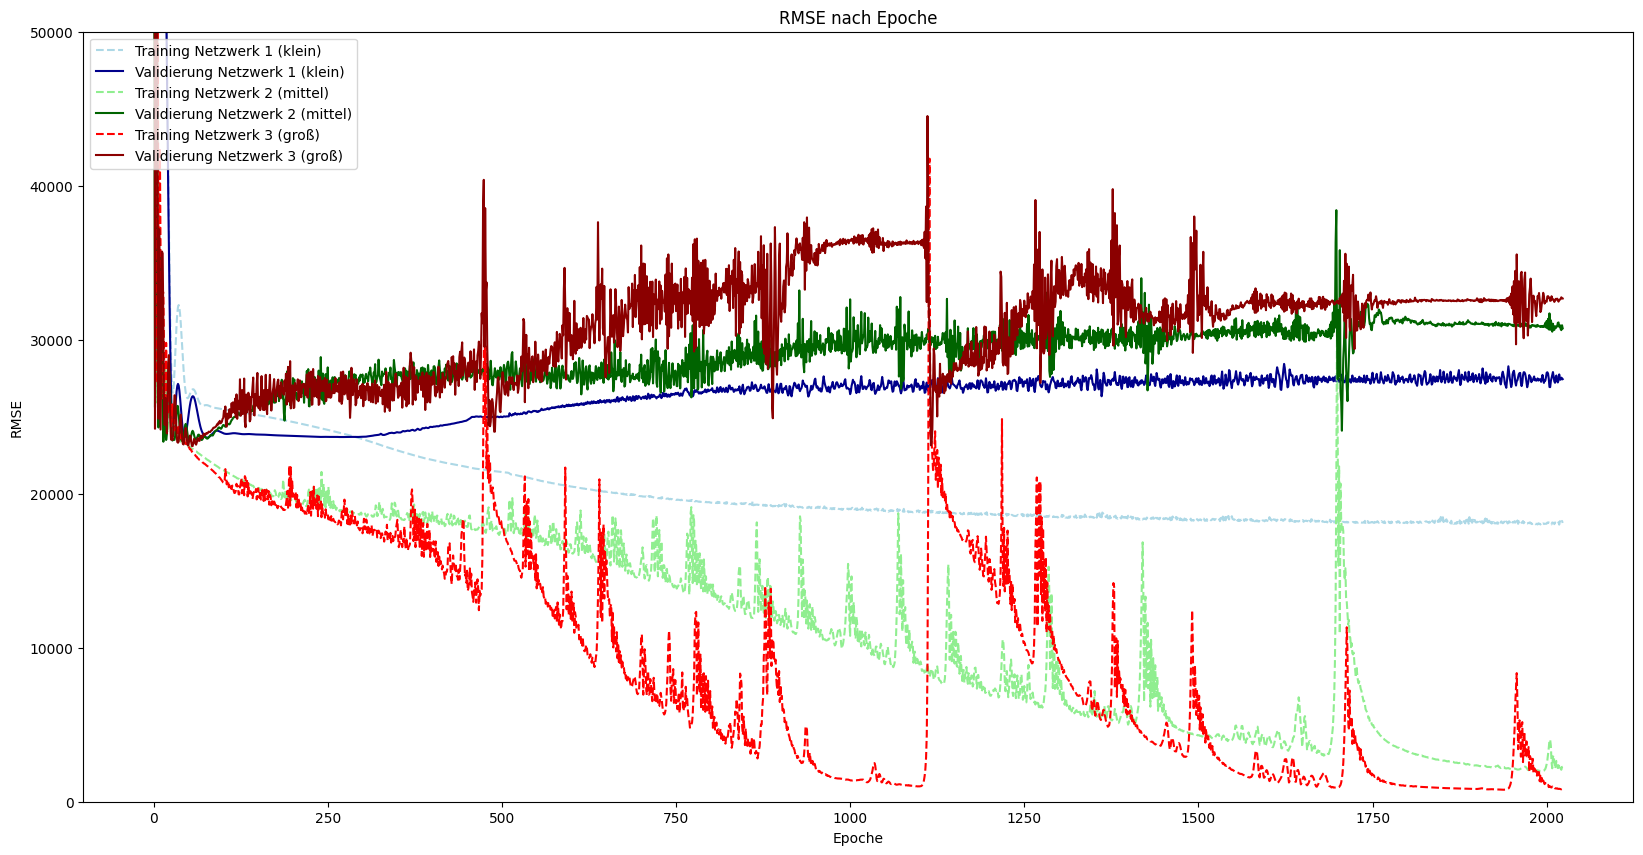

In [116]:
plt.figure(figsize=(20, 10))
plt.plot(scaled_loss_1,linestyle='--',color='lightblue')
plt.plot(scaled_val_loss_1,linestyle='-',color='darkblue')
plt.plot(scaled_loss_2,linestyle='--',color='lightgreen')
plt.plot(scaled_val_loss_2,linestyle='-',color='darkgreen')
plt.plot(scaled_loss_3,linestyle='--',color='red')
plt.plot(scaled_val_loss_3,linestyle='-',color='darkred')
plt.title('RMSE nach Epoche')
plt.xlabel('Epoche')
plt.ylabel('RMSE')
plt.ylim(0,50000)
plt.legend(['Training Netzwerk 1 (klein)', 'Validierung Netzwerk 1 (klein)',
            'Training Netzwerk 2 (mittel)', 'Validierung Netzwerk 2 (mittel)',
            'Training Netzwerk 3 (groß)', 'Validierung Netzwerk 3 (groß)'],
            loc='upper left')
plt.show()

Hier sind die drei Netzwerke (klein=blau, mittel=grün und groß=rot) jeweils mit ihrem zurückskalierten Trainings-RMSE (hell) und dem Validierungs-RMSE (dunkel) dargestellt. Es wird keinerlei Regularisierung verwendet.

Es ist auffällig, dass das kleine Netzwrk auch nach einer großen Anzahl an Epochen bei einem stabilen RMSE verbleibt. Bei den mittleren und großen Netzwerken ist schnell ein Effekt von Overfitting zu sehen, bei dem der RMSE auf den Trainingsdaten verbessert wird, auf den Validierungsdaten dafür aber deutlich schlechter wird.

Das kleine Netzwerk performt auch deswegen besser, weil durch den sehr kleinen Datensatz gar nicht mehr generalisierbare Informationen in den Trainingsdaten vorhanden sind, insbesondere im Vergleich mit den zu trainierenden Parametern.

Da wir nur die 100 ersten Datensätze verwendet haben und die Datensätze geografisch sortiert sind haben wir hier auch mehr uniformität als im gesamten Datensatz, womit auch ein geringerer RMSE einher geht. Bei Verwendung des vollen Datensatzes ist zu erwarten, dass der RMSE entsprechend höher ausfallen wird.

In [117]:
print("Anzahl Informationswerte im Trainingssatz: ",0.8 * x_train.columns.size * len(x_train))

Anzahl Informationswerte im Trainingssatz:  5360.0


In [118]:
del model1
del model2
del model3
del trained_model_1
del trained_model_2
del trained_model_3
del scaled_loss_1
del scaled_val_loss_1
del scaled_loss_2
del scaled_val_loss_2
del scaled_loss_3
del scaled_val_loss_3
del history_1
del history_2
del history_3
del x_train
del y_train

In [119]:
del MSE_scaling_factor

### Aufgabe B-2 b)
> Es soll ein Neuronales Netz für den kompletten Trainingsdatensatz (sample = A) erstellt werden. Hierbei sind bei der Architektur des Netzes ggf. Erkenntnisse aus Teilaufgabe a) miteinzubeziehen und die vorgenommenen Änderungen an der Architektur des Netzes zu beschreiben. Die Größe und Architektur des Neuronalen Netzes muss ausreichend groß sein, um die Komplexität des Datensatzes abbilden zu können. Overfitting soll durch geeignete Regularisierung verhindert werden. Die Daten sind zu fitten und die Lernkurve aus (interner) Trainings- und Modellvalidierung ist zu plotten. Im Anschluss ist das Modell mit den „externen“ Validierungsdaten (sample = B) zu validieren. Falls die Prognosegüte dieses hochparametrigen Modells schlechter als die des einfachen linearen Modells aus Aufgabe A-7 a) ist, sind die Ursachen zu suchen und zu beheben. Dieses Ergebnis (RMSE) ist samt Laufzeit anzuzeigen, dem Gesamtvergleich hinzuzufügen und zu bewerten.



In [120]:
#Zurücksetzen der Seeds
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

Aufbau der Trainingsdaten. Wir oben randomisieren wir die Reihenfolge der Trainingsdaten für eine bessere (interne) Validierung.

In [121]:
resdata=esdata.sample(frac=1, random_state=seed)
x_train = resdata[resdata['sample']=='A'].drop(['sample', target_column], axis=1)
y_train=resdata[resdata['sample']=='A'][target_column]

Eine grobe Einschätzung, wie viel tatsächliche Informationen in unserem Trainingsdatensatz vorliegt (Anzahl Datenpunkte mal Anzahl Merkmale)

In [122]:
len(esdata[esdata['sample']=='A'])*(esdata.columns.size-1)

980628

Das Netzwerk wird dieses mal mit Parametern für die Learning-Rate und die Regularisierung definiert, ansonsten wie oben mit logarithmischer Anzahl der Layer und sinkenden Neuronen pro Layer.

Wir wählen eine relativ geringe Regularisierungsstärke, da diese einen großen Effekt auf den Loss besitzt. Außerdem kann man damit die weitere Strategie dargestellt werden, die wir gegen Overfitting verwenden: Early Stopping.

In [123]:
model = simple_regularized_network(middle_neurons=338, num_features=x_train.columns.size, reg_strength=0.0001, learning_rate=0.001)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 67)                4556      
                                                                 
 dense_22 (Dense)            (None, 67)                4556      
                                                                 
 dense_23 (Dense)            (None, 67)                4556      
                                                                 
 dense_24 (Dense)            (None, 67)                4556      
                                                                 
 dense_25 (Dense)            (None, 67)                4556      
                                                                 
 dense_26 (Dense)            (None, 1)                 68        
                                                                 
Total params: 22848 (89.25 KB)
Trainable params: 22848

Wir nutzen wieder >2000 Epochen, diese werden jedoch nicht erreicht. Durch Early-Stopping wird das Training abgebrochen, sobald sich der Loss auf den internen Validierungsdaten über eine Epochendauer nicht verbessert, wonach anschließend die besten gefundenen Gewichte verwendet werden.

Das Modell wird trainiert und die Laufzeit gespeichert.

In [124]:
starttime = time.time()
trained_model, history = train_model_early_stopping(model=model, x_train=x_train, y_train=y_train, epochs=2024, name='NN_data_GPU',retrain_model=retrain_models, verbosity=nn_verbosity)
fittime = time.time() - starttime
if retrain_models:
  times['Complete Neural Network GPU'] = fittime
  save_times(times)
if 'Complete Neural Network GPU' in times:
  print("Laufzeit:",times['Complete Neural Network GPU'],"s")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Laufzeit: 127.97513270378113 s


Plotten der History

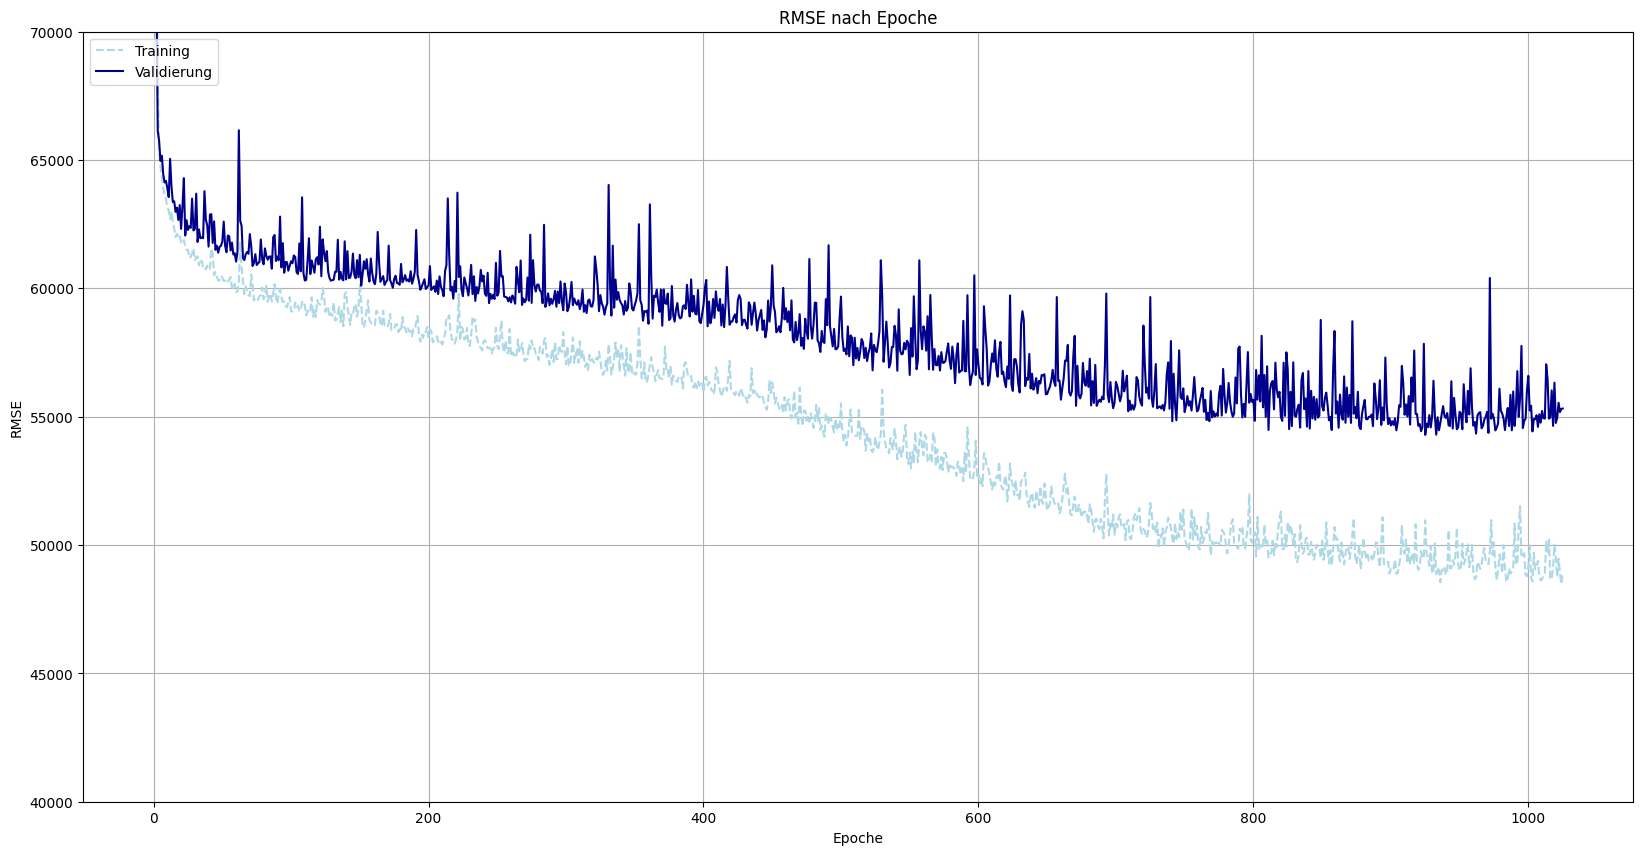

In [125]:
MSE_scaling_factor = (data['median_house_value'].max() - data['median_house_value'].min()) **2
scaled_loss = [math.sqrt(val * MSE_scaling_factor) for val in history.history['mean_squared_error'] ]
scaled_val_loss = [math.sqrt(val * MSE_scaling_factor) for val in history.history['val_mean_squared_error'] ]
plt.figure(figsize=(20, 10))
plt.plot(scaled_loss,linestyle='--',color='lightblue')
plt.plot(scaled_val_loss,linestyle='-',color='darkblue')
plt.title('RMSE nach Epoche')
plt.xlabel('Epoche')
plt.ylabel('RMSE')
plt.grid(True)
plt.ylim(40000,70000)
plt.legend(['Training', 'Validierung'],
            loc='upper left')
plt.show()

In [126]:
display(min(scaled_val_loss))

54292.90694655991

In [127]:
display(min(scaled_loss))

48483.45229532457

Man sieht dass hier eindeutig der Fehler der Trainingsdaten sinkt, während sich der Fehler der internen Validiserungsdaten nach einiger Zeit nur noch unwesentlich verändert. Zu Beginn werden aber echte Effekte gefunden, da sich auch die Validierungsergebnisse leicht verbessern. Ab einem gewissen Punkt kann der Validierungsfehler nicht mehr verbessert werden, wodurch Early Stopping getriggert und das Training beendet wird.

Nun wird das Modell auf den externen Validierungsdaten getestet

In [128]:
x_val = resdata[resdata['sample']=='B'].drop(['sample', target_column], axis=1)
y_val=resdata[resdata['sample']=='B'][target_column]

In [129]:
MSE = trained_model.evaluate(x_val.values.astype(float), y_val.values.astype(float))[1]
RMSE = math.sqrt(MSE_scaling_factor*MSE)
rmses['Complete Neural Network GPU'] = RMSE
display(rmses['Complete Neural Network GPU'])
del MSE
del RMSE
del x_train
del x_val
del y_train
del y_val

98/98 [==============================] - 0s 2ms/step - loss: 0.0156 - mean_squared_error: 0.0133


55848.55913419424

In [130]:
#für Aufgabe B-5
x_test = resdata[resdata['sample']=='C'].drop(['sample', target_column], axis=1)
y_test=resdata[resdata['sample']=='C'][target_column]
MSE = trained_model.evaluate(x_test.values.astype(float), y_test.values.astype(float))[1]
RMSE = math.sqrt(MSE_scaling_factor*MSE)
rmsestest['Complete Neural Network GPU'] = RMSE
display(rmsestest['Complete Neural Network GPU'])
del MSE
del RMSE
del x_test
del y_test

98/98 [==============================] - 0s 2ms/step - loss: 0.0149 - mean_squared_error: 0.0126


54340.25322784039

Die anderen Modell-RMSEs und Laufzeiten auf den Validierungsdaten zum Vergleich

In [131]:
print("RMSEs:")
display(rmses)
print("Laufzeiten:")
display(times)

RMSEs:


{'Numeric Linear': 74508.93978488311,
 'Numeric Catboost': 48912.79736396997,
 'Categorical Linear': 91193.2953907611,
 'Categorical Catboost': 89735.68699792186,
 'Complete Linear': 69098.04473488663,
 'Complete Catboost': 48361.638797917374,
 'Scaled Encoded Catboost': 48406.630856312855,
 'Complete Neural Network GPU': 55848.55913419424}

Laufzeiten:


{'Complete Linear': 0.172684907913208,
 'Complete CatBoost': 11.55141282081604,
 'Scaled Encoded CatBoost': 4.152780532836914,
 'Complete Neural Network GPU': 127.97513270378113}

Die Modellperformance ist zwar besser als das einfache lineare Modell, bleibt aber deutlich hinter CatBoost zurück. Angesichts des erforderlichen Tunings und der hohen Laufzeitanforderung des Trainings für neuronale Netzwerke liefert das Neuronale Netz zwar einen validen Ansatz, ist in diesem Anwendungsfall alleridngs nicht das erste Mittel der Wahl.

In [132]:
del MSE_scaling_factor
del fittime
del model
del resdata
del scaled_loss
del scaled_val_loss
del starttime
del trained_model

## Aufgabe B3: Neuronales Netz mit Embeddings

### Aufgabe B-3 a)
>Die kategoriellen Merkmale ocean_proximity und county_name sind über zwei-dimensionale Embeddings in ein Neuronales Netz einzufügen. Die verborgenen Schichten des Netzes sollen dabei aus dem Neuronalen Netz aus Aufgabe B-2 b) übernommen werden. Die nötigen Anpassungen der Modellumsetzung sind detailliert vorab zu beschreiben und dann durchzuführen. Die Trainingsdaten sind zu fitten und die Konvergenz ist zu bewerten. Falls Letztere nicht gegeben ist, so sind die notwendigen Veränderungen durchzuführen.

Wegen des Embeddings nutzen wir hier nur den skalierten Datensatz ohne One-Hot Encoding.

In [133]:
training_data=sdata[sdata['sample']=='A'].sample(frac=1.0, random_state=seed)
x_train=training_data.drop([target_column,'sample'],axis=1)
y_train=training_data[target_column]
del training_data

Wir verwenden die gleichen einfachen Netzwerkaufbau mit einer konstanten Anzahl an Neuronen pro innerer Schicht und einer Anzahl von Schichten die logarithmisch mit der Gesamtanzahl der Neuronen steigt. Da wir ebenfalls die gleiche Anzahl an inneren Neuronen verwenden ist der Aufbau somit identisch zur Aufgabe B-2 b).

In [134]:
middle_neurons=338
learning_rate=0.001
reg_strength=0.0001
layer_shape = simple_layer_shape(middle_neurons)
display(layer_shape)

[67, 67, 67, 67, 67]

Die bisherigen Inputs aus dem One-Hot-Encoding fallen weg. Statdessen werden zwei Input-Layer, jeweils für die Kategorien der Ozeannnähe und der Landkreise angelegt. Hinter diesen liegt jeweils ein 2-dimensionales Encoding-Layer. Jedes dieser Encoding-Layer muss wieder in ein Paar aus 1-dimensionalen Werten überführt werden, weshalb diese jeweils mit Flatten-Layer verbunden sind.

Nun liefern beide Flatten-Layer jeweils zwei Outputs und stellen die embeddeten Informationen der kategoriellen Variablen dar. Daneben wird das Input-Layer für die numerischen Features angelegt und mit einem Concatenation-Layer zu einem Gesamtlayer als Input für das dichte neuronale Netz zusammengefügt.

Das dichte neuronale Netz hat, wie oben beschrieben, den identischen einfachen Aufbau wie im vorherigen Aufgabenteil.

In [135]:
embedding_size = 2
cat_input_1 = keras.layers.Input(shape=(1,))
cat_input_2 = keras.layers.Input(shape=(1,))
embed_layer1 = keras.layers.Embedding(input_dim=x_train['ocean_proximity'].nunique(), output_dim=embedding_size)(cat_input_1)
embed_layer2 = keras.layers.Embedding(input_dim=x_train['county_name'].nunique(), output_dim=embedding_size)(cat_input_2)
flatten_layer_1 = keras.layers.Flatten()(embed_layer1)
flatten_layer_2 = keras.layers.Flatten()(embed_layer2)
num_input = keras.layers.Input(shape=(len(numeric_features),))
concatenated_inputs = keras.layers.Concatenate()([flatten_layer_1, flatten_layer_2, num_input])
previous_layer=concatenated_inputs
for nodes in layer_shape:
  next_layer = keras.layers.Dense(nodes, activation='relu',kernel_regularizer=keras.regularizers.l2(reg_strength))(previous_layer)
  previous_layer = next_layer
output_layer = keras.layers.Dense(1, activation='relu',kernel_regularizer=keras.regularizers.l2(reg_strength))(previous_layer)
model = keras.Model(inputs=[cat_input_1, cat_input_2, num_input], outputs=output_layer)
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

In [136]:
del cat_input_1, cat_input_2
del embed_layer1, embed_layer2
del flatten_layer_1, flatten_layer_2
del num_input, concatenated_inputs
del previous_layer, next_layer, output_layer, optimizer

In [137]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 2)                 10        ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 2)                 116       ['input_2[0][0]']             
                                                                                              

In [138]:
starttime = time.time()
trained_model, history = train_embed_model(model,x_train,y_train,epochs=2024,name='NN_embed_GPU',retrain_model=retrain_models,verbosity=nn_verbosity)
fittime = time.time() - starttime
if retrain_models:
  times['Embedding Neural Network GPU'] = fittime
  save_times(times)
if 'Embedding Neural Network GPU' in times:
  print("Laufzeit:",times['Embedding Neural Network GPU'],"s")
del starttime
del fittime

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Laufzeit: 173.1190299987793 s


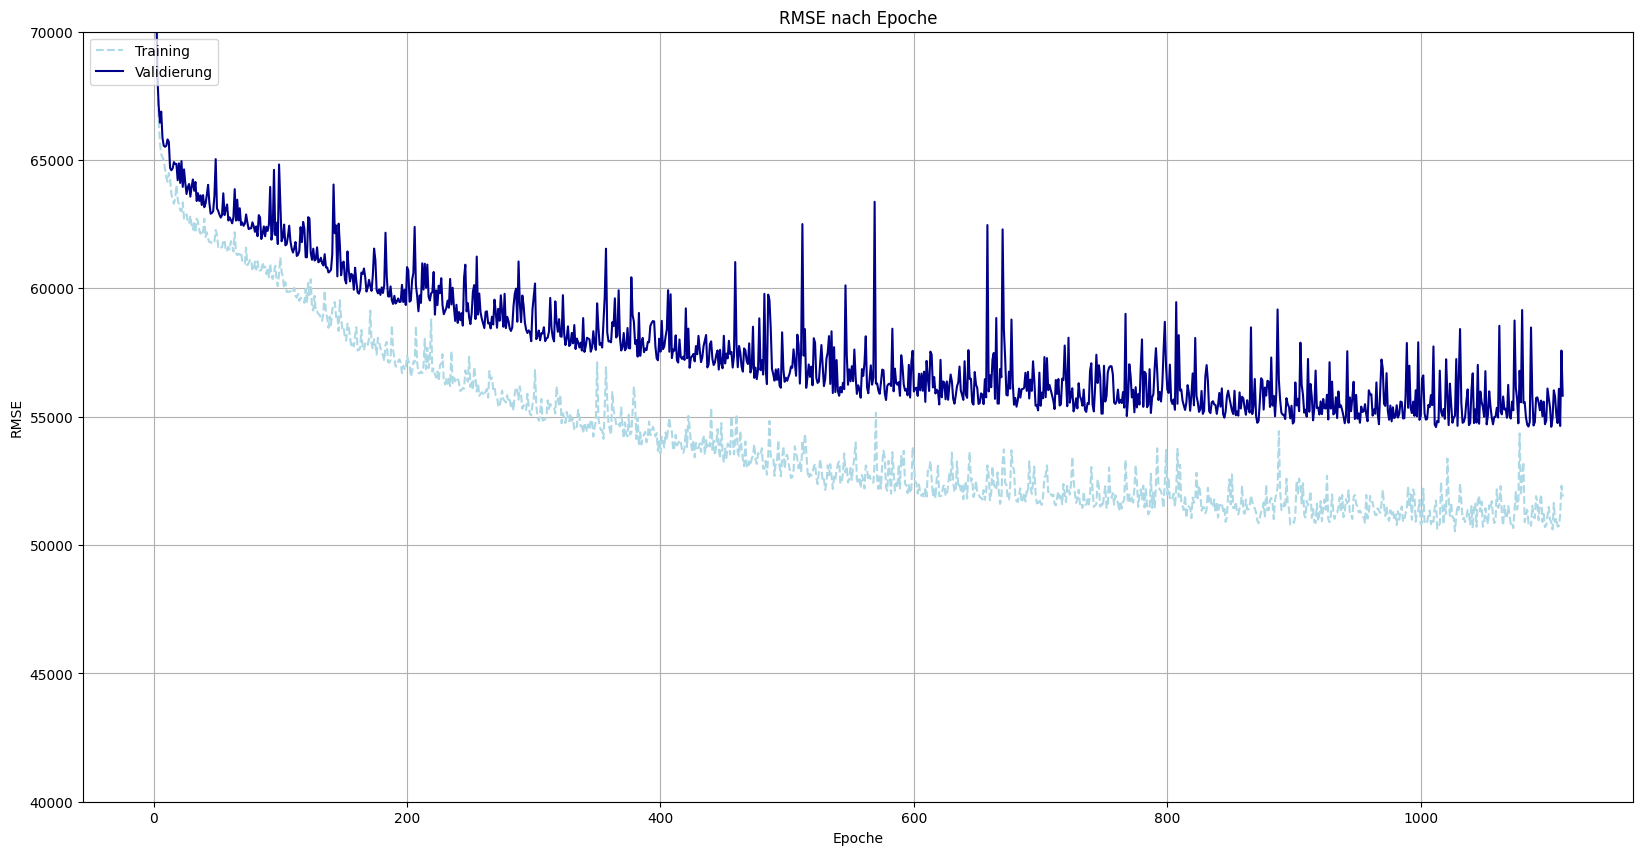

In [139]:
MSE_scaling_factor = (data['median_house_value'].max() - data['median_house_value'].min()) **2
scaled_loss = [math.sqrt(val * MSE_scaling_factor) for val in history.history['mean_squared_error'] ]
scaled_val_loss = [math.sqrt(val * MSE_scaling_factor) for val in history.history['val_mean_squared_error'] ]
plt.figure(figsize=(20, 10))
plt.plot(scaled_loss,linestyle='--',color='lightblue')
plt.plot(scaled_val_loss,linestyle='-',color='darkblue')
plt.title('RMSE nach Epoche')
plt.xlabel('Epoche')
plt.ylabel('RMSE')
plt.grid(True)
plt.ylim(40000,70000)
plt.legend(['Training', 'Validierung'],
            loc='upper left')

Hier greift ebenfalls wieder das Early-Stopping, sobald der Validierungsfehler über viele Epochen hinweg nicht verbesser werden kann.

In [140]:
display(min(scaled_val_loss))

54598.68608503783

In [141]:
display(min(scaled_loss))

50535.580244938814

In [142]:
del embedding_size
del layer_shape
del middle_neurons
del model
del nodes
del reg_strength
del scaled_loss
del scaled_val_loss

### Aufgabe B-3 b)
> Der RMSE der Validierungsdaten des Netzes mit Embeddings ist samt Fitting-Laufzeit zu ermitteln und dem Modellvergleich hinzuzufügen. Das Neuronale Netz mit Embeddings ist mit dem Neuronalen Netz aus Aufgabe B-2 b) zu vergleichen und zu bewerten.


In [143]:
validation_data=sdata[data['sample']=='B'].sample(frac=1.0, random_state=seed)
x_val=validation_data.drop([target_column,'sample'],axis=1)
y_val=validation_data[target_column]
del validation_data

In [144]:
MSE = trained_model.evaluate([x_val['ocean_proximity'].cat.codes,x_val['county_name'].cat.codes, x_val[numeric_features].values.astype(float)], y_val.values.astype(float),verbose=0)[1]
RMSE = math.sqrt(MSE_scaling_factor*MSE)
rmses['Embedding Neural Network GPU'] = RMSE
print("RMSE auf Validierungsdaten: ",rmses['Embedding Neural Network GPU'])

RMSE auf Validierungsdaten:  56440.34458079798


In [145]:
rmses

{'Numeric Linear': 74508.93978488311,
 'Numeric Catboost': 48912.79736396997,
 'Categorical Linear': 91193.2953907611,
 'Categorical Catboost': 89735.68699792186,
 'Complete Linear': 69098.04473488663,
 'Complete Catboost': 48361.638797917374,
 'Scaled Encoded Catboost': 48406.630856312855,
 'Complete Neural Network GPU': 55848.55913419424,
 'Embedding Neural Network GPU': 56440.34458079798}

In [146]:
times

{'Complete Linear': 0.172684907913208,
 'Complete CatBoost': 11.55141282081604,
 'Scaled Encoded CatBoost': 4.152780532836914,
 'Complete Neural Network GPU': 127.97513270378113,
 'Embedding Neural Network GPU': 173.1190299987793}

Das Embedding Neural Network kann keine signifikante Performance-Verbesserung gegenüber dem Neural Network mit One-Hot-Encoding erzielen. Es ist zu erwähnen, dass durch das nicht benötigte One-Hot-Encoding auch weniger Parameter bei den Inputs benötigt werden.

Bei der Laufzeit ist das das Neural Network mit Embedding etwas langsamer als das Neural Network mit One-Hot-Encoding, da das Encoding in jedem Schritt zusätzlich mittrainiert wird.

Falls der Encoding-Aufwand und die höhere Dimensionalität (inklusive Trainingsaufwand) kein Problem darstellen, lässt sich mit Encoding (ohne Embedding) eine gute Modellperformance erzielen. Beim Embedding hat man allerdings auch eine bessere Interpretierbarkeit durch die Embeddings, die ihrerseits in einem Anwendungsfall wichtig sein können.

In [147]:
del MSE
del RMSE

In [148]:
#für Aufgabe B-5
test_data=sdata[data['sample']=='C'].sample(frac=1.0, random_state=seed)
x_test=test_data.drop([target_column,'sample'],axis=1)
y_test=test_data[target_column]
MSE = trained_model.evaluate([x_test['ocean_proximity'].cat.codes,x_test['county_name'].cat.codes, x_test[numeric_features].values.astype(float)], y_test.values.astype(float),verbose=0)[1]
RMSE = math.sqrt(MSE_scaling_factor*MSE)
rmsestest['Embedding Neural Network GPU'] = RMSE
del MSE
del RMSE
del MSE_scaling_factor
del x_test, y_test
del test_data

### Aufgabe B-3 c)


> Die Embeddings der kategoriellen Merkmale sind aus dem Modell zu extrahieren und grafisch darzustellen.


1/1 [==============================] - 0s 66ms/step


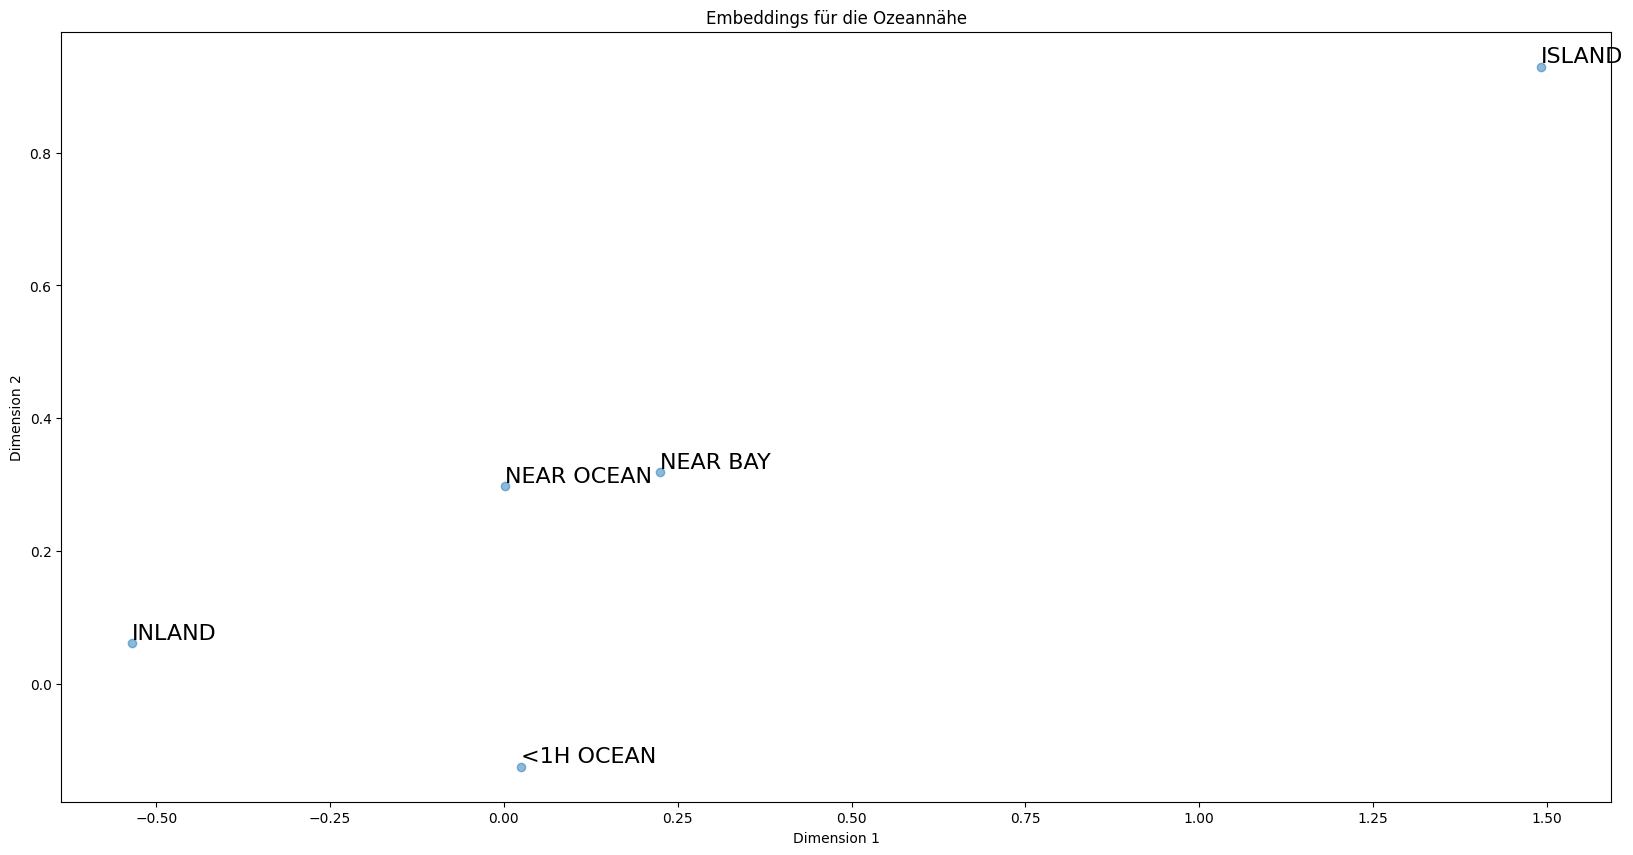

In [149]:
feature_name='ocean_proximity'
ocean_prox_embedding = trained_model.layers[2]
ocean_prox_input = trained_model.input[0]
embedding_model_ocean = keras.models.Model(inputs=ocean_prox_input, outputs=ocean_prox_embedding.output)
plot_embedding(feature_name='ocean_proximity', embedding_model=embedding_model_ocean, x_train=x_train, title='Embeddings für die Ozeannähe')

2/2 [==============================] - 0s 4ms/step


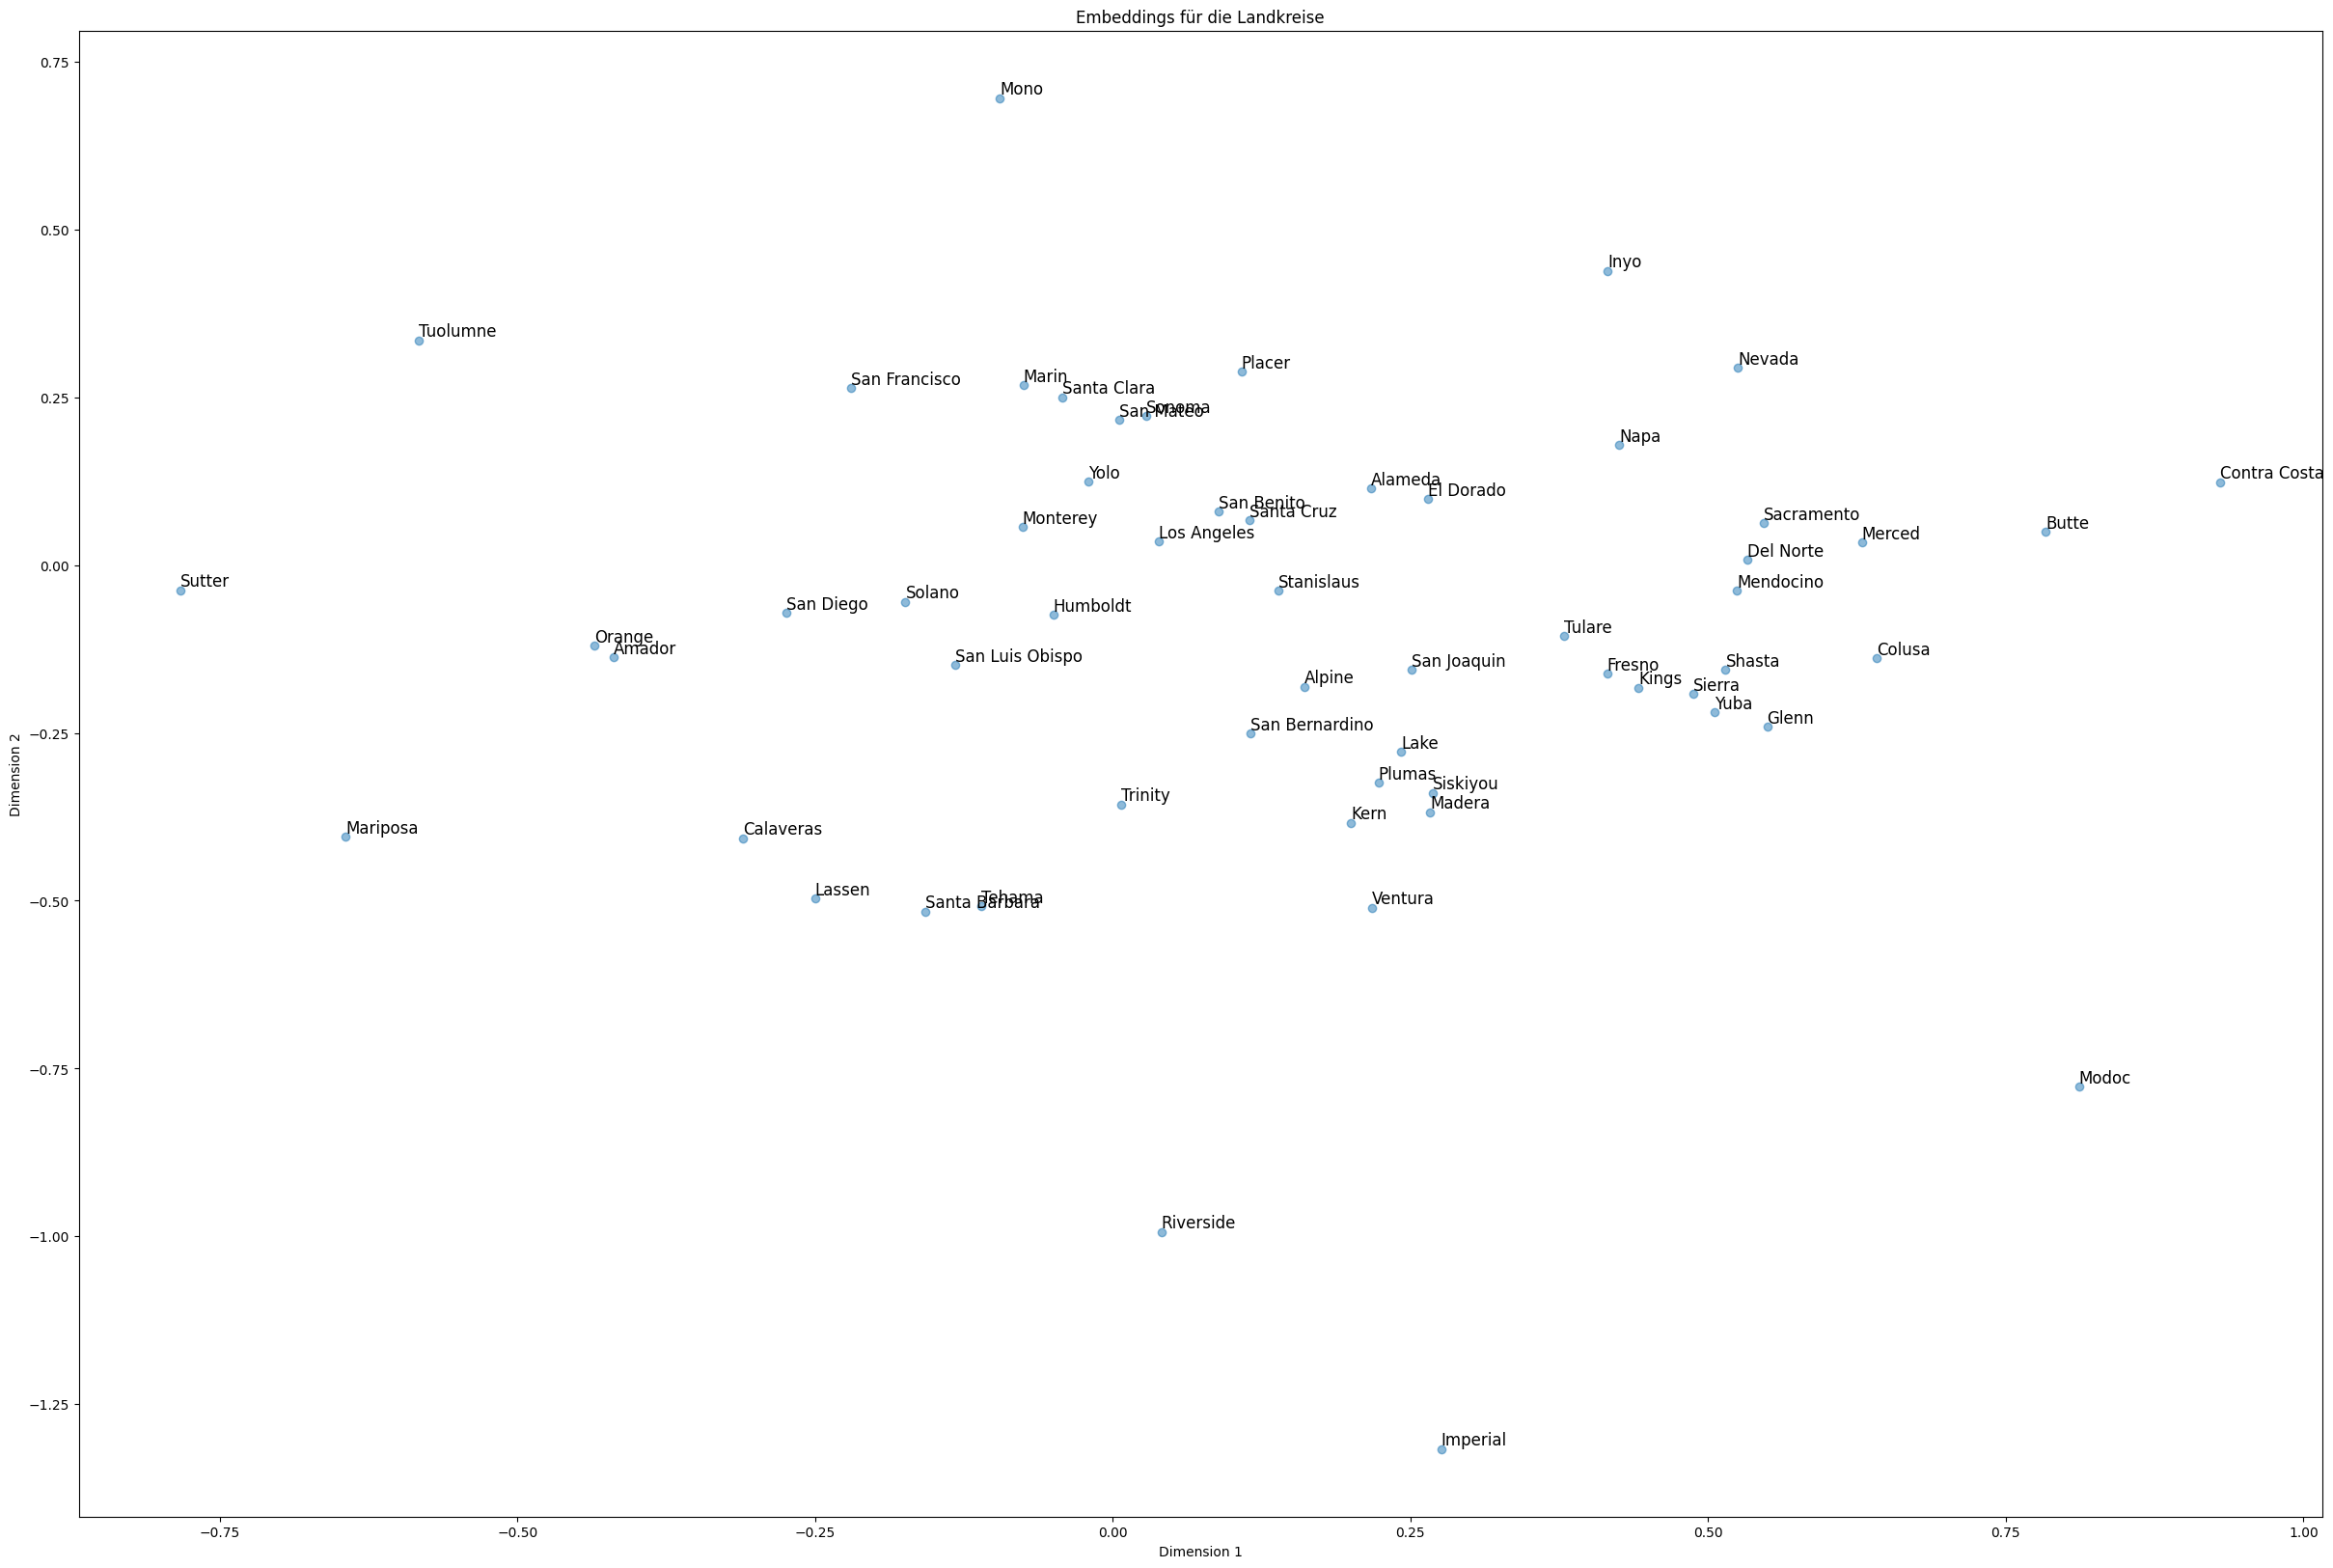

In [150]:
feature_name='county_name'
county_name_embedding = trained_model.layers[3]
county_name_input = trained_model.input[1]
embedding_model_county = keras.models.Model(inputs=county_name_input, outputs=county_name_embedding.output)
plot_embedding(feature_name=feature_name, embedding_model=embedding_model_county, x_train=x_train, title='Embeddings für die Landkreise',x_size=30, y_size=20, fontsize=12)

In [151]:
del ocean_prox_embedding
del ocean_prox_input
del county_name_embedding
del county_name_input

### Aufgabe B-3 d)
> Das in Teilaufgabe a) aufgebaute Netz mit Embeddings soll als „clone“ nochmals, nun aber mit einem anderen Modellnamen und anderen (random) Startgewichten erzeugt, neu gefitted und die Konvergenz überprüft und ggf. hergestellt werden. Die entsprechenden Embedding-Gewichte sind zu extrahieren und in einer verbundenen Grafik den Embeddings aus Teilaufgabe c) gegenüberzustellen (z. B. 2x2 Grafiken über-/nebeneinander) und zu interpretieren.



In [152]:
model_clone = keras.models.clone_model(trained_model)

In [153]:
del trained_model

In [154]:
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
model_clone.compile(optimizer=optimizer,
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

In [155]:
model_clone.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 2)                 10        ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 2)                 116       ['input_2[0][0]']             
                                                                                              

In [156]:
starttime = time.time()
cloned_trained_model, history = train_embed_model(model_clone,x_train,y_train,epochs=2024, name='NN_cloned_GPU',retrain_model=retrain_models,do_save_model=True, verbosity=nn_verbosity)
fittime = time.time() - starttime
if retrain_models:
  times['Cloned Neural Network GPU'] = fittime
  save_times(times)
if 'Cloned Neural Network GPU' in times:
  print("Laufzeit:",times['Cloned Neural Network GPU'],"s")
del model_clone

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Laufzeit: 168.13663697242737 s


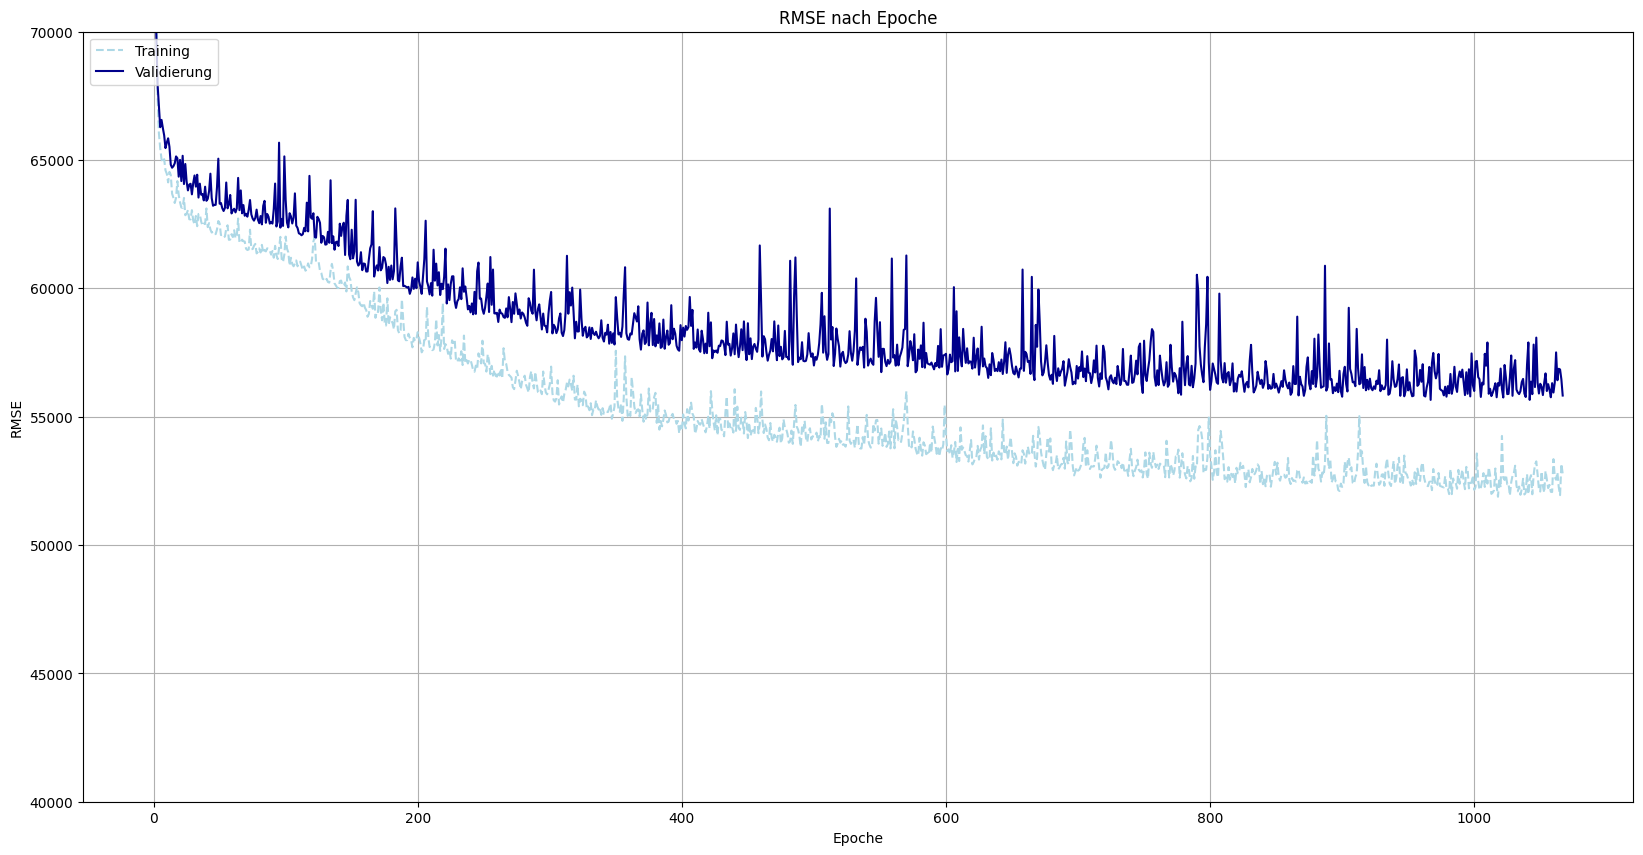

In [157]:
MSE_scaling_factor = (data['median_house_value'].max() - data['median_house_value'].min()) **2
scaled_loss = [math.sqrt(val * MSE_scaling_factor) for val in history.history['mean_squared_error'] ]
scaled_val_loss = [math.sqrt(val * MSE_scaling_factor) for val in history.history['val_mean_squared_error'] ]
plt.figure(figsize=(20, 10))
plt.plot(scaled_loss,linestyle='--',color='lightblue')
plt.plot(scaled_val_loss,linestyle='-',color='darkblue')
plt.title('RMSE nach Epoche')
plt.xlabel('Epoche')
plt.ylabel('RMSE')
plt.grid(True)
plt.ylim(40000,70000)
plt.legend(['Training', 'Validierung'],
            loc='upper left')

In [158]:
feature_name='ocean_proximity'
ocean_prox_embedding = cloned_trained_model.layers[2]
ocean_prox_input = cloned_trained_model.input[0]
embedding_model_ocean_clone = keras.models.Model(inputs=ocean_prox_input, outputs=ocean_prox_embedding.output)

In [159]:
feature_name='county_name'
county_name_embedding = cloned_trained_model.layers[3]
county_name_input = cloned_trained_model.input[1]
embedding_model_county_clone = keras.models.Model(inputs=county_name_input, outputs=county_name_embedding.output)

Gegenüberstellung der Embedding-Grafiken:

2/2 [==============================] - 0s 5ms/step


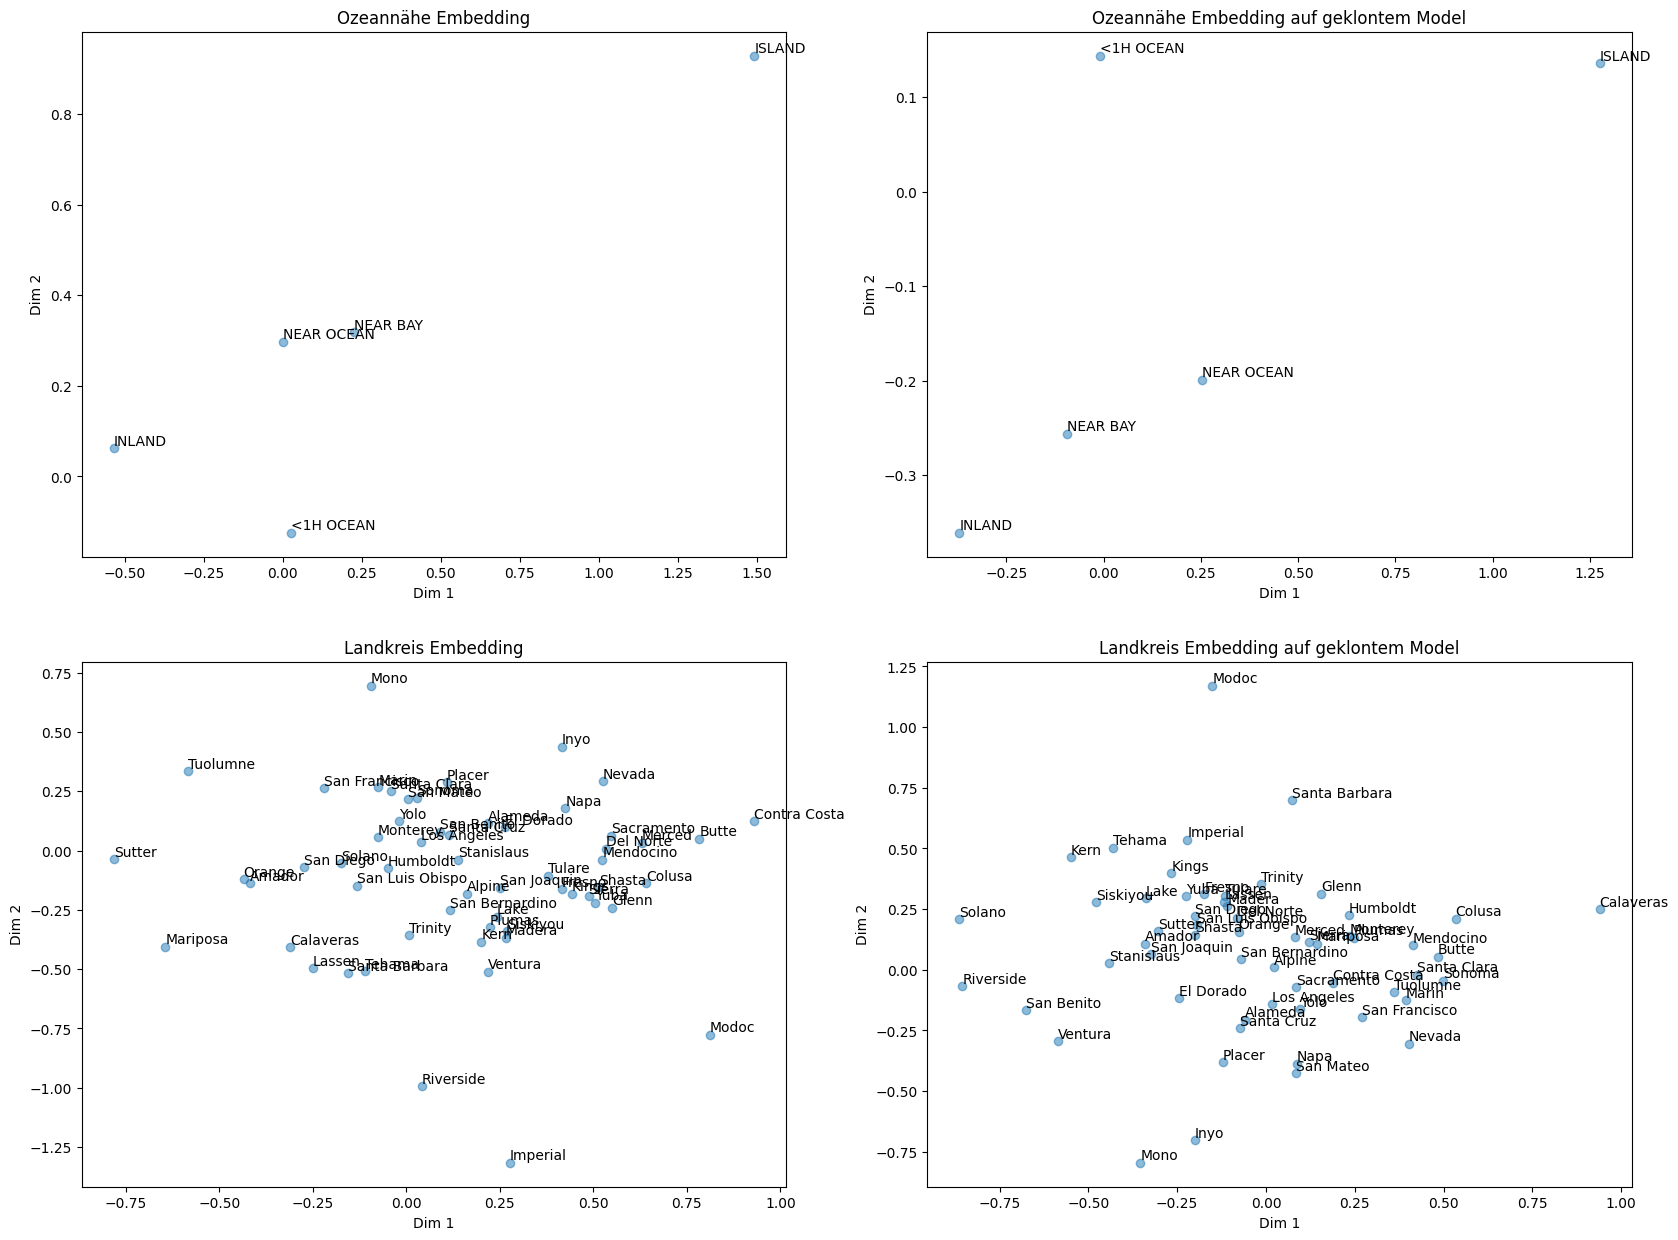

In [160]:
_, axs = plt.subplots(2, 2, figsize=(20, 15))
feature_name = 'ocean_proximity'
series = x_train[feature_name]
x_coords, y_coords, labels = embedding_to_coords(embedding_model_ocean, series)
plot_embed_axis(axs[0,0], x_coords,y_coords, labels, 'Ozeannähe Embedding')
x_coords, y_coords, labels = embedding_to_coords(embedding_model_ocean_clone, series)
plot_embed_axis(axs[0,1], x_coords,y_coords, labels, 'Ozeannähe Embedding auf geklontem Model')
feature_name = 'county_name'
series = x_train[feature_name]
x_coords, y_coords, labels = embedding_to_coords(embedding_model_county, series)
plot_embed_axis(axs[1,0], x_coords,y_coords, labels, 'Landkreis Embedding')
x_coords, y_coords, labels = embedding_to_coords(embedding_model_county_clone, series)
plot_embed_axis(axs[1,1], x_coords,y_coords, labels, 'Landkreis Embedding auf geklontem Model')
plt.show()

Die Embeddings sind durch das erneute Training auf dem geklonten Modell anders, dies ist durch die randomisierten Prozesse im Training zu verantworten. Insbesondere ist es zu erwarten, dass ein gegebenes Embedding bei erneuter Durchführung gespiegelt oder gedreht sein kann, da die Relation der Punkte zueinander für das Modell maßgeblich ist, weniger die absoluten Gewichtswerte.

Dies ist bei den Embeddings für die Ozeannähe insbesondere zu beobachten.
Bei den Landkreisen ist dies nicht eindeutig der Fall, vermutlich gibt es beim Training des neuronalen Netzes noch zu viele Freiheitsgrade. Es deutet sich aber an, dass gewisse Ausprägungen hier in beiden Varianten einen Extrempunkt bilden, also eher am Rand der Grafik erscheinen. Dies lässt zumindest deuten, dass die Dimensionen des Embeddings einen ähnlichen Wert repräsentieren, auf dem die entsprechenden Kategorien entsprechend stark ausschlagen.

In [161]:
del learning_rate
del fittime
del scaled_loss
del scaled_val_loss
del starttime
del x_train
del x_val
del y_train
del y_val
del ocean_prox_embedding
del ocean_prox_input
del county_name_embedding
del county_name_input
del feature_name
del history

In [162]:
del embedding_model_county, embedding_model_county_clone, embedding_model_ocean, embedding_model_ocean_clone

In [163]:
del series

In [164]:
del x_coords, y_coords

In [165]:
del axs

### Aufgabe B-3 e)
> Der RMSE der Validierungsdaten des Netzes aus Teilaufgabe d) ist samt Fitting-Laufzeit zu ermitteln und dem Modellvergleich hinzuzufügen. Die entsprechenden Ergebnisse der beiden Neuronalen Netz mit Embeddings sind miteinander und mit dem Neuronalen Netz aus Aufgabe B-2 b) sowie dem einfachen linearen Modell aus Aufgabe A-7 a) zu vergleichen und zu bewerten.



In [166]:
validation_data=sdata[data['sample']=='B'].sample(frac=1.0, random_state=seed)
x_val=validation_data.drop([target_column,'sample'],axis=1)
y_val=validation_data[target_column]
del validation_data

In [167]:
MSE = cloned_trained_model.evaluate([x_val['ocean_proximity'].cat.codes,x_val['county_name'].cat.codes, x_val[numeric_features].values.astype(float)], y_val.values.astype(float),verbose=0)[1]
RMSE = math.sqrt(MSE_scaling_factor*MSE)
rmses['Cloned Neural Network GPU'] = RMSE
print("RMSE auf Validierungsdaten: ",rmses['Cloned Neural Network GPU'])

RMSE auf Validierungsdaten:  57624.919823973854


In [168]:
print("RMSEs:")
display(rmses)
print("Laufzeiten:")
display(times)

RMSEs:


{'Numeric Linear': 74508.93978488311,
 'Numeric Catboost': 48912.79736396997,
 'Categorical Linear': 91193.2953907611,
 'Categorical Catboost': 89735.68699792186,
 'Complete Linear': 69098.04473488663,
 'Complete Catboost': 48361.638797917374,
 'Scaled Encoded Catboost': 48406.630856312855,
 'Complete Neural Network GPU': 55848.55913419424,
 'Embedding Neural Network GPU': 56440.34458079798,
 'Cloned Neural Network GPU': 57624.919823973854}

Laufzeiten:


{'Complete Linear': 0.172684907913208,
 'Complete CatBoost': 11.55141282081604,
 'Scaled Encoded CatBoost': 4.152780532836914,
 'Complete Neural Network GPU': 127.97513270378113,
 'Embedding Neural Network GPU': 173.1190299987793,
 'Cloned Neural Network GPU': 168.13663697242737}

Als geklontes Netzwerk würde man eigentlich eine identische Performance als bei dem vorherigen Embedded-Modell erwarten. Dies ist allerdings nicht gegeben. Die Laufzeit weicht ebenfalls von der vorherigen Laufzeit ab. Grund dafür ist die große Rolle welche zufällige Effekte, beispielsweise die Startgewichte, im Prozess des Trainings bei neuronalen Netzwerken spielen. Dadurch kann auch die Konvergenz früher oder später einsetzen.

Es bleibt dabei, dass die Embedding-Modelle gegenüber dem Neuronalen Netz mit Encoding ("Compelte Neural Network") eine ähnliche Performance zeigen, aber höhere Laufzeiten benötigen.

Sie haben definitiv eine höhere Vorhersagekraft als das lineare Modell und sind demgegenüber fast ausschließlich zu bevorzugen, zumindest wenn es für das Training keine Echtzeitanforderungen gibt.

In [169]:
del MSE, RMSE
del optimizer

In [170]:
#für Aufgabe B-5
test_data=sdata[data['sample']=='C'].sample(frac=1.0, random_state=seed)
x_test=test_data.drop([target_column,'sample'],axis=1)
y_test=test_data[target_column]
del test_data
MSE = cloned_trained_model.evaluate([x_test['ocean_proximity'].cat.codes,x_test['county_name'].cat.codes, x_test[numeric_features].values.astype(float)], y_test.values.astype(float),verbose=0)[1]
RMSE = math.sqrt(MSE_scaling_factor*MSE)
rmsestest['Cloned Neural Network GPU'] = RMSE
del MSE, RMSE

In [171]:
del MSE_scaling_factor
del esdata, sdata
del cloned_trained_model

## Aufgabe B-4: Hyperparameter-Tuning von lightGBM und XGBoost

### Aufgabe B-4 a)

>Es ist ein lightGBM-Modell inkl. Hypertuning mit mehrdimensionalem Grid Search und vierfacher Kreuzvalidierung zu erstellen. Dabei sind die Parameter learning_rate und num_leaves zu optimieren, für den Parameter n_estimators ist der entsprechende Standardparameter des CatBoost Modells zu verwenden. Die mit dem Grid Search ermittelten besten fünf Parametersätze sind anzuzeigen und zu diskutieren. Im Anschluss ist ein Modell mit den besten Parametern auf allen Folds zu fitten, der Fehler auf den Validierungsdaten zu berechnen und die Ergebnisse dem Modellvergleich hinzuzufügen.

Vorbereiten der Daten: Die numerischen Werte müssen nicht skaliert werden, aber wir machen ein One-Hot-Encoding der Kategorien.

In [172]:
edata=pd.get_dummies(data, columns=categorical_features, drop_first=True)
x_train =edata[edata['sample']=='A'].drop(['sample',target_column],axis=1)
y_train=edata[edata['sample']=='A'][target_column]
x_val =edata[edata['sample']=='B'].drop(['sample',target_column],axis=1)
y_val=edata[edata['sample']=='B'][target_column]
#für Aufgabe B-5
x_test =edata[edata['sample']=='C'].drop(['sample',target_column],axis=1)
y_test=edata[edata['sample']=='C'][target_column]

Hyperparametertuning über learning_rate und num_leaves

In [173]:
parameter = {
    'learning_rate': [0.1,0.11,0.12,0.13,0.14,0.15],
    'num_leaves': [50,60,70,80,90,100]
}

In [174]:
starttime = time.time()
model = lgb.LGBMRegressor(force_row_wise=True,random_state=seed,verbosity=-1)
kfold = sklearn.model_selection.KFold(n_splits=4, shuffle=True, random_state=seed)
grid_search = sklearn.model_selection.GridSearchCV(estimator=model, param_grid=parameter, cv=kfold, scoring='neg_mean_squared_error', verbose=0)
grid_search.fit(x_train, y_train)
param_results = list(zip(grid_search.cv_results_['mean_test_score'], grid_search.cv_results_['params']))
param_results.sort(reverse=True)
best5=param_results[:5]
best_model = lgb.LGBMRegressor(learning_rate=grid_search.best_params_['learning_rate'], num_leaves=grid_search.best_params_['num_leaves'],force_row_wise=True)
best_model.fit(x_train, y_train)
y_pred = best_model.predict(x_val)
fittime = time.time() - starttime
times['lightGBM'] = fittime
save_times(times)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 1428
[LightGBM] [Info] Number of data points in the train set: 14421, number of used features: 56
[LightGBM] [Info] Start training from score 206956.332640


In [175]:
print("Beste 5 Parameter mit negativem MSE: ")
display(best5)
print("Beste weiter verwendete Parameter")
display(best5[0])

Beste 5 Parameter mit negativem MSE: 


[(-2254056480.857634, {'learning_rate': 0.11, 'num_leaves': 70}),
 (-2258871900.292492, {'learning_rate': 0.13, 'num_leaves': 50}),
 (-2261010890.956952, {'learning_rate': 0.1, 'num_leaves': 60}),
 (-2262200461.58615, {'learning_rate': 0.13, 'num_leaves': 60}),
 (-2264451175.4730983, {'learning_rate': 0.12, 'num_leaves': 70})]

Beste weiter verwendete Parameter


(-2254056480.857634, {'learning_rate': 0.11, 'num_leaves': 70})

Die 5 besten Parameterpaare reichen in der Lernrate von 0.1 bis 0.13 und bei der Anzahl der Blätter von 50 bis 70. Insgesamt wurden Lernraten von 0.1 bis 0.15 und Blätterzahlen von 50 bis 100 getestet.
Dass die Lernrate von 0.11 und Blätterzahl 70 das beste Ergebnis erzielt zeigt, dass es keine triviale Verbesserung darstellt, den Suchraum nach oben oder unten zu erweitern. Besseres Hypterparametertuning würde man wahrscheinlich eher durch Verfeinerung des Suchgitters erhalten.

In [176]:
rmses['lightGBM']=math.sqrt(keras.metrics.mean_squared_error(y_pred, y_val))

In [177]:
print("RMSE für LightGBM")
display(rmses['lightGBM'])

RMSE für LightGBM


47584.96967530819

In [178]:
print("Laufzeit:",times['lightGBM'],"s")

Laufzeit: 40.6359601020813 s


In [179]:
iterations = len(grid_search.cv_results_)

In [180]:
#für Aufgabe B-5:
y_pred = best_model.predict(x_test)
rmsestest['lightGBM']=math.sqrt(keras.metrics.mean_squared_error(y_pred, y_test))

In [181]:
del model
del kfold
del grid_search
del param_results
del best5
del best_model
del y_pred

In [182]:
del edata

In [183]:
del starttime
del fittime
del parameter

### Aufgabe B-4 b)
>Analog ist ein XGBoost-Modell inkl. Hypertuning mit mehrdimensionalem Random Search und vierfacher Kreuzvalidierung zu erstellen. Dabei sind die Parameter depth, learning_rate, subsample und colsample_bytree zu optimieren. Dabei ist die gleiche Anzahl Iterationen wie bei CatBoost und lightGBM zu verwenden. Die mit dem Randomized Search ermittelten besten fünf Parameterkombinationen sind anzuzeigen und zu diskutieren. Im Anschluss ist ein Modell mit den besten Parametern auf allen Folds zu fitten, der Fehler auf den Validierungsdaten zu berechnen und die Ergebnisse dem Modellvergleich hinzuzufügen.

Wir nehmen wieder die unskalierten aber One-Hot-Codierten Daten aus der vorherigen Aufgabe

In [184]:
parameter = {
    'max_depth': range(3, 16),
    'learning_rate': [0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.2],
    'subsample': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
    'colsample_bytree': [0.5,0.6,0.7,0.8,0.9,1.0]
}
display(parameter)

{'max_depth': range(3, 16),
 'learning_rate': [0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2],
 'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
 'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}

Selbe Anzahl Iterationen wie bei lightGBM

In [185]:
print(iterations)

14


In [186]:
starttime = time.time()
model = xgb.XGBRegressor(random_state=seed)
kfold = sklearn.model_selection.KFold(n_splits=4, shuffle=True, random_state=seed)
random_search = sklearn.model_selection.RandomizedSearchCV(estimator=model, param_distributions=parameter, n_iter=iterations, cv=kfold, scoring='neg_mean_squared_error', random_state=seed)
random_search.fit(x_train, y_train)
param_results = list(zip(random_search.cv_results_['mean_test_score'], random_search.cv_results_['params']))
param_results.sort(reverse=True)
best5=param_results[:5]
best_model = xgb.XGBRegressor(**random_search.best_params_)
best_model.fit(x_train, y_train)
y_pred = best_model.predict(x_val)
fittime = time.time() - starttime
times['XGBoost'] = fittime
save_times(times)

In [187]:
print("Beste 5 Parameterkombinationen mit negativem MSE: ")
display(best5)
print("Beste weiter verwendete Parameterkombination")
display(best5[0])

Beste 5 Parameterkombinationen mit negativem MSE: 


[(-2299911921.8627796,
  {'subsample': 0.9,
   'max_depth': 12,
   'learning_rate': 0.14,
   'colsample_bytree': 0.5}),
 (-2307266024.92968,
  {'subsample': 0.5,
   'max_depth': 10,
   'learning_rate': 0.06,
   'colsample_bytree': 0.9}),
 (-2310193416.0413957,
  {'subsample': 0.7,
   'max_depth': 15,
   'learning_rate': 0.08,
   'colsample_bytree': 0.8}),
 (-2321955486.9425,
  {'subsample': 0.7,
   'max_depth': 13,
   'learning_rate': 0.12,
   'colsample_bytree': 0.9}),
 (-2377892832.5986333,
  {'subsample': 0.6,
   'max_depth': 14,
   'learning_rate': 0.16,
   'colsample_bytree': 0.6})]

Beste weiter verwendete Parameterkombination


(-2299911921.8627796,
 {'subsample': 0.9,
  'max_depth': 12,
  'learning_rate': 0.14,
  'colsample_bytree': 0.5})

Die besten 5 Parametergruppen reichen bei den Teilstichproben zwischen 0.5 und 0.9, Maximaltiefe zwischen 10 und 15, Lernrate zwischen 0.06 und 0.14 und die baumweise Spaltenwahl zwischen 0.5 und 0.9.
Die beste Parametergruppe liegt bis auf die Spaltenwahl innerhalb der Grenzen und auch bei der Spaltenwahl lässt sich in den Top 5 keine Monotonie erkennen, womit das Tuning auch hier nicht trivialerweise verbessert werden kann, indem die Grenzen erweitert werden.

In [188]:
rmses['XGBoost']=math.sqrt(sklearn.metrics.mean_squared_error(y_pred, y_val))
print("RMSE für XGBoost")
display(rmses['XGBoost'])

RMSE für XGBoost


50459.16902941104

In [189]:
print("Laufzeit:",times['XGBoost'],"s")

Laufzeit: 114.91345286369324 s


In [190]:
#für Aufgabe B-5:
y_pred = best_model.predict(x_test)
rmsestest['XGBoost']=math.sqrt(keras.metrics.mean_squared_error(y_pred, y_test))

In [191]:
del model
del kfold
del param_results
del best5
del best_model
del y_pred

In [192]:
del starttime, fittime
del iterations
del parameter
del random_search
del x_train, x_val
del y_train, y_val
del x_test, y_test
del labels

### Aufgabe B-4 c)
>Abschließend ist der Aufwand und der Nutzen der hier optimierten Modelle gegenüber dem CatBoost-Modell aus Aufgabe A-7 b) zu bewerten.

In [193]:
rmses

{'Numeric Linear': 74508.93978488311,
 'Numeric Catboost': 48912.79736396997,
 'Categorical Linear': 91193.2953907611,
 'Categorical Catboost': 89735.68699792186,
 'Complete Linear': 69098.04473488663,
 'Complete Catboost': 48361.638797917374,
 'Scaled Encoded Catboost': 48406.630856312855,
 'Complete Neural Network GPU': 55848.55913419424,
 'Embedding Neural Network GPU': 56440.34458079798,
 'Cloned Neural Network GPU': 57624.919823973854,
 'lightGBM': 47584.96967530819,
 'XGBoost': 50459.16902941104}

In [194]:
times

{'Complete Linear': 0.172684907913208,
 'Complete CatBoost': 11.55141282081604,
 'Scaled Encoded CatBoost': 4.152780532836914,
 'Complete Neural Network GPU': 127.97513270378113,
 'Embedding Neural Network GPU': 173.1190299987793,
 'Cloned Neural Network GPU': 168.13663697242737,
 'lightGBM': 40.6359601020813,
 'XGBoost': 114.91345286369324}

lightGBM hat in diesem Fall sowohl eine kürzere Laufzeit als auch ein besseres Ergebnis beim RMSE erzielt. Dies kann am gewählten Hyperparameter-Suchbereich liegen. In jedem Fall performenen beide sehr ähnlich. Von der Laufzeit her scheint lightGBM dem Namen entsprechend eine kürzere Laufzeit als XGBoost zu verzeichnen. Im Kontext dieser Aufgabe ist also in beiden Aspekten lightGBM gegenüber XGBoost zu bevorzugen.

Im Vergleich zu CatBoost hat zwar lightGBM ein leicht besseres Ergebnisse erzielt, lightGBM und XGboost benötigten dafür aber ein Hyperparameter-Tuning, während Catboost diese Leistung bereits mit Default-Parametern erzielte.

Zusammenfassend erscheint bei der Möglichkeit zum aufwendigen Tuning bei dieser Aufgabe lightGBM als bestes Modell hervorzugehen. Wenn es darum geht ohne weitere Konfiguration gute und schnelle Ergebnisse zu erzielen ist allerdings CatBoost der Favorit.

## Aufgabe B-5: Finale Modellbewertung an Testdaten

### Aufgabe B-5 a)
>Das CatBoost-Modell aus Aufgabe A-7 sowie alle im Teil B des Notebooks enthaltenen Modelle sind abschließend mit den Testdaten (sample = C) zu bewerten und die Ergebnisse in den Testdaten abzulegen.

In den folgenden Grafiken bezeichnet

* "Numerical Linear" das lineare Modell auf den numerischen Testdaten
* "Categorical Linear" das lineare Modell auf den kategoriellen Testdaten
* "Complete Linear" das lineare Modell auf allen Testdaten
* "Numerical Catboost" das Catboost-Modell auf den numerischen Testdaten
* "Categorical Catboost" das Catboost-Modell auf den kategoriellen Testdaten
* "Complete Catboost" das Catboost-Modell auf allen Testdaten
* "Complete Neural Network" das neuronale Netzwerk mit One-Hot-Codierung auf allen Testdaten
* "Embedding Neural Network" das erste neuronale Netzwerk mit Embedding auf allen Testdaten
* "Cloned Neural Network" das zweite neuronale Netzwerk mit Embedding auf allen Testdaten

Die Ergebnisse auf den Testdaten wurden bereits während der vorherigen Aufgabenteile zusammengestellt:

In [195]:
print('RMSEs auf den Testdaten:')
rmsestest

RMSEs auf den Testdaten:


{'Complete Catboost': 45427.075729708304,
 'Scaled Encoded Catboost': 46154.39938978077,
 'Complete Neural Network GPU': 54340.25322784039,
 'Embedding Neural Network GPU': 54123.96676776603,
 'Cloned Neural Network GPU': 55075.31593666789,
 'lightGBM': 45852.00825481911,
 'XGBoost': 48551.297191733196}

### Aufgabe B-5 b):


> Die Modellgüte der Modelle ist grafisch aufzubereiten. Welche Modelle haben die beste Prognosegüte? Gibt es im Hinblick auf Prognosegüte, Optimierungsaufwand und Laufzeit ein besonders geeignetes und empfehlenswertes Modell?


In den folgenden Grafiken bezeichnet

* "Numerical Linear" das lineare Modell auf den numerischen Testdaten
* "Categorical Linear" das lineare Modell auf den kategoriellen Testdaten
* "Complete Linear" das lineare Modell auf allen Testdaten
* "Numerical Catboost" das Catboost-Modell auf den numerischen Testdaten
* "Categorical Catboost" das Catboost-Modell auf den kategoriellen Testdaten
* "Complete Catboost" das Catboost-Modell auf allen Testdaten
* "Complete Neural Network" das neuronale Netzwerk mit One-Hot-Codierung auf allen Testdaten
* "Embedding Neural Network" das erste neuronale Netzwerk mit Embedding auf allen Testdaten
* "Cloned Neural Network" das zweite neuronale Netzwerk mit Embedding auf allen Testdaten

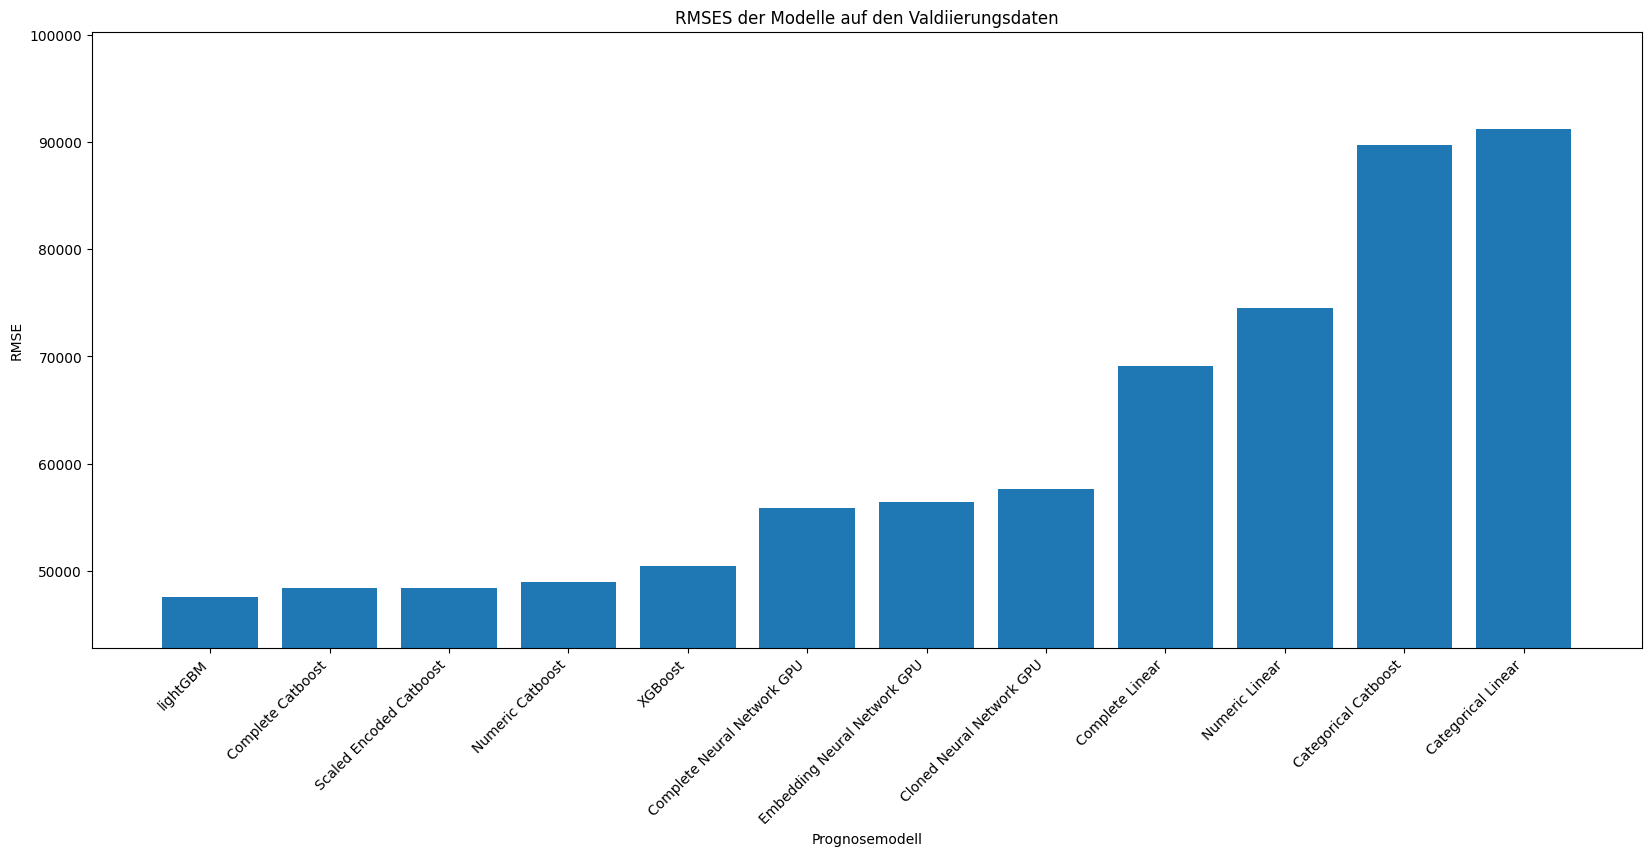

In [196]:
sorted_rmses = sorted(rmses.items(), key=lambda x: x[1])
modelle = [item[0] for item in sorted_rmses]
rmse_values = [item[1] for item in sorted_rmses]
plt.figure(figsize=(20, 8))
plt.bar(modelle, rmse_values)
plt.xlabel('Prognosemodell')
plt.ylabel('RMSE')
plt.title('RMSES der Modelle auf den Valdiierungsdaten')
plt.ylim(0.9*min(rmse_values), 1.1*max(rmse_values))
plt.xticks(rotation=45, ha='right')
plt.show()

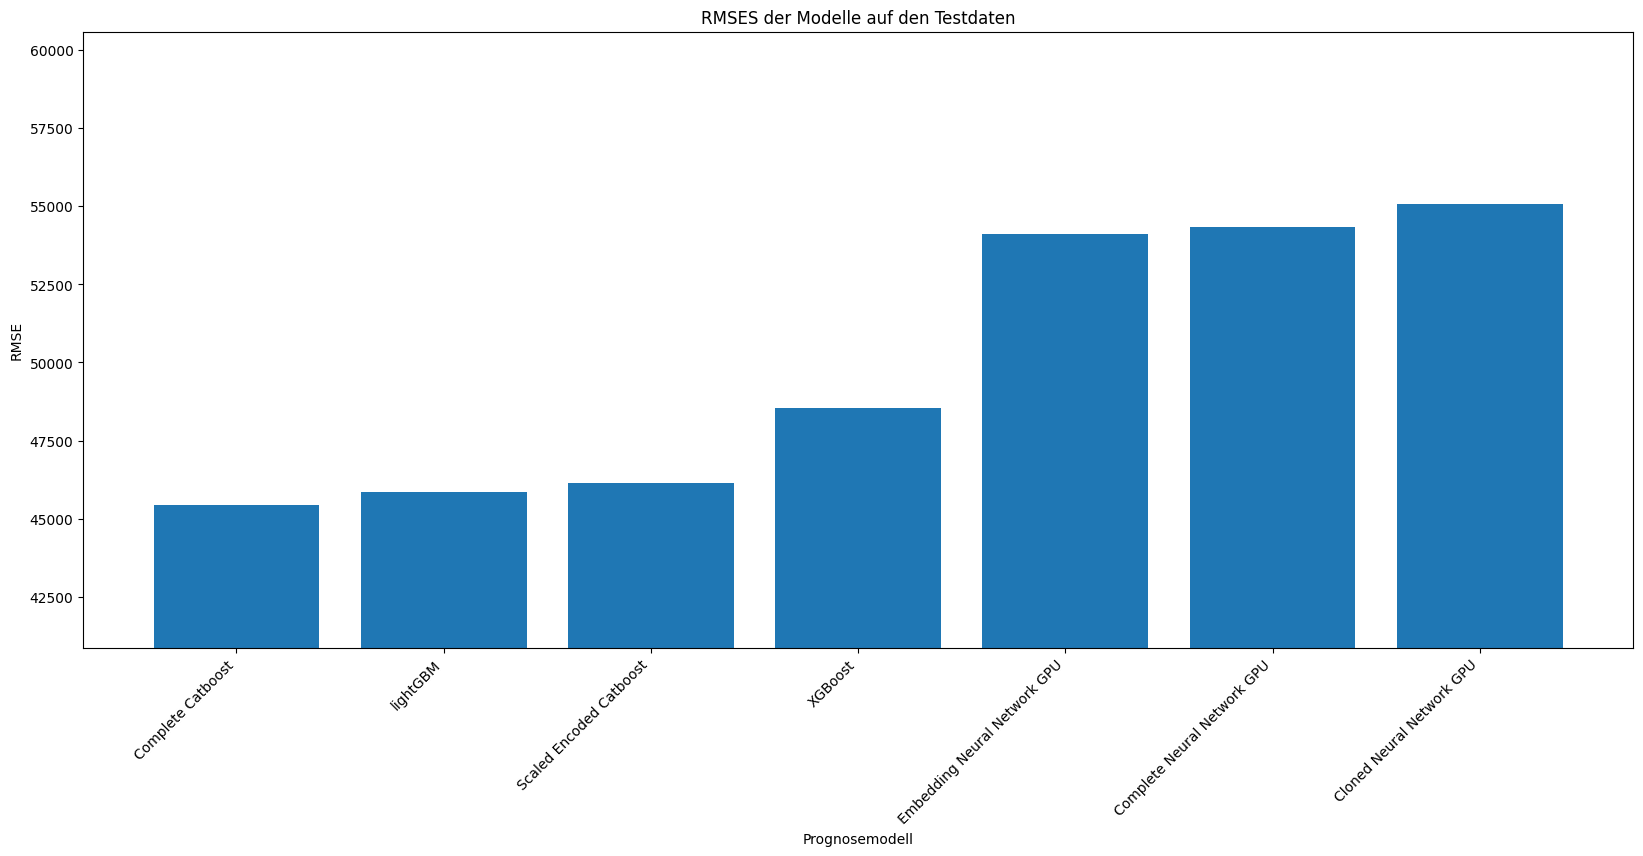

In [197]:
sorted_rmses = sorted(rmsestest.items(), key=lambda x: x[1])
modelle = [item[0] for item in sorted_rmses]
rmse_values = [item[1] for item in sorted_rmses]
plt.figure(figsize=(20, 8))
plt.bar(modelle, rmse_values)
plt.xlabel('Prognosemodell')
plt.ylabel('RMSE')
plt.title('RMSES der Modelle auf den Testdaten')
plt.ylim(0.9*min(rmse_values), 1.1*max(rmse_values))
plt.xticks(rotation=45, ha='right')
plt.show()

Die auf Ensemble-Trees basierten Modelle schneiden insgesamt besser ab als die Modelle der neuronalen Netze. Es ist nicht auszuschließen, dass die neuronalen Netze durch feinere Justierung und mehr Tuning- und Trainingsaufwand besser abschneiden würden.
Unter den Ensemble-Baum-Modellen heben sich Out-of-the-box Catboost und lightGBM besonders durch einen niedrigen Fehler hevor. Auch hier ist es wieder möglich, dass XGBoost nur aufgrund unseres Hyperparameter-Tunings zurückbleibt. In Angesicht der Tatsache, dass für lightGBM zunächst ein Hyperparameter-Tuning notwendig war ist hier CatBoost mit Default-Parametern das besonders empfehlenswerte Modell.

In [198]:
del sorted_rmses
del rmse_values
del modelle

# Teil C: Clustering unter Verwendung von Feuergefährdungszonen

## Aufgabe C-1: Erweiterung des Hauptdatensatzes um Feuergefährdungszonen

### Aufgabe C-1 a)

> Der Datensatz california_fire_zones.shp ist einzulesen (siehe Anhang 1), im Anschluss sind 10 zufällige Zeilen davon auszugeben. Die absolute Häufigkeitsverteilung der Werte des Merkmals FHSZ ist zu erstellen. Weiter ist eine Funktion zu schreiben, welche für ein gegebenes Polygon die Anzahl an Eckpunkten zurückgibt. Unter Verwendung dieser Funktion ist ein Histogramm zur Anzahl an Eckpunkten der Polygone des eingelesenen Datensatzes zu erstellen, bei welchem die x-Achse logarithmiert dargestellt wird, und zu kommentieren. Schließlich ist ein Plot der Feuergefährdungszonen zu erzeugen und mit einer Karte von Kalifornien zu hinterlegen.



Einlesen der Daten und Umkodierung der Ortsdarstellung via Längen- und Breitengrade

In [199]:
firezones = gpd.read_file(folder_path+'california_fire_zones.shp').to_crs(epsg=4326)

In [200]:
firezones.sample(10, random_state=seed)

FHSZ FHSZ_Descr    Shape_Leng    Shape_Area  \
1092     3  Very High  2.289474e+04  6.115388e+06   
468      2       High  2.194811e+04  5.640945e+06   
1332     3  Very High  1.382022e+04  5.107807e+06   
827      2       High  1.926041e+04  4.366668e+06   
929      3  Very High  1.574675e+04  3.785108e+06   
699      2       High  1.643052e+05  2.190773e+07   
377      2       High  1.192624e+05  1.240135e+07   
1066     3  Very High  1.923844e+06  2.043624e+09   
447      2       High  3.594848e+04  6.195179e+06   
1454     3  Very High  1.017415e+05  3.337294e+07   

                                               geometry  
1092  POLYGON ((-119.53744 37.30656, -119.54267 37.3...  
468   POLYGON ((-117.94386 36.16922, -117.94392 36.1...  
1332  POLYGON ((-120.98480 40.58090, -120.98452 40.5...  
827   POLYGON ((-121.30206 41.37308, -121.30207 41.3...  
929   POLYGON ((-117.82993 34.06540, -117.82984 34.0...  
699   POLYGON ((-121.51306 39.60514, -121.51212 39.6...  
377   POLYGON ((-117.04513 33.48070, -117.04514 33.4...  
1066  POLYGON ((-121.63036 36.58334, -121.63034 36.5...  
447   POLYGON ((-118.47049 35.64034, -118.47050 35.6...  
1454  POLYGON ((-120.54643 41.53049, -120.54679 41.5...

In [201]:
firezones['FHSZ'].value_counts()

FHSZ
3    627
2    519
1    361
Name: count, dtype: int64

Anzahl der Ecken per Polygon zusammenstellen

In [202]:
cornercounts = firezones['geometry'].apply(ncornerpoints)
cornercounts.describe()

count      1507.000000
mean       2018.330458
std        6613.219157
min           7.000000
25%         267.500000
50%         618.000000
75%        1295.500000
max      107983.000000
Name: geometry, dtype: float64

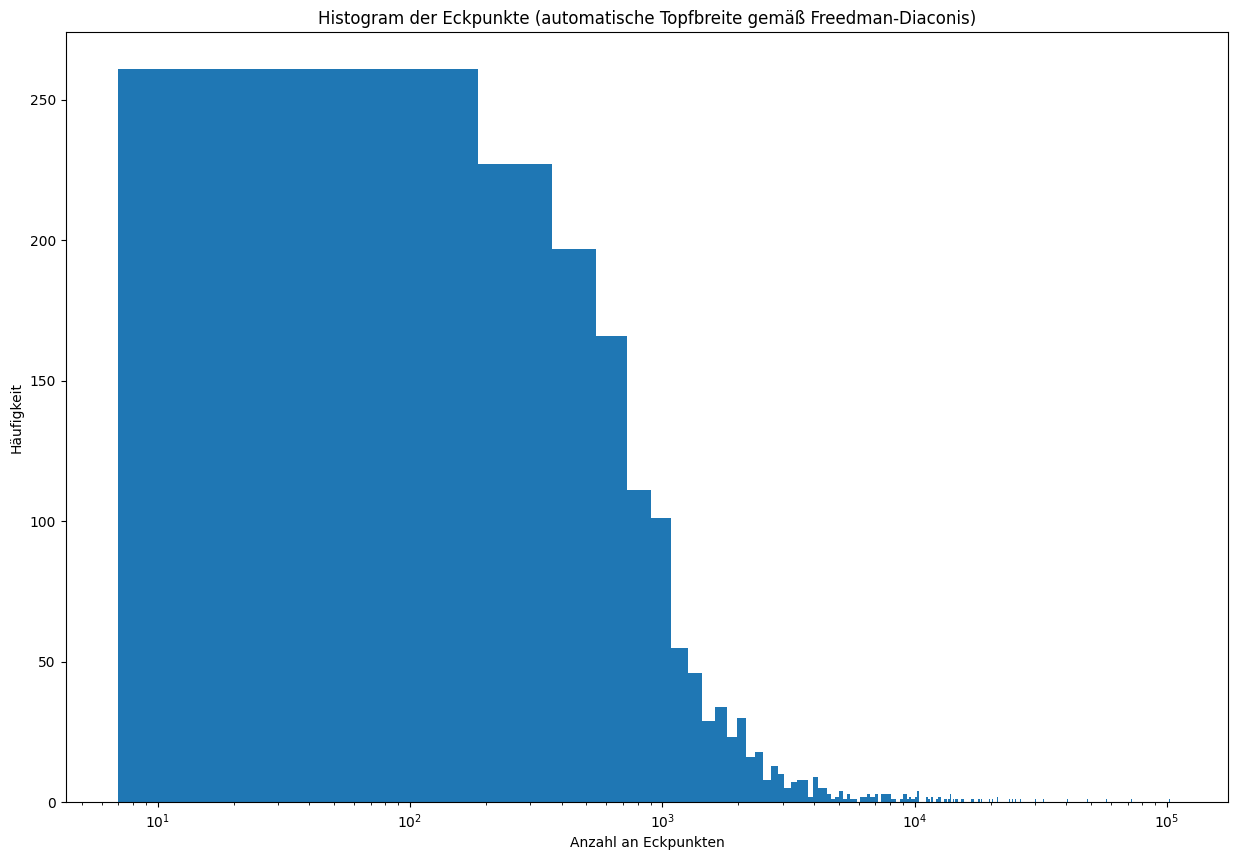

In [203]:
plt.figure(figsize=(15, 10))
plt.hist(cornercounts, bins='auto')
plt.xscale('log')
plt.xlabel('Anzahl an Eckpunkten')
plt.ylabel('Häufigkeit')
plt.title('Histogram der Eckpunkte (automatische Topfbreite gemäß Freedman-Diaconis)')
plt.show()

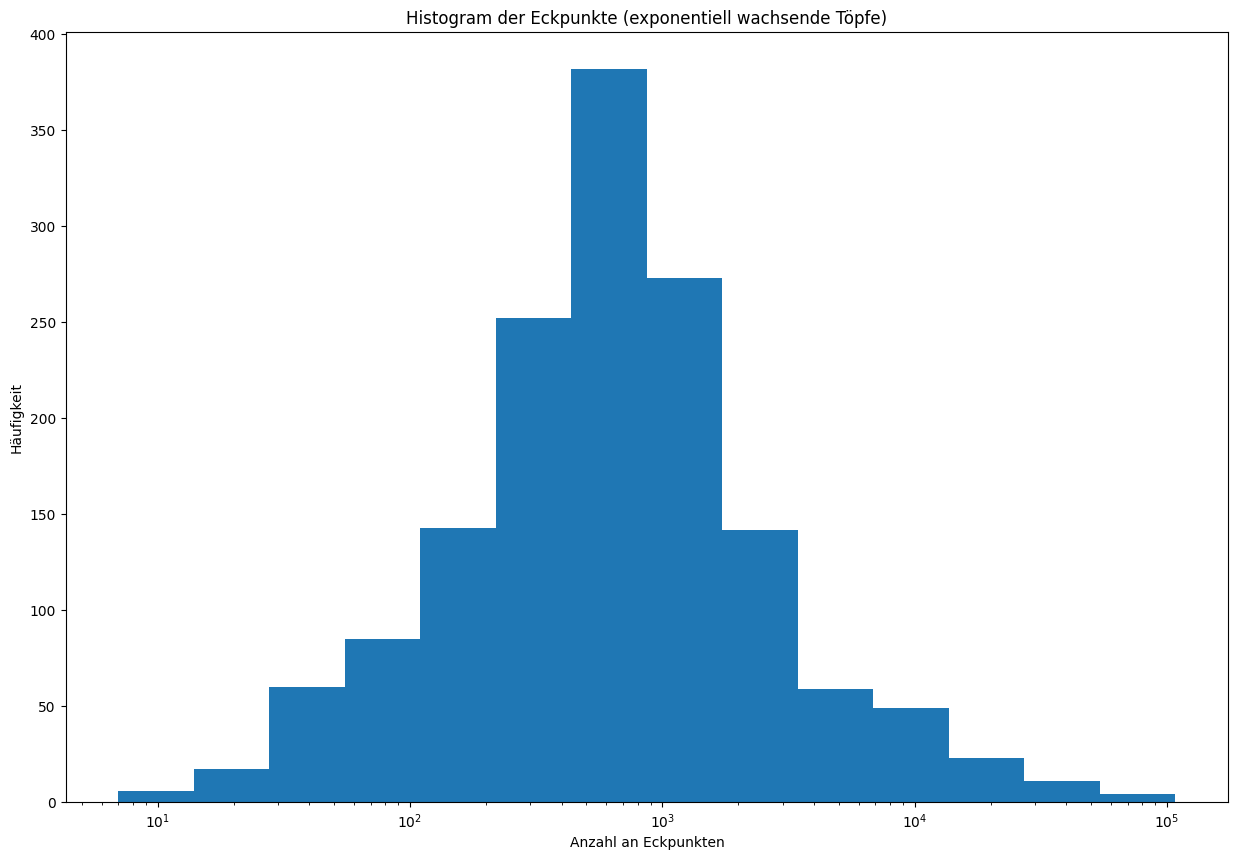

In [204]:
logbins = np.logspace(np.log10(cornercounts.min()), np.log10(cornercounts.max()), num=15)
plt.figure(figsize=(15, 10))
plt.hist(cornercounts, bins=logbins)
plt.xscale('log')
plt.xlabel('Anzahl an Eckpunkten')
plt.ylabel('Häufigkeit')
plt.title('Histogram der Eckpunkte (exponentiell wachsende Töpfe)')
plt.show()

Die Anzahl der Ecken der Polygone schwank stark, von 7 bis über 100000. Die Mehrzahl der Polygone hat weniger als 1000 Ecken.

Mit steigender Anzahl an Eckpunkten gibt es immer weniger Polygone, welche diese repräsentieren. Wenn man die Töpfe exponentiell wachsen lässt zeigt sich eine Art Normalvertielung mit Peak bei ca. 500, d.h. der Logarithmus der Polygonecken ist annähernd normalverteilt.

In [205]:
del cornercounts

In [206]:
del logbins

In [207]:
california_img_path = folder_path+'california.png'
cal_img = plt.imread(california_img_path)

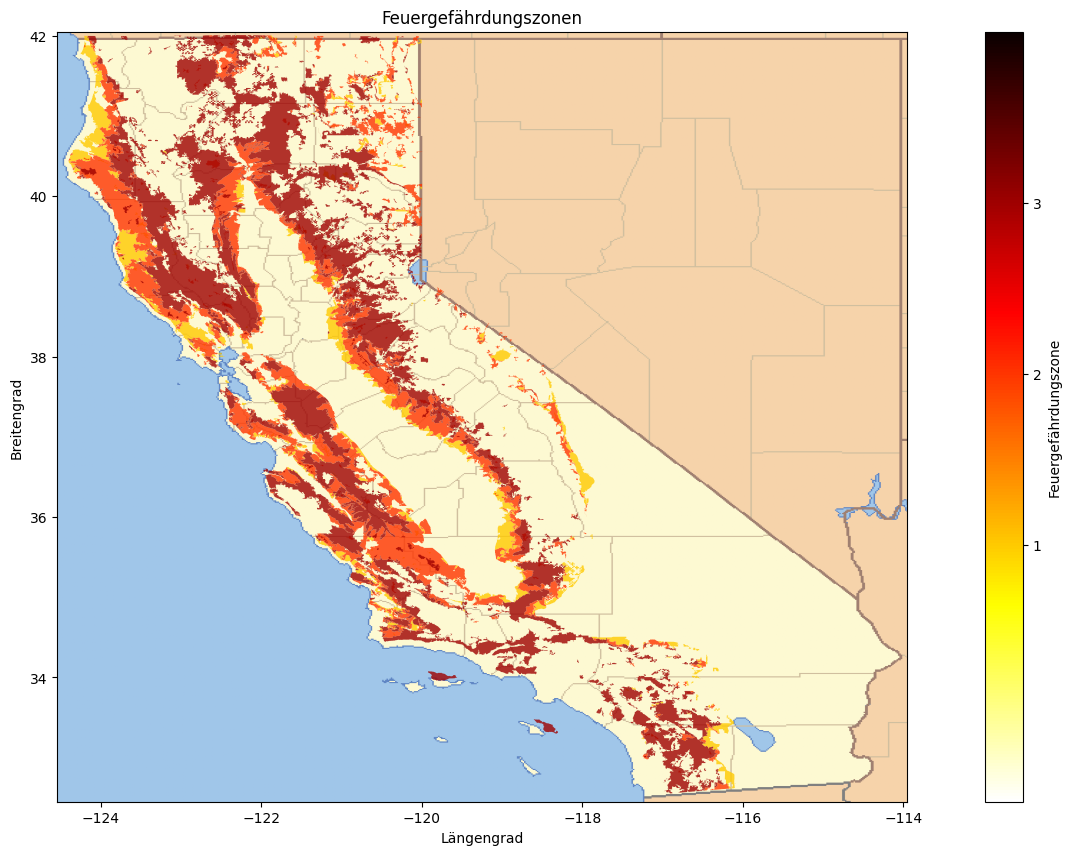

In [208]:
legend_values = [1, 2, 3]
firezones.plot(column='FHSZ', figsize=(20, 10),legend=True,cmap=plt.cm.hot_r,vmin=-0.5, vmax=4, alpha=0.8,legend_kwds={'ticks': legend_values, 'label': 'Feuergefährdungszone'})
plt.xlabel('Längengrad')
plt.ylabel('Breitengrad')
plt.title('Feuergefährdungszonen')
axisrange = [-124.55, -113.95, 32.45, 42.05]
plt.axis(axisrange)
plt.imshow(cal_img, extent=axisrange)
plt.show()

In [209]:
del axisrange, legend_values

### Aufgabe C-1 b):

> Der Hauptdatensatz, der nach der Bearbeitung von Teil A vorliegt, ist um die in Teilaufgabe a) eingelesenen Feuergefährdungszonen zu erweitern. Zu diesem Zweck soll festgestellt werden, ob und ggf. in welcher Feuergefährdungszone die Longitude-Latitude-Paare der einzelnen Zeilen liegen. Das Resultat ist in der neuen Spalte fire_zone abzuspeichern. Liegt ein Longitude-Latitude-Paar in keiner Feuergefährdungszone, so ist als Wert 0 einzutragen. Liegt ein Longitude-Latitude-Paar in mehr als einer Feuergefährdungszone, so ist eine aktuariell angemessene Lösungsstrategie zu diesem Problem durchzuführen. Schließlich soll das Ergebnis überprüft werden, indem ein geeigneter Scatter-Plot der Daten erzeugt wird.



In [210]:
data_geometry = gpd.GeoDataFrame(geometry=gpd.points_from_xy( data['longitude'], data['latitude']),crs=firezones.crs)
data_geometry['data_index']= data.index

In [211]:
matchingfirezones = gpd.sjoin(data_geometry, firezones, how="left", predicate="within")
matchingfirezones.reset_index(drop=True)

geometry  data_index  index_right  FHSZ FHSZ_Descr  \
0      POINT (-117.04000 32.54000)           0          NaN   NaN        NaN   
1      POINT (-117.09000 32.55000)           1          NaN   NaN        NaN   
2      POINT (-117.06000 32.55000)           2          NaN   NaN        NaN   
3      POINT (-117.04000 32.55000)           3          NaN   NaN        NaN   
4      POINT (-117.12000 32.56000)           4          NaN   NaN        NaN   
...                            ...         ...          ...   ...        ...   
20667  POINT (-121.93000 41.86000)       20635          NaN   NaN        NaN   
20668  POINT (-123.83000 41.88000)       20636          NaN   NaN        NaN   
20669  POINT (-124.16000 41.92000)       20637          NaN   NaN        NaN   
20670  POINT (-124.14000 41.95000)       20638       1506.0   3.0  Very High   
20671  POINT (-122.64000 41.95000)       20639       1503.0   3.0  Very High   

         Shape_Leng    Shape_Area  
0               NaN           NaN  
1               NaN           NaN  
2               NaN           NaN  
3               NaN           NaN  
4               NaN           NaN  
...             ...           ...  
20667           NaN           NaN  
20668           NaN           NaN  
20669           NaN           NaN  
20670  8.494362e+04  6.690529e+07  
20671  1.385404e+06  9.765650e+08  

[20672 rows x 7 columns]

In [212]:
print("Anzahl Datenpunkte:",len(data_geometry))
print("Feurzonen-Überlappungen:",len(matchingfirezones))

Anzahl Datenpunkte: 20640
Feurzonen-Überlappungen: 20672


Es gibt also Datenpunkte, welche in mehreren Feuerzonen liegen.

Bei mehreren Zonen pro Datenpunkt wählen wir die höchste Gefährdungsstufe



In [213]:
data_to_firezone = matchingfirezones.groupby('data_index')['FHSZ'].max().fillna(0).rename('fire_zone', inplace=True)
fdata = pd.merge(data, data_to_firezone, left_index=True, right_on='data_index')
print("Anzahl Datenpunkte mit Feuerzone:",len(fdata))

Anzahl Datenpunkte mit Feuerzone: 20640


Scatterplot aller Datensätze, mit farblicher Codierung der Feuergefährdung

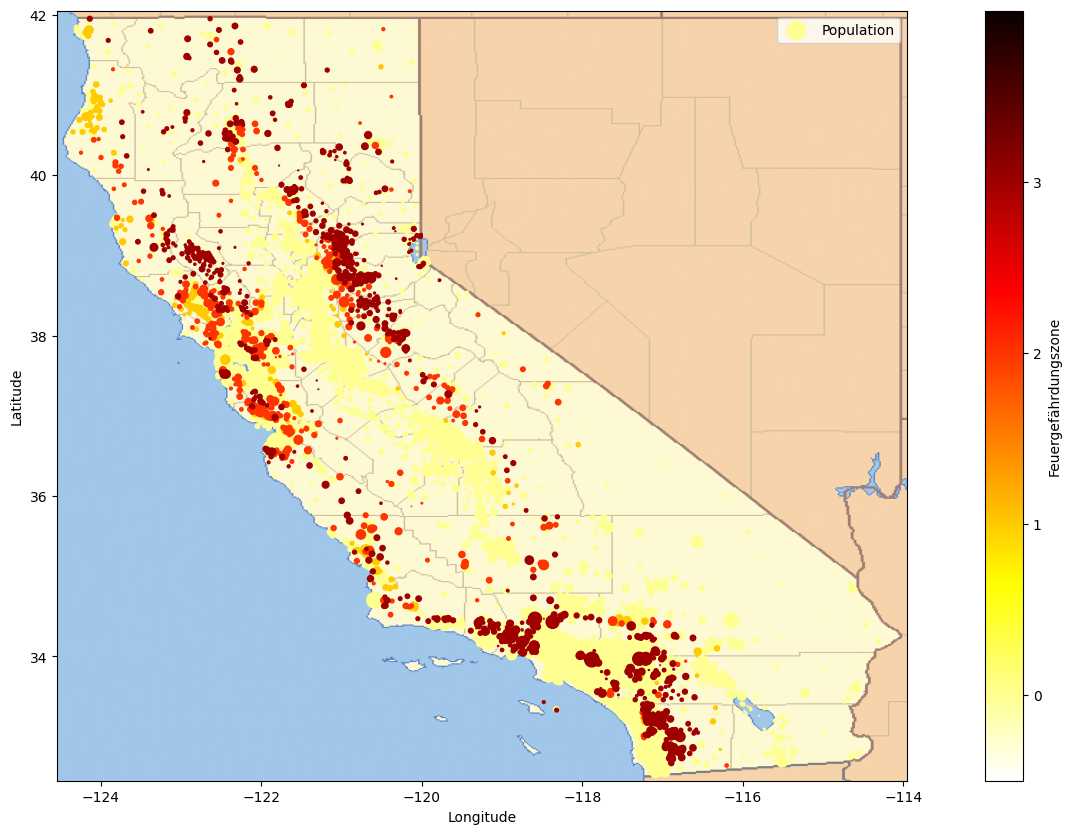

In [214]:
  # Datensatz sortieren, damit der Plot immer die höchste Feuerzone zeigt
  fdata_sorted=fdata.sort_values(by='fire_zone')
  plot_axis =fdata_sorted.plot(
             kind="scatter", x="longitude", y="latitude",
             s=fdata_sorted["population"] / 100,
             xlabel="Longitude", ylabel="Latitude",
             label="Population",
             c=fdata_sorted['fire_zone'], cmap=plt.cm.hot_r,vmin=-0.5, vmax=4,
             colorbar=True,
             legend=True,
             sharex=False, figsize=(20, 10))
  plot_axis.collections[0].colorbar.set_label('Feuergefährdungszone')
  legend_values = [0, 1, 2, 3]
  plot_axis.collections[0].colorbar.set_ticks(legend_values)
  axisrange = [-124.55, -113.95, 32.45, 42.05]
  plt.axis(axisrange)
  plt.imshow(cal_img, extent=axisrange)
  plt.show()
  del fdata_sorted, legend_values

Man erkennt hier eindeutig die gleiche Farbverteilung wie im Plot der Feuergefährdungszonen

In [215]:
del data_geometry, data_to_firezone
del firezones
del matchingfirezones
del plot_axis

## Aufgabe C-2: Einsatz von Clustering bei der Tarifierung von Feuerversicherung

### Aufgabe C-2 a)
>Um den aus Aufgabe C-1 erhaltenen Datensatz zu clustern, ist der k-Means-Algorithmus anzuwenden. In das Clustering sollen lediglich die Merkmale latitude, longitude, median_house_value und fire_zone einfließen. Die Wahl der Cluster-Anzahl ist (etwa durch eine geeignete Heuristik) zu begründen. Ein Scatter-Plot zur Visualisierung der Cluster ist zu erzeugen.



In [216]:
cdata = fdata[['latitude', 'longitude','median_house_value','fire_zone']]

Wir plotten die Silhouettenkoeffizienten um eine Idee für eine gute Clusteranzahl zu erhalten

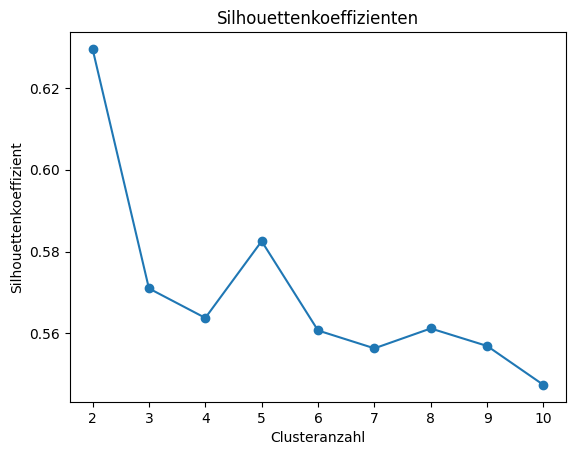

In [217]:
candidates = range(2, 11)
scores = []
for candidate in candidates:
    kmeans = sklearn.cluster.KMeans(n_clusters=candidate, random_state=seed, n_init='auto')
    cluster_labels = kmeans.fit_predict(cdata)
    score = sklearn.metrics.silhouette_score(cdata, cluster_labels)
    scores.append(score)
plt.plot(candidates, scores, marker='o')
plt.xlabel('Clusteranzahl')
plt.ylabel('Silhouettenkoeffizient')
plt.title('Silhouettenkoeffizienten')
plt.show()
del score, scores

2 und 5 scheinen gute Kandidaten für die Anzahl der Cluster zu sein. Um mehrere Aspekte der Daten abbilden zu können wählen wir 5 Cluster.



In [218]:
numclusters = 5

In [219]:
kmeans = sklearn.cluster.KMeans(n_clusters=numclusters, n_init='auto',random_state=seed)
kmeans.fit(cdata)
kmeans_labels = kmeans.labels_

Die Datenpunkte werden auf einer Karte mit ihrer Clusterzugehörigkeit farblich dargestellt. Die Größe der Punkte stellt den jeweiligen Median-Hauswert dar.

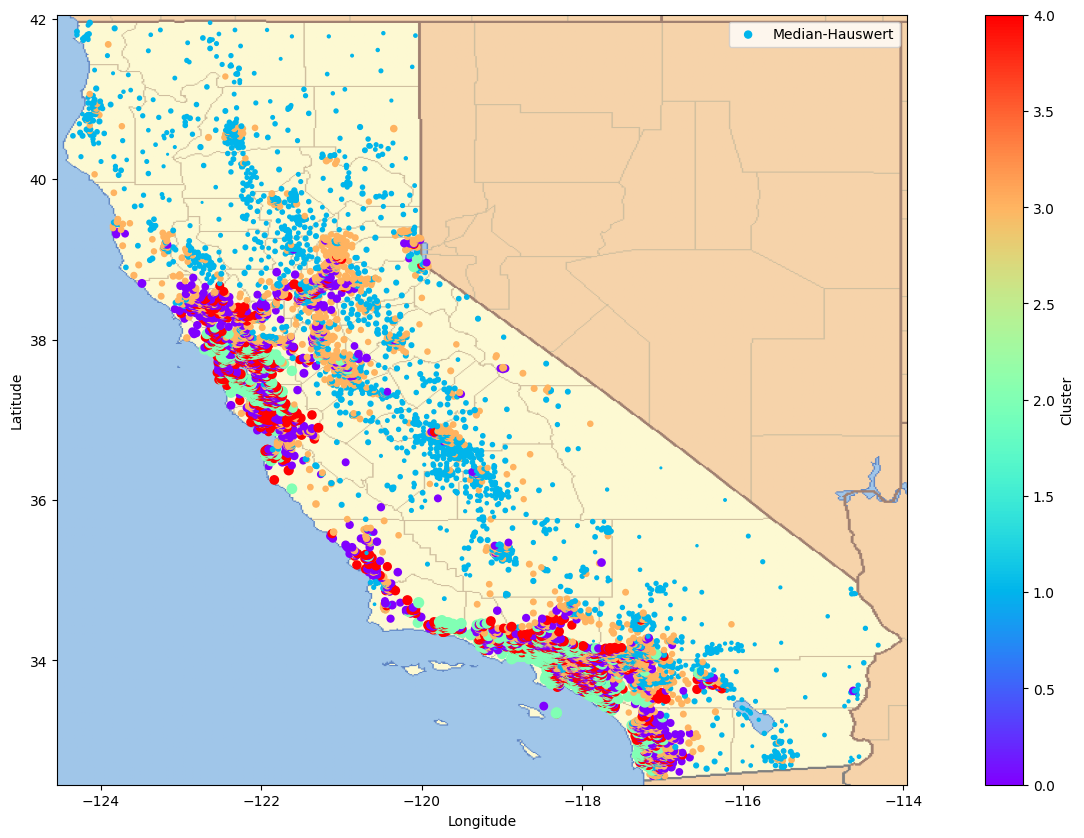

In [220]:
plot_axis =fdata.plot(
             kind="scatter", x="longitude", y="latitude",
             s=fdata["median_house_value"] / 10000,
             xlabel="Longitude", ylabel="Latitude",
             label="Median-Hauswert",
             c=kmeans_labels, cmap='rainbow',
             colorbar=True,
             legend=True,
             sharex=False, figsize=(20, 10))
plot_axis.collections[0].colorbar.set_label('Cluster')
axisrange = [-124.55, -113.95, 32.45, 42.05]
plt.axis(axisrange)
plt.imshow(cal_img, extent=axisrange)
plt.show()

In [221]:
del candidate, candidates
del cluster_labels
del kmeans, kmeans_labels

### Aufgabe C-2 b)
> Um den aus Aufgabe C-1 erhaltenen Datensatz zu clustern, ist das Verfahren Agglomerative Hierarchical Clustering anzuwenden. In das Clustering sollen lediglich die Merkmale latitude, longitude, median_house_value und fire_zone einfließen. Die Wahl der Cluster-Anzahl ist (etwa durch eine geeignete Heuristik) zu begründen. Ein Scatter-Plot zur Visualisierung der Cluster ist zu erzeugen.


Wir nutzen wie im vorherigen Aufgabenteil wieder 5 Cluster, basierend auf dem Silhouettenkoeffizienten

In [222]:
np.random.seed(seed)
agglomerative = sklearn.cluster.AgglomerativeClustering(n_clusters=numclusters)
agglo_labels = agglomerative.fit_predict(cdata)

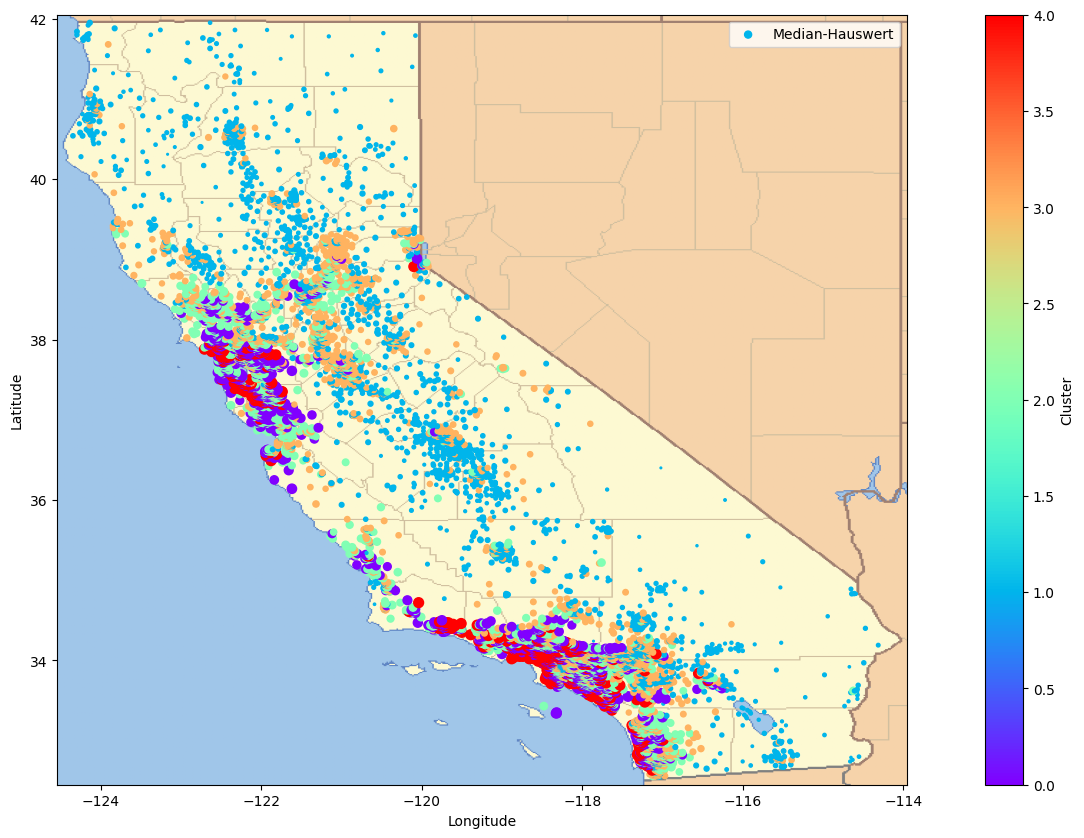

In [223]:
plot_axis =fdata.plot(
             kind="scatter", x="longitude", y="latitude",
             s=fdata["median_house_value"] / 10000,
             xlabel="Longitude", ylabel="Latitude",
             label="Median-Hauswert",
             c=agglo_labels, cmap='rainbow',
             colorbar=True,
             legend=True,
             sharex=False, figsize=(20, 10))
plot_axis.collections[0].colorbar.set_label('Cluster')
axisrange = [-124.55, -113.95, 32.45, 42.05]
plt.axis(axisrange)
plt.imshow(cal_img, extent=axisrange)
plt.show()

In [224]:
del agglo_labels
del agglomerative
del axisrange
del cal_img
del california_img_path
del fdata, cdata
del numclusters
del plot_axis

### Aufgabe C-2 c)
> Die Clusterings der beiden vorherigen Teilaufgaben sind zu vergleichen, indem auf drei Gemeinsamkeiten oder Unterschiede eingegangen wird.


**Übereinstimmendes Clustering im Inland**

Die beiden Clusterverfahren erzeugen in der breiten Fläche des Inlands (welches sich durch vergleichsweise niedrige Median-Hauswerte auszeichnet) fast identische Clusterzuordnungen (Farben Türkis und Orange). Im vergleich mit den Feuergefährdungszonen scheint das orangene Cluster tendenziell eine hohe Feuergefährdung und Türkis eine niedrige zu haben.

**Vergleichbare Kategorien in den urbanen Küstengebieten**

Das Clustering in den urbanen Küstegebieten (mittlere bis hohe Hauspreise) führt zumindest zu vergleichbaren Clustern. Eine grobe (vereinfachte) Interpetation der übrigen 3 Cluster wären
*   A: mittlere Preise, erhöhte Feuergefahr
*   B: hohe Preise, niedrige Feuergefahr
*   C: hohe Preise, hohe Feuergefahr

Diese sind in den Plots dargestellt mit
*   A: KMeans lila, Agglo grün
*   B: KMeans grün, Agglo rot
*   C: KMeans rot, Agglo lila



**Unterschiedliche Einteilung im Detail**

Im Detail liefern beide Algorithmen jedoch an einigen Stellen eine unterschiedliche Zuteilung zu den Clustern.
Ein Beispiel wären die beiden Insel-Datenpunkte bei ca. (-118.5, 33.5)
Die beiden Algorithmen haben in ihren Ergebnissen also vergleichbare Kategorien gewählt, aber unterschiedliche Kriterien und Grenzen für die konkrete Zuordnung.

### Aufgabe C-2 d)
>Ein Ansatz, wie die von einem der Clustering-Verfahren erzeugten Cluster bei der Tarifierung von Feuerversicherung in Kalifornien eingesetzt werden können, ist in zwei bis drei Sätzen zu erläutern.

Das Clustering kann eingesetzt werden, um für eine Feuerversicherung eine geringe Anzahl an unterschiedlichen Preiskategorien festzulegen, die sich anschließend pro Landkreis zuordnen lassen. Die höheren Versicherungsleistungen bei hochwertigeren Häusern des Gebiets und die Wahrscheinlichkeit eines Brandschadens mittels der Feuergefährdungszone können dabei zentrale Tarifmerkmale sein. Das Miteinbeziehen des geografischen Standpunktes kann hier einen "Smoothing"-Effekt bewirken, sodass die Zuordnungen zu den Preisstufen in einem Gebiet relativ einheitlich sind.

# Teil D: GPU-Ausführung und Vergleiche

## Aufgabe D-1: Ergebnisse persistieren

In [225]:
runtime_folder

'gpu/'

### Aufgabe D-1 a)

In [226]:
display(times)

{'Complete Linear': 0.172684907913208,
 'Complete CatBoost': 11.55141282081604,
 'Scaled Encoded CatBoost': 4.152780532836914,
 'Complete Neural Network GPU': 127.97513270378113,
 'Embedding Neural Network GPU': 173.1190299987793,
 'Cloned Neural Network GPU': 168.13663697242737,
 'lightGBM': 40.6359601020813,
 'XGBoost': 114.91345286369324}

In [227]:
if retrain_models:
  timesdf=pd.DataFrame(times.items(), columns=['Modellname','Laufzeit'])
  timescsvpath=results_path+'times.csv'
  timesdf.to_csv(timescsvpath, index=False)
  del timesdf, timescsvpath

In [228]:
display(rmses)

{'Numeric Linear': 74508.93978488311,
 'Numeric Catboost': 48912.79736396997,
 'Categorical Linear': 91193.2953907611,
 'Categorical Catboost': 89735.68699792186,
 'Complete Linear': 69098.04473488663,
 'Complete Catboost': 48361.638797917374,
 'Scaled Encoded Catboost': 48406.630856312855,
 'Complete Neural Network GPU': 55848.55913419424,
 'Embedding Neural Network GPU': 56440.34458079798,
 'Cloned Neural Network GPU': 57624.919823973854,
 'lightGBM': 47584.96967530819,
 'XGBoost': 50459.16902941104}

In [229]:
rmsesdf=pd.DataFrame(rmses.items(), columns=['Modellname','RMSE auf Validierungsdaten'])
rmsescsvpath=results_path+'rmses.csv'
rmsesdf.to_csv(rmsescsvpath, index=False)
del rmsesdf, rmsescsvpath

In [230]:
display(rmsestest)

{'Complete Catboost': 45427.075729708304,
 'Scaled Encoded Catboost': 46154.39938978077,
 'Complete Neural Network GPU': 54340.25322784039,
 'Embedding Neural Network GPU': 54123.96676776603,
 'Cloned Neural Network GPU': 55075.31593666789,
 'lightGBM': 45852.00825481911,
 'XGBoost': 48551.297191733196}

In [231]:
rmsestestdf=pd.DataFrame(rmsestest.items(), columns=['Modellname','RMSE auf Testdaten'])
rmsestestcsvpath=results_path+'rmsestest.csv'
rmsestestdf.to_csv(rmsestestcsvpath, index=False)
del rmsestestdf, rmsestestcsvpath

## Aufgabe D-3: Vergleich der Ergebnisse und Erfahrungen

### Aufgabe D-3 a)
> Die zur Verfügung stehenden Ressourcen der CPU- und GPU-Umgebung sind zu nennen und zu vergleichen. Bei Nutzung einer öffentlich zugänglichen Cloud-Umgebung sind diese Angaben mit einer Quellenangabe zu versehen.



Die Ausführung des Notebooks geschieht in google collab. Als Quelle der benutzten Hadrware wird direkt per Code abgefragt:

CPU-Hardware:

In [232]:
print("Anzahl CPUs:",psutil.cpu_count())

Anzahl CPUs: 2


In [233]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
stepping	: 3
microcode	: 0xffffffff
cpu MHz		: 2000.146
cache size	: 39424 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmi

Wir haben also einen Intel(R) Xeon(R) CPU @ 2.20GHz mit 2 CPUs zur Verfügung

GPU-Hardware

In [234]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
for gpu in physical_devices:
  display(tf.config.experimental.get_device_details(gpu))

{'compute_capability': (7, 5), 'device_name': 'Tesla T4'}

Wir haben also ein Nvidia Tesla T4 als GPU zur Verfügung

Sowohl die CPU als auch die GPU sind vergleichsweise performante Hardware. Die CPU ist, sogar mehr als viele andere vergleichbare CPUs, auf hohe Leistung bei Single-Threaded Tasks ausgelegt. Die GPU ist -- natürlich -- vor allem bei hoch parallelisierbaren Aufgaben performant und die Tesla T4 ist insbesondere von der Architektur her auf Machine Learning und KI-Training spezialisiert. Verglichen mit GPU-Modellen die im Privatgebrauch üblich sind wäre sie performancetechnisch vermutlich mit einer GeForce RTX 3080 oder ähnlichem zu vergleichen.

### Aufgabe D-3 b)
>Die in Aufgabe D-1 gespeicherten Ergebnisse (Performance, Laufzeiten) und Modelle des CPU-Notebooks sind einzulesen (ggf. müssen diese Daten zuvor für das GPU-Notebook verfügbar gemacht werden).

In [235]:
cpu_results_path=folder_path+'cpu/'
model_embed_1_cpu,_ = load_model(cpu_results_path,'NN_embed')
model_embed_2_cpu,_ = load_model(cpu_results_path,'NN_cloned')
timesdfcpu = pd.read_csv(cpu_results_path+'times.csv')
timescpu = dict(zip(timesdfcpu['Modellname'], timesdfcpu['Laufzeit']))
rmsesdfcpu = pd.read_csv(cpu_results_path+'rmses.csv')
rmsescpu = dict(zip(rmsesdfcpu['Modellname'], rmsesdfcpu['RMSE auf Validierungsdaten']))

/content/drive/MyDrive/cads/pruefung/cpu/NN_embed_model.h5
/content/drive/MyDrive/cads/pruefung/cpu/NN_cloned_model.h5


### Aufgabe D-3 c)
>Die vier CPU-Embeddings sind zu extrahieren und zusammen mit den vier GPU-Embeddings anzeigen (je ein „Kleeblatt“ für county_name und ocean_proximity), analysieren und die Ursachen beobachteter Unterschiede sind zu beleuchten.

In [236]:
gpu_results_path=folder_path+'gpu/'
model_embed_1_gpu,_ = load_model(gpu_results_path,'NN_embed_GPU')
model_embed_2_gpu,_ = load_model(gpu_results_path,'NN_cloned_GPU')

/content/drive/MyDrive/cads/pruefung/gpu/NN_embed_GPU_model.h5
/content/drive/MyDrive/cads/pruefung/gpu/NN_cloned_GPU_model.h5


Embeddings von CPU und GPU als 4x4 plotten

1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 34ms/step


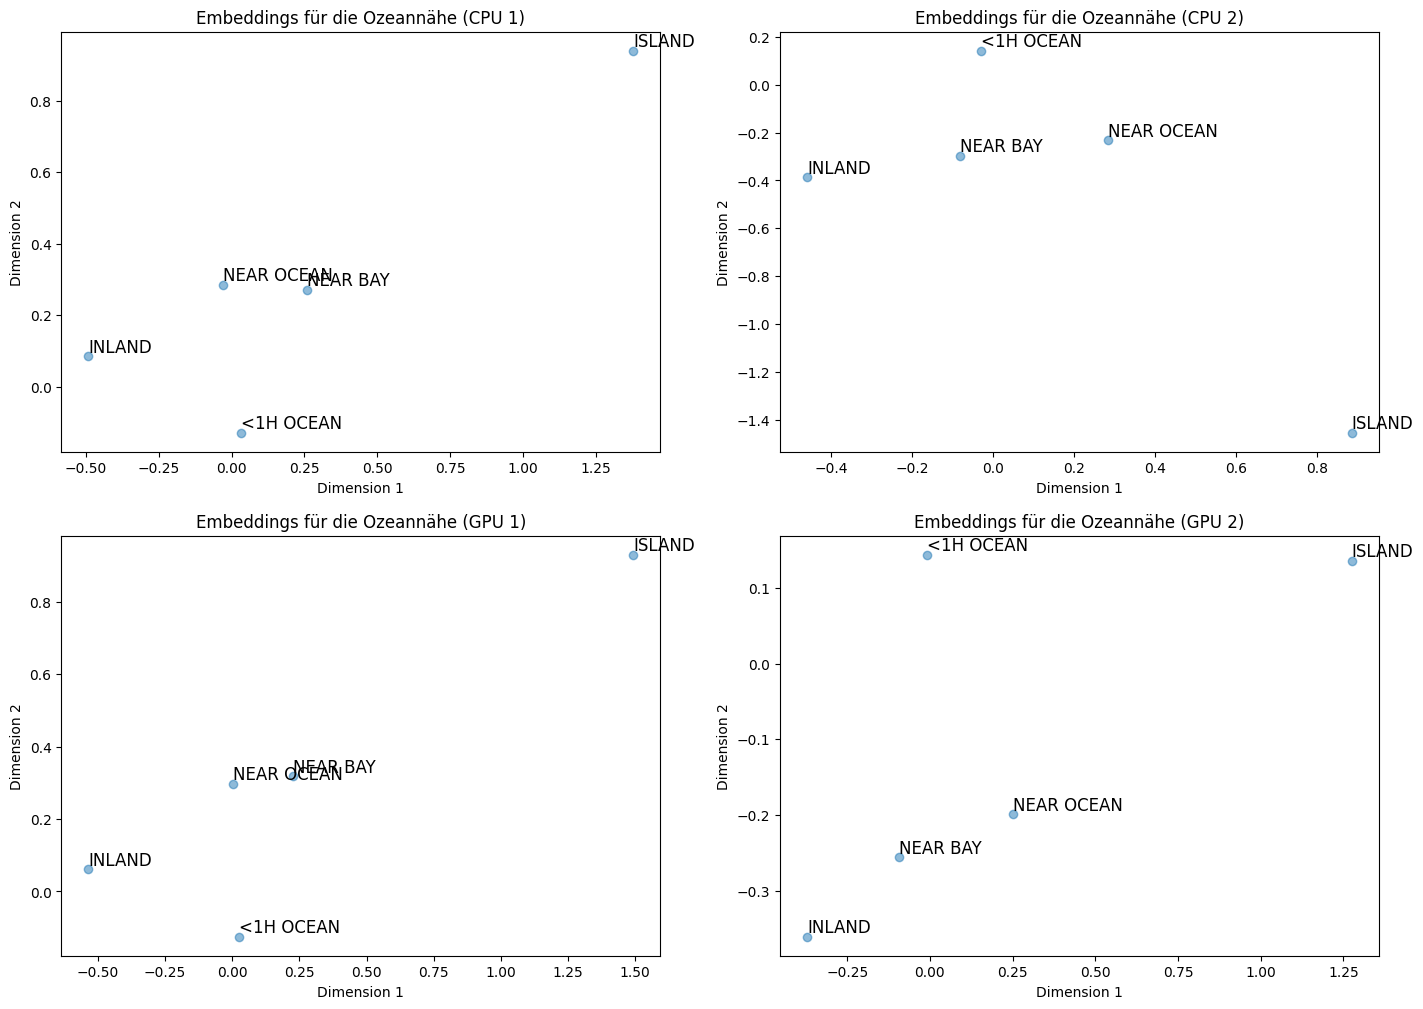

In [237]:
fig, axs = plt.subplots(2, 2, figsize=(17, 12))
feature_name='ocean_proximity'
ocean_prox_embedding = model_embed_1_cpu.layers[2]
ocean_prox_input = model_embed_1_cpu.input[0]
embedding_model_ocean = keras.models.Model(inputs=ocean_prox_input, outputs=ocean_prox_embedding.output)
plot_embedding_ax(ax=axs[0,0], feature_name=feature_name, embedding_model=embedding_model_ocean, x_train=data, title='Embeddings für die Ozeannähe (CPU 1)')

ocean_prox_embedding = model_embed_2_cpu.layers[2]
ocean_prox_input = model_embed_2_cpu.input[0]
embedding_model_ocean = keras.models.Model(inputs=ocean_prox_input, outputs=ocean_prox_embedding.output)
plot_embedding_ax(ax=axs[0,1], feature_name=feature_name, embedding_model=embedding_model_ocean, x_train=data, title='Embeddings für die Ozeannähe (CPU 2)')

ocean_prox_embedding = model_embed_1_gpu.layers[2]
ocean_prox_input = model_embed_1_gpu.input[0]
embedding_model_ocean = keras.models.Model(inputs=ocean_prox_input, outputs=ocean_prox_embedding.output)
plot_embedding_ax(ax=axs[1,0], feature_name=feature_name, embedding_model=embedding_model_ocean, x_train=data, title='Embeddings für die Ozeannähe (GPU 1)')

ocean_prox_embedding = model_embed_2_gpu.layers[2]
ocean_prox_input = model_embed_2_gpu.input[0]
embedding_model_ocean = keras.models.Model(inputs=ocean_prox_input, outputs=ocean_prox_embedding.output)
plot_embedding_ax(ax=axs[1,1], feature_name=feature_name, embedding_model=embedding_model_ocean, x_train=data, title='Embeddings für die Ozeannähe (GPU 2)')

plt.show()

2/2 [==============================] - 0s 4ms/step


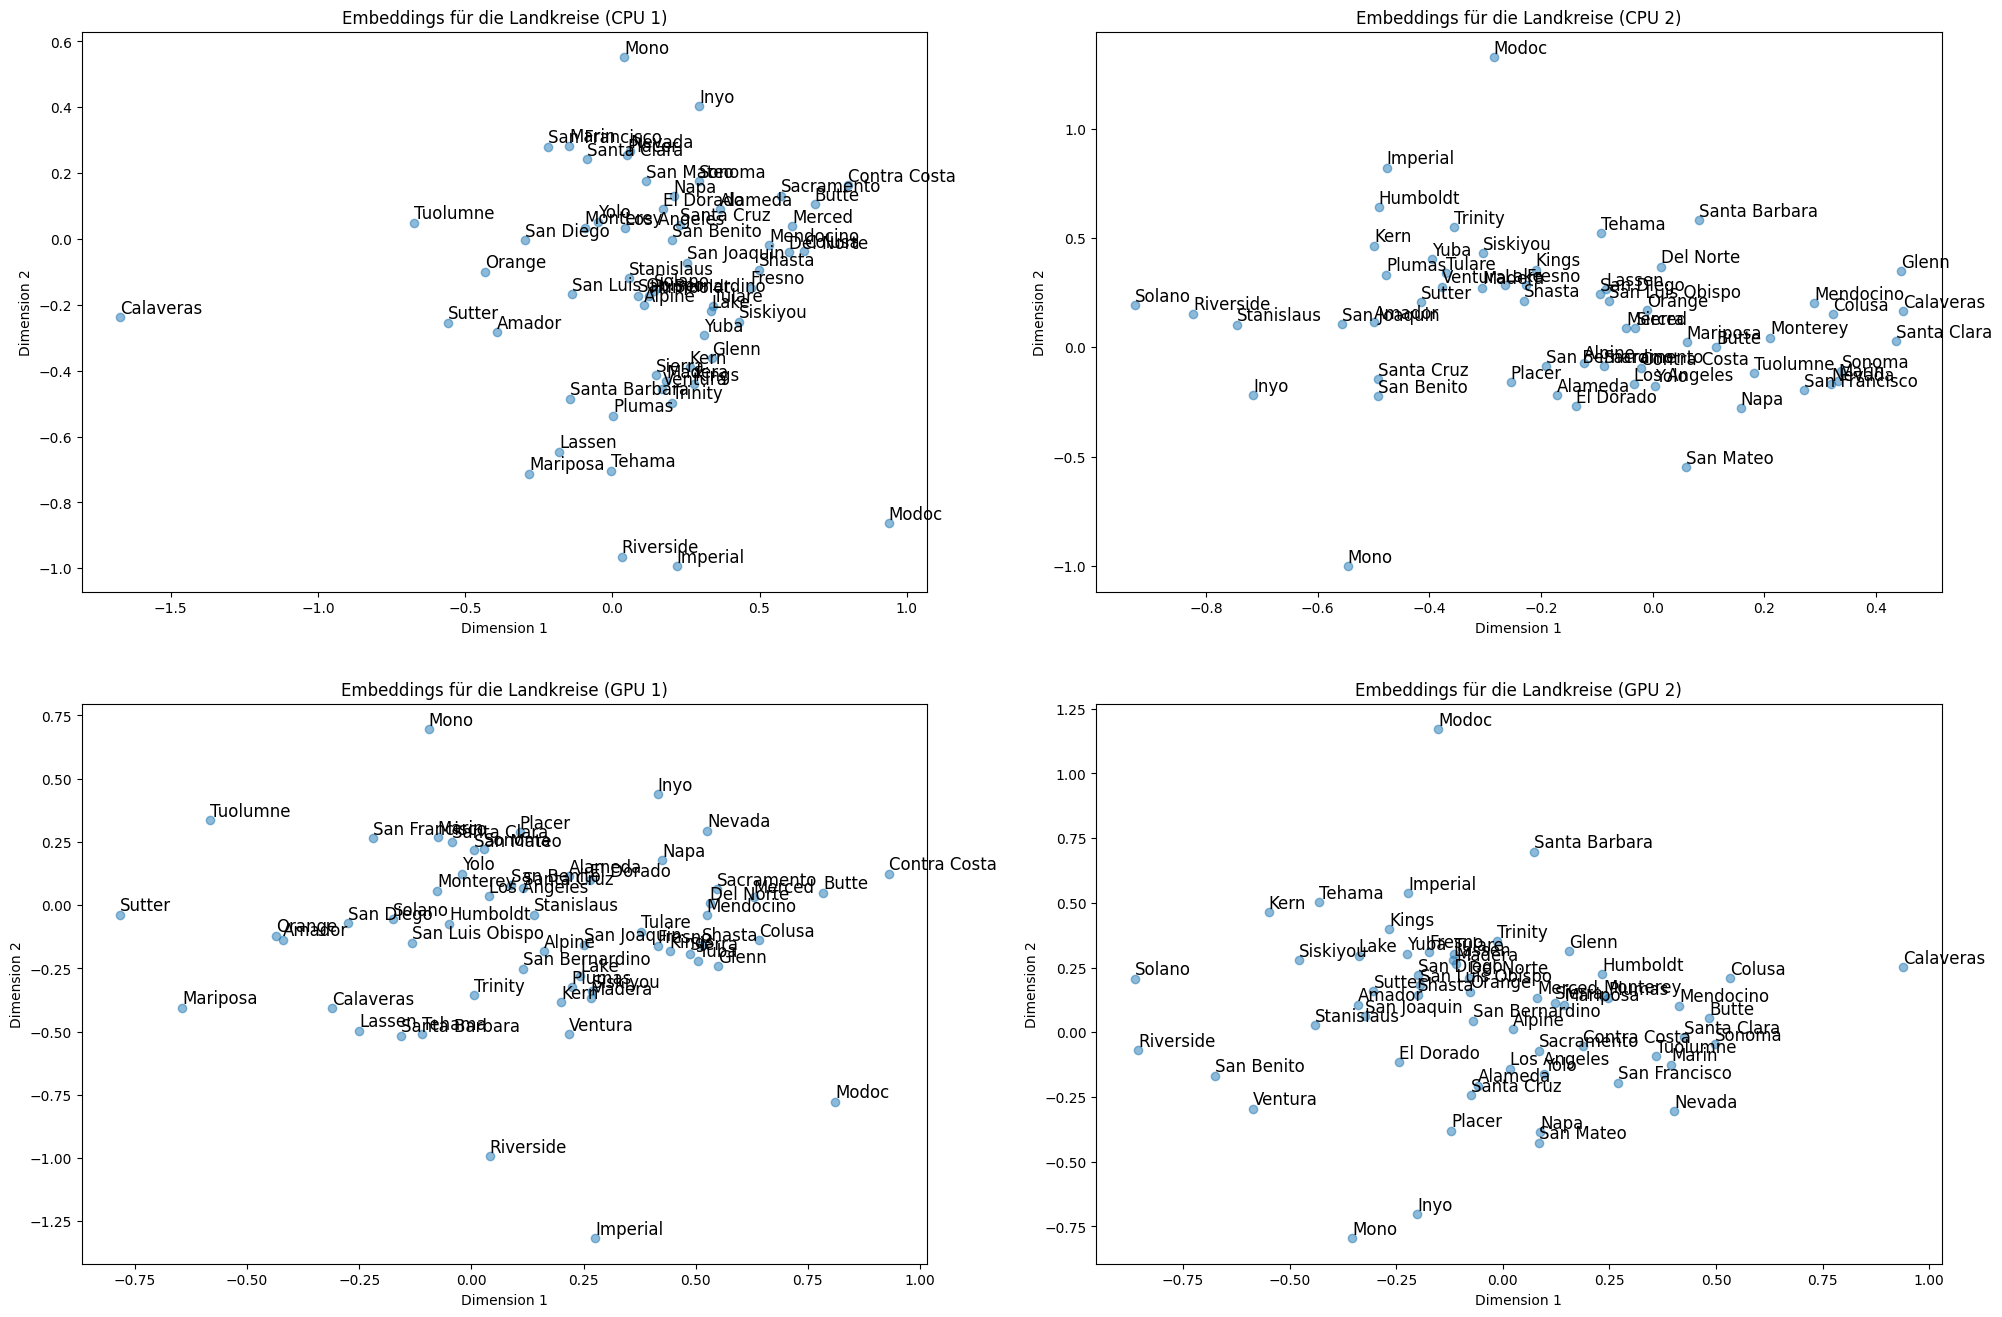

In [238]:
fig, axs = plt.subplots(2, 2, figsize=(24, 16))
feature_name='county_name'
county_name_embedding = model_embed_1_cpu.layers[3]
county_name_input = model_embed_1_cpu.input[1]
embedding_model_county = keras.models.Model(inputs=county_name_input, outputs=county_name_embedding.output)
plot_embedding_ax(ax=axs[0,0], feature_name=feature_name, embedding_model=embedding_model_county, x_train=data, title='Embeddings für die Landkreise (CPU 1)')

county_name_embedding = model_embed_2_cpu.layers[3]
county_name_input = model_embed_2_cpu.input[1]
embedding_model_county = keras.models.Model(inputs=county_name_input, outputs=county_name_embedding.output)
plot_embedding_ax(ax=axs[0,1], feature_name=feature_name, embedding_model=embedding_model_county, x_train=data, title='Embeddings für die Landkreise (CPU 2)')

county_name_embedding = model_embed_1_gpu.layers[3]
county_name_input = model_embed_1_gpu.input[1]
embedding_model_county = keras.models.Model(inputs=county_name_input, outputs=county_name_embedding.output)
plot_embedding_ax(ax=axs[1,0], feature_name=feature_name, embedding_model=embedding_model_county, x_train=data, title='Embeddings für die Landkreise (GPU 1)')

county_name_embedding = model_embed_2_gpu.layers[3]
county_name_input = model_embed_2_gpu.input[1]
embedding_model_county = keras.models.Model(inputs=county_name_input, outputs=county_name_embedding.output)
plot_embedding_ax(ax=axs[1,1], feature_name=feature_name, embedding_model=embedding_model_county, x_train=data, title='Embeddings für die Landkreise (GPU 2)')

plt.show()

Die jeweils ersten Ausführungen von CPU und GPU ähneln sich stark, sind aber nicht identisch. Das gleiche gilt für die jeweils zweiten Ausführungen.

Da wir zur Reproduzierbarkeit den Random Seed festgesetzt haben ist das ähnliche Ergebnis bei der ersten und zweiten Ausführung nicht verwunderlich, da somit die Gewichte vermutlich gleich initialisiert wurden. Durch die unterschiedlichen darunter liegenden Implementierungen von Tensorflow zwischen CPU und GPU wird es aber dennoch Detailunterschiede in der Berechnung geben, welche dann zu den hier beobachtbaren "kleinen" Verschiebungen in den Embeddings führt.

### Aufgabe D-3 d)
> Die Laufzeiten und Performance der CPU- und GPU-Ausführung sind anschaulich zu vergleichen und die Unterschiede sind zu interpretieren.

In den folgenden Grafiken bezeichnet

* "Numerical Linear" das lineare Modell auf den numerischen Testdaten
* "Categorical Linear" das lineare Modell auf den kategoriellen Testdaten
* "Complete Linear" das lineare Modell auf allen Testdaten
* "Numerical Catboost" das Catboost-Modell auf den numerischen Testdaten
* "Categorical Catboost" das Catboost-Modell auf den kategoriellen Testdaten
* "Complete Catboost" das Catboost-Modell auf allen Testdaten
* "Complete Neural Network" das neuronale Netzwerk mit One-Hot-Codierung auf allen Testdaten
* "Embedding Neural Network" das erste neuronale Netzwerk mit Embedding auf allen Testdaten
* "Cloned Neural Network" das zweite neuronale Netzwerk mit Embedding auf allen Testdaten



In [239]:
timesdfgpu = pd.read_csv(gpu_results_path+'times.csv')
timesgpu = dict(zip(timesdfgpu['Modellname'], timesdfgpu['Laufzeit']))
rmsesdfgpu = pd.read_csv(gpu_results_path+'rmses.csv')
rmsesgpu = dict(zip(rmsesdfgpu['Modellname'], rmsesdfgpu['RMSE auf Validierungsdaten']))

In [240]:
rmsesgpu['Complete Neural Network'] = rmsesgpu.pop('Complete Neural Network GPU')
rmsesgpu['Embedding Neural Network'] = rmsesgpu.pop('Embedding Neural Network GPU')
rmsesgpu['Cloned Neural Network'] = rmsesgpu.pop('Cloned Neural Network GPU')
timesgpu['Complete Neural Network'] = timesgpu.pop('Complete Neural Network GPU')
timesgpu['Embedding Neural Network'] = timesgpu.pop('Embedding Neural Network GPU')
timesgpu['Cloned Neural Network'] = timesgpu.pop('Cloned Neural Network GPU')

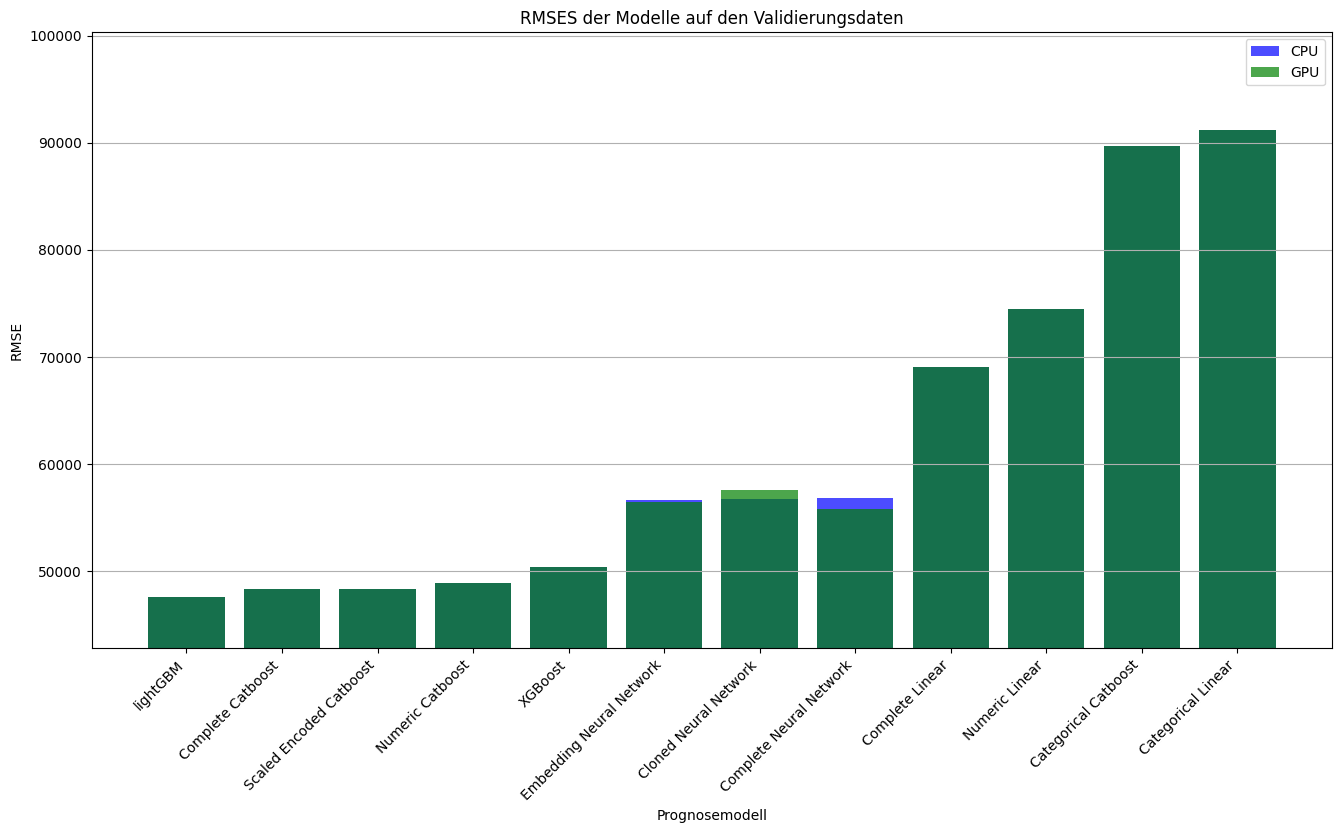

In [241]:
sorted_rmses_cpu = sorted(rmsescpu.items(), key=lambda x: x[1])
sorted_rmses_gpu = sorted(rmsesgpu.items(), key=lambda x: x[1])
modelle_cpu = [item[0] for item in sorted_rmses_cpu]
modelle_gpu = [item[0] for item in sorted_rmses_gpu]
rmse_values_cpu = [item[1] for item in sorted_rmses_cpu]
rmse_values_gpu = [item[1] for item in sorted_rmses_gpu]
plt.figure(figsize=(16, 8))
plt.bar(modelle_cpu, rmse_values_cpu, color='blue', alpha=0.7,label='CPU')
plt.bar(modelle_gpu, rmse_values_gpu, color='green', alpha=0.7,label='GPU')
plt.xlabel('Prognosemodell')
plt.ylabel('RMSE')
plt.title('RMSES der Modelle auf den Validierungsdaten')
plt.ylim(0.9*min(min(rmse_values_cpu),min(rmse_values_gpu)), 1.1*max(max(rmse_values_cpu),max(rmse_values_gpu)))
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y')
plt.show()

Die RMSEs unterscheiden sich zwischen der CPU und GPU-Ausführung nur in den neuronalen Netzen -- hier scheint trotz den Möglichkeiten des festgesetzten Seeds dennoch ein unterschiedlicher Ablauf des Algorithmus zwischen CPU und GPU zu existieren. Die Unterschiede sind allerdings gering und scheinen im Durchschnitt weder die eine noch die andere Architektur zu favorisieren.

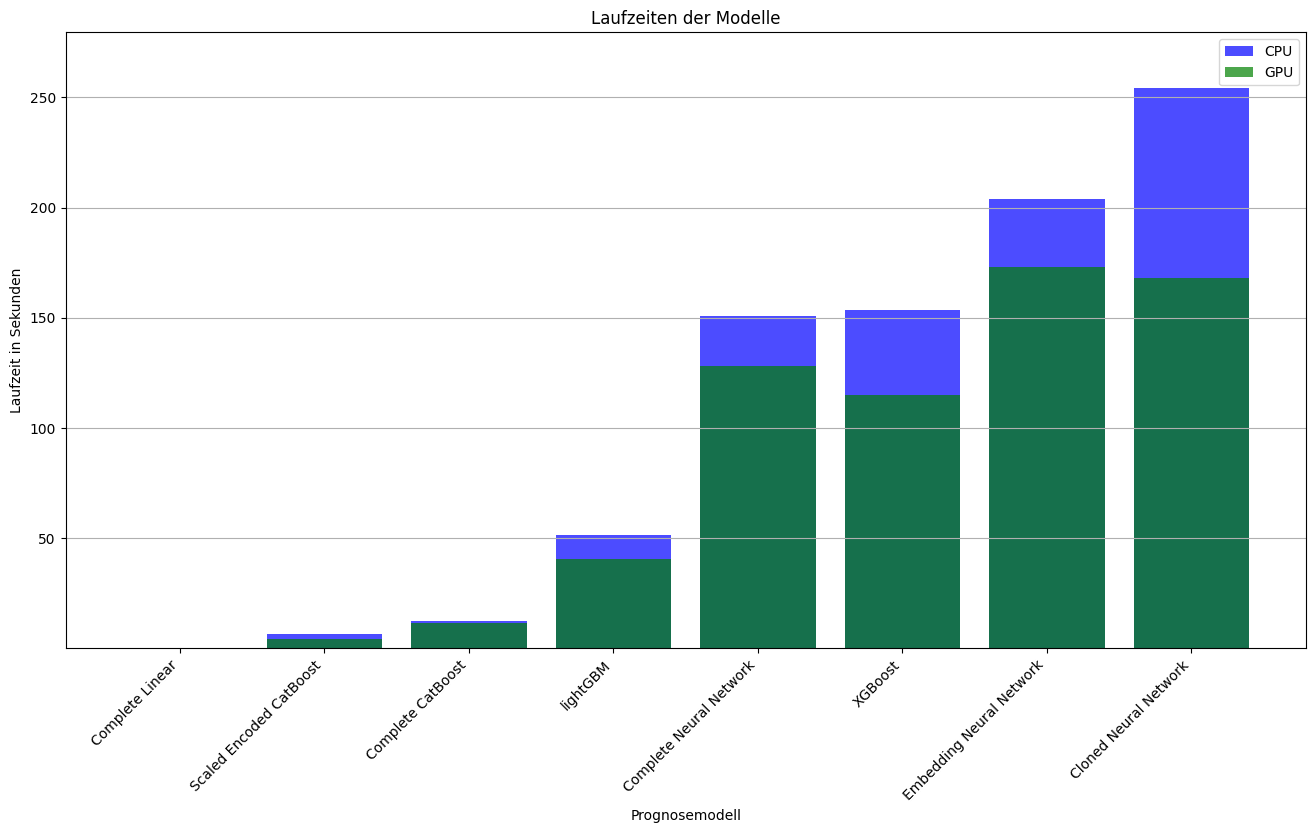

In [242]:
sorted_times_cpu = sorted(timescpu.items(), key=lambda x: x[1])
sorted_times_gpu = sorted(timesgpu.items(), key=lambda x: x[1])
modelle_cpu = [item[0] for item in sorted_times_cpu]
modelle_gpu = [item[0] for item in sorted_times_gpu]
times_values_cpu = [item[1] for item in sorted_times_cpu]
times_values_gpu = [item[1] for item in sorted_times_gpu]
plt.figure(figsize=(16, 8))
plt.bar(modelle_cpu, times_values_cpu, color='blue', alpha=0.7,label='CPU')
plt.bar(modelle_gpu, times_values_gpu, color='green', alpha=0.7,label='GPU')
plt.xlabel('Prognosemodell')
plt.ylabel('Laufzeit in Sekunden')
plt.title('Laufzeiten der Modelle')
plt.ylim(0.9*min(min(times_values_cpu),min(times_values_gpu)), 1.1*max(max(times_values_cpu),max(times_values_gpu)))
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y')
plt.show()

Die GPU liefert durchweg bessere Laufzeiten.

Die Laufzeit des linearne Modells ist so gering dass es in der Vergleichsgrafik nicht sichtbar ist.

Bei den CatBoost-Zeiten gibt es einen leichten Vorteil für die GPU, aber dies kann auch lediglich eine natürliche Schwankung der Laufzeit und verfügbaren Resourcen in der Cloud-Umgebung darstellen, wir haben die GPU für Catboost zumindest nicht explizit aktiviert.

Bei lightGBM ist der Laufzeitvorteil der GPU moderat, während XGBoost und die neuronalen Netze alle einen deutlichen Speedup durch eine GPU-Ausführung erfahren. Im Durchschnitt benötigt man bei diesen Modellen gegenüber der CPU-Ausführung nur ca. 70% der Laufzeit. Bei größeren neuronalen Netzen wäre dieser Unterschied sicherlich noch gravierender.


### Aufgabe D-3 e)
>Als Gesamtfazit sind Empfehlungen hinsichtlich der verwendeten Modelle, grafischen Darstellungen und Rechenumgebungen (CPU/GPU) abzuleiten.

**Verwendete Modelle**

CatBoost ist unseren Ergebnissen nach das beste Modell für diesen Anwendungsfall. Es wird zwar in einzelnen Kategorien jeweils geschlagen (lineares Modell mit besserer Laufzeit, lightGBM mit knapp besserer Performance), aber bietet eindeutig den besten Kompromiss aus beiden Dimensionen. Zusätzlich ist es bereits ohne Encoding und Hyperparameter-Tuning so erfolgreich, womit die Möglichkeit gegeben ist, bei Bedarf noch besser auf den Anwendungsfall zugeschnittene Anpassungen zu machen.

**Grafische Darstellungen**

Die visuelle Darstellung des Datensatzes mittels einer Karte der Örtlichkeit ist hier die beste und  unabdingbare Hilfe zur Einordnung der Daten und Begreifen der Zusammenhänge zwischen Ort und Ausprägung. Die Verteilungsgrafiken mit Kerndichteschätzer geben zunächst einen guten Überblick über die Verteilungen innerhalb des Datensatzes, wärend die Heatmap der Korrelationen ein einfacher und anschaulicher Weg war, offensichtliche Zusammenhänge und ggf. überflüssige Informationen zu finden.

**Rechenumgebung**

Wo eine Ausführung des Algorithmus auf der GPU möglich (und vom Algorthmus selbst her sinnvoll) ist, spart dies eine Menge Laufzeit und ist grundsätzlich zu bevorzugen. Bei Nutzung einer Cloud-Umgebung ist allerdings darauf zu achten, die GPU-Nutzung durch wiederholtes Tuning der Parameter nicht bereits vor Prüfungsende über die Nutzungslimits hinaus zu beanspruchen :-)